# Chest X-Ray Image Classification
    
In this project I'll create Neural Networks to classify whether an X-Ray image is of a chest with pneumonia or without.   
 - split the data into train / validation / test sets.   
 - preprocess the images for inputting them into the model.   
 - look into the images and class balance
 - create a baseline model 
 - create models using CNNs and trying different options
 - use transfer learning: building off of the base of a previously trained network
 - create a final model
 - visualise layers within the model

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Accuracy, Recall, Precision
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import SGD
from keras.initializers import LecunNormal, RandomNormal, RandomUniform
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

np.random.seed(42)

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.5 when it was built against 1.10.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


## Split Data

The data is from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia   
There is some doubt over the labeling of the test set, and the validation set only has 16 images. So my first task is to split the training and validation data into train / validation / test

In [4]:
#Split data
import os, shutil

normal_dir = 'chest_xray/train/NORMAL/'
pneu_dir = 'chest_xray/train/PNEUMONIA/'
new_dir = 'chest_xray/split/'

imgs_normal = [file for file in os.listdir(normal_dir) if file.endswith('.jpeg')]
imgs_pneu = [file for file in os.listdir(pneu_dir) if file.endswith('.jpeg')]
print('num. normal:', len(imgs_normal))
print('num. pneumonia:', len(imgs_pneu))
try:
    os.mkdir(new_dir)
except FileExistsError:
    pass
train_folder = os.path.join(new_dir, 'train')
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneu = os.path.join(train_folder, 'PNEUMONIA')

val_folder = os.path.join(new_dir, 'val')
val_normal = os.path.join(val_folder, 'NORMAL')
val_pneu = os.path.join(val_folder, 'PNEUMONIA')


test_folder = os.path.join(new_dir, 'test')
test_normal = os.path.join(test_folder, 'NORMAL')
test_pneu = os.path.join(test_folder, 'PNEUMONIA')

try:
    os.mkdir(train_folder)
    os.mkdir(train_normal)
    os.mkdir(train_pneu)
    os.mkdir(val_folder)
    os.mkdir(val_normal)
    os.mkdir(val_pneu)
    os.mkdir(test_folder)
    os.mkdir(test_normal)
    os.mkdir(test_pneu)
except FileExistsError:
    pass


num. normal: 1341
num. pneumonia: 3875


Split: ratio: normal: pneumonia  
Train: 0.7 : 939 : 2713   
Val: 0.15 : 201 : 581   
Test: 0.15 : 201 : 581

In [8]:
np.random.shuffle(imgs_normal)
np.random.shuffle(imgs_pneu)

imgs = imgs_normal[:939]
for img in imgs:
    origin = os.path.join(normal_dir, img)
    destination = os.path.join(train_normal, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_normal[939:1140]
for img in imgs:
    origin = os.path.join(normal_dir, img)
    destination = os.path.join(val_normal, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_normal[1140:]
for img in imgs:
    origin = os.path.join(normal_dir, img)
    destination = os.path.join(test_normal, img)
    shutil.copyfile(origin, destination)

imgs = imgs_pneu[:2713]
for img in imgs:
    origin = os.path.join(pneu_dir, img)
    destination = os.path.join(train_pneu, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_pneu[2713:3294]
for img in imgs:
    origin = os.path.join(pneu_dir, img)
    destination = os.path.join(val_pneu, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_pneu[3294:]
for img in imgs:
    origin = os.path.join(pneu_dir, img)
    destination = os.path.join(test_pneu, img)
    shutil.copyfile(origin, destination)


## Image Preprocessing

Here I preprocess the images so they can be input into the meural network.

In [147]:
train_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(
    train_folder, target_size=(128,128), batch_size=3652, color_mode='rgb')
val_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(
    val_folder, target_size=(128,128), batch_size=782, color_mode='rgb')
test_gen = ImageDataGenerator(rescale=1/255).flow_from_directory(
    test_folder, target_size=(128,128), batch_size=782, color_mode='rgb')

Found 3652 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


In [148]:
train_imgs, train_y = next(train_gen)
val_imgs, val_y = next(val_gen)
test_imgs, test_y = next(test_gen)

train_vec = train_imgs.reshape(train_imgs.shape[0],-1)
val_vec = val_imgs.reshape(val_imgs.shape[0],-1)
test_vec = test_imgs.reshape(test_imgs.shape[0],-1)

train_y = train_y[:,0]
val_y = val_y[:,0]
test_y = test_y[:,0]

## EDA

Class balance and examples of images with/without pneumonia

In [346]:
print('Train, NORMAL\t\t', len(os.listdir(train_normal)))
print('Train, PNEUMONIA\t', len(os.listdir(train_pneu)))
print('Validation, NORMAL\t', len(os.listdir(val_normal)))
print('Validation, PNEUMONIA\t', len(os.listdir(val_pneu)))
print('Test, NORMAL\t\t', len(os.listdir(test_normal)))
print('Test, PNEUMONIA\t\t', len(os.listdir(test_pneu)))

Train, NORMAL		 939
Train, PNEUMONIA	 2713
Validation, NORMAL	 201
Validation, PNEUMONIA	 581
Test, NORMAL		 201
Test, PNEUMONIA		 581


In [350]:
train_vec.shape

(3652, 49152)

Image of case with pneumonia


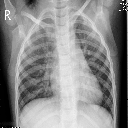

In [374]:
print('Image of case with pneumonia')
array_to_img(train_imgs[0])

Image of case without pneumonia: normal


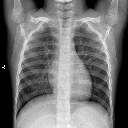

In [376]:
print('Image of case without pneumonia: normal')
array_to_img(train_imgs[2])

In [364]:
train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Results Function

In [204]:
def results(history, model):
    graph(history)
    print(model.evaluate(test_imgs, test_y))
    y_pred = model.predict_classes(test_imgs)
    print(confusion_matrix(test_y, y_pred))
    print(classification_report(test_y, y_pred, target_names=['Normal', 'Pneumonia']))

def graph(history):
    df = pd.DataFrame(history.history)
    df.iloc[:,[0,4]].plot(figsize=(14,6))
    df.iloc[:,[1,5]].plot(figsize=(14,6))
    df.iloc[:,[2,6]].plot(figsize=(14,6))
    df.iloc[:,[3,7]].plot(figsize=(14,6))
    df.iloc[:,[6,7]].plot(figsize=(14,6))
    

## Baseline Model

Create a baseline model using a basic, densely connected, sequential neural network

In [174]:
base_model = Sequential()
base_model.add(Dense(32, 'relu', input_shape=(49152,)))
base_model.add(Dense(16, 'relu'))
base_model.add(Dense(8, 'relu'))
base_model.add(Dense(1, 'sigmoid'))

base_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Recall(), Precision()])
es = EarlyStopping(patience=10, restore_best_weights=True)
mc_base = ModelCheckpoint('models/base_models/{epoch:02d}.h5')
cb = [es, mc_base]
history = base_model.fit(train_vec, train_y, epochs=30, batch_size=100, validation_data=(val_vec, val_y), callbacks=[cb])

Epoch 1/30
37/37 [==============================] - 6s 74ms/step - loss: 0.6805 - acc: 0.6227 - recall_41: 0.2830 - precision_40: 0.2830 - val_loss: 0.5760 - val_acc: 0.7430 - val_recall_41: 0.0000e+00 - val_precision_40: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 1s 32ms/step - loss: 0.5618 - acc: 0.7505 - recall_41: 0.0000e+00 - precision_40: 0.0000e+00 - val_loss: 0.5587 - val_acc: 0.7430 - val_recall_41: 0.0000e+00 - val_precision_40: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 1s 28ms/step - loss: 0.5705 - acc: 0.7226 - recall_41: 0.0000e+00 - precision_40: 0.0000e+00 - val_loss: 0.5368 - val_acc: 0.7430 - val_recall_41: 0.0000e+00 - val_precision_40: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 1s 25ms/step - loss: 0.5203 - acc: 0.7475 - recall_41: 0.0000e+00 - precision_40: 0.0000e+00 - val_loss: 0.4966 - val_acc: 0.7430 - val_recall_41: 0.0000e+00 - val_precision_40: 0.0000e+00
Epoch 5/30
37/37 [==========================

25/25 [==============================] - 0s 12ms/step - loss: 0.1073 - acc: 0.9642 - recall_41: 0.9055 - precision_40: 0.9529
[0.10726889967918396, 0.9641943573951721, 0.9054726362228394, 0.9528796076774597]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[572   9]
 [ 19 182]]
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98       581
   Pneumonia       0.95      0.91      0.93       201

    accuracy                           0.96       782
   macro avg       0.96      0.94      0.95       782
weighted avg       0.96      0.96      0.96       782



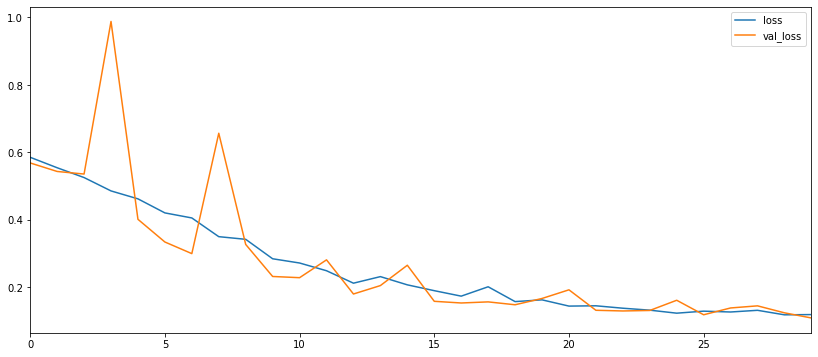

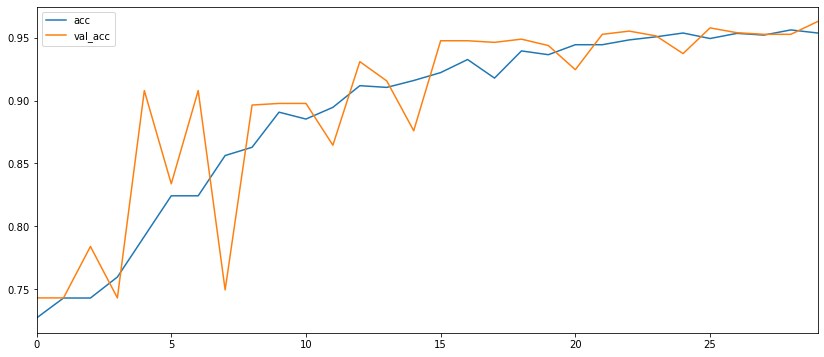

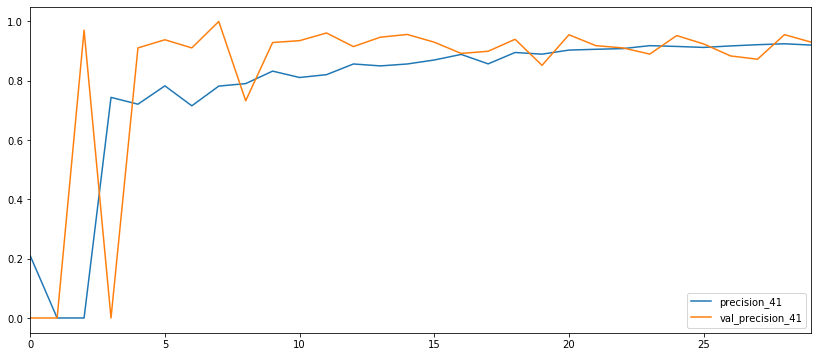

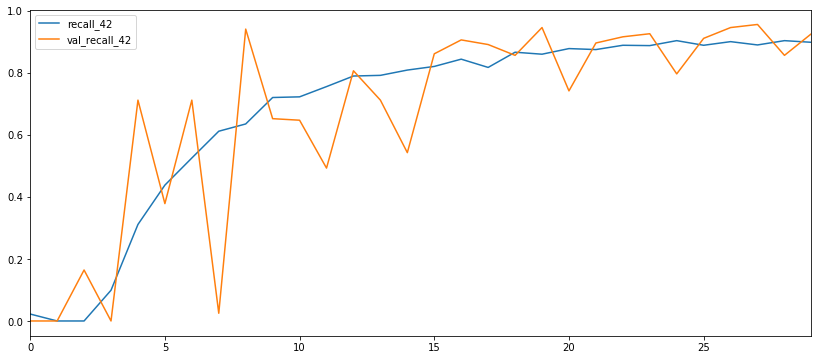

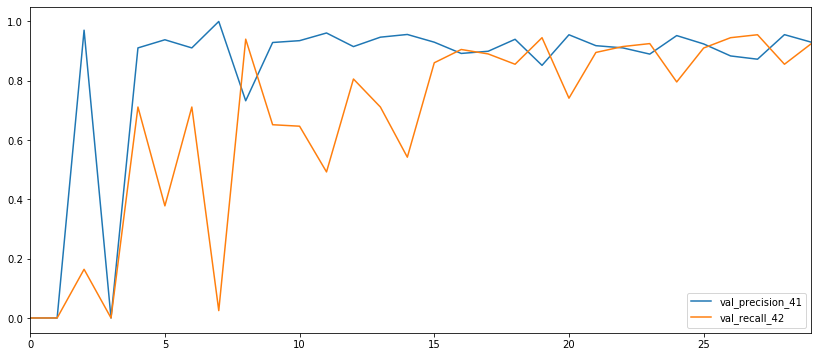

In [205]:
graph(history)
print(base_model.evaluate(test_vec, test_y))
y_pred = base_model.predict_classes(test_vec)
print(confusion_matrix(test_y, y_pred))
print(classification_report(test_y, y_pred, target_names=['Normal', 'Pneumonia']))


## CNN

I build a model using convolution layers. I then try some convolution layers with dilation. Then, with one of the faster models, I try some different options.

### CNN

In [221]:
train_imgs.shape

(3652, 128, 128, 3)

In [222]:
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (4, 4), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc_conv = ModelCheckpoint('models/conv_models_1/{epoch:02d}.h5')
cb = [es, mc_conv]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])

Epoch 1/30
37/37 [==============================] - 49s 1s/step - loss: 0.6030 - acc: 0.6903 - precision_48: 0.2371 - recall_49: 0.1061 - val_loss: 0.5594 - val_acc: 0.7430 - val_precision_48: 0.0000e+00 - val_recall_49: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 43s 1s/step - loss: 0.5462 - acc: 0.7522 - precision_48: 0.0000e+00 - recall_49: 0.0000e+00 - val_loss: 0.5240 - val_acc: 0.7430 - val_precision_48: 0.0000e+00 - val_recall_49: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 43s 1s/step - loss: 0.5000 - acc: 0.7563 - precision_48: 0.4651 - recall_49: 0.0158 - val_loss: 0.5973 - val_acc: 0.7430 - val_precision_48: 0.0000e+00 - val_recall_49: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 43s 1s/step - loss: 0.4978 - acc: 0.7803 - precision_48: 0.7086 - recall_49: 0.2526 - val_loss: 0.4728 - val_acc: 0.8862 - val_precision_48: 0.7154 - val_recall_49: 0.9254
Epoch 5/30
37/37 [==============================] - 43s 1s/step - loss: 

25/25 [==============================] - 2s 86ms/step - loss: 0.1373 - acc: 0.9476 - precision_48: 0.9651 - recall_49: 0.8259
[0.13734525442123413, 0.9475703239440918, 0.9651162624359131, 0.8258706331253052]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[575   6]
 [ 35 166]]
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.97       581
   Pneumonia       0.97      0.83      0.89       201

    accuracy                           0.95       782
   macro avg       0.95      0.91      0.93       782
weighted avg       0.95      0.95      0.95       782



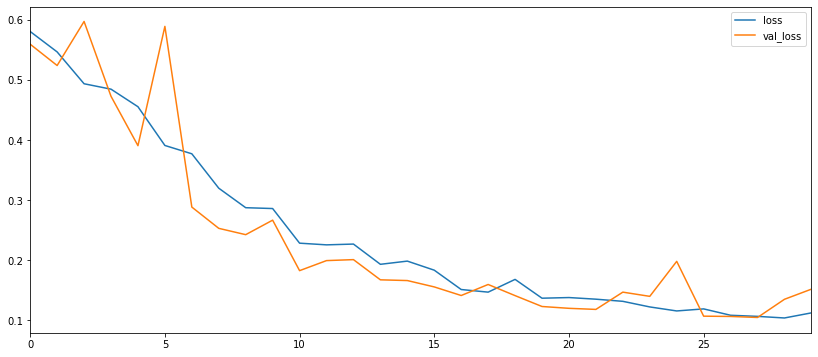

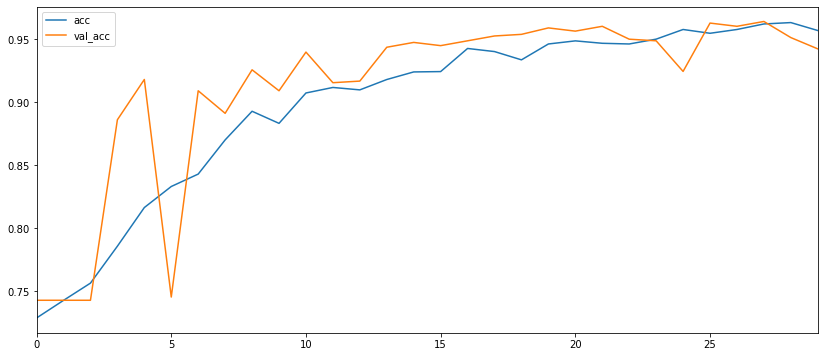

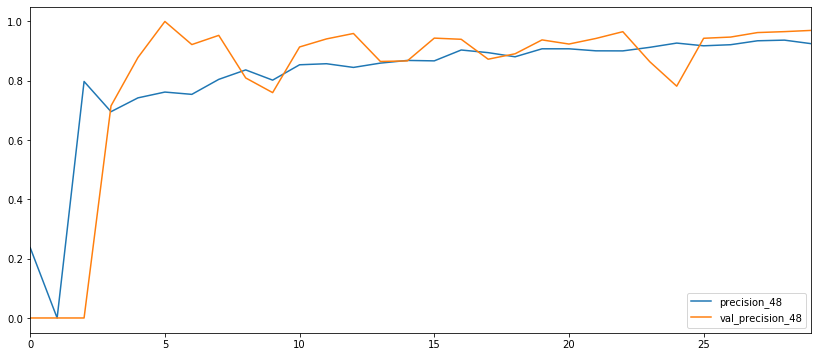

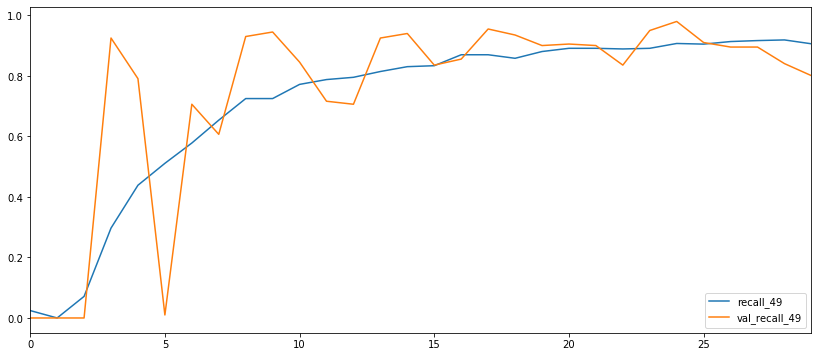

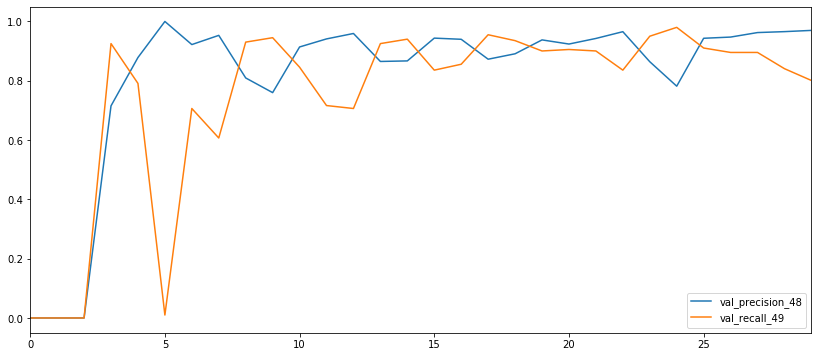

In [223]:
results(history, conv_model)

In [224]:
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/conv_models_2/{epoch:02d}.h5')
cb = [es, mc]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])

Epoch 1/30
37/37 [==============================] - 43s 1s/step - loss: 0.6435 - acc: 0.6795 - precision_49: 0.1700 - recall_50: 0.0888 - val_loss: 0.5767 - val_acc: 0.7430 - val_precision_49: 0.0000e+00 - val_recall_50: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 41s 1s/step - loss: 0.5731 - acc: 0.7453 - precision_49: 0.0000e+00 - recall_50: 0.0000e+00 - val_loss: 0.5705 - val_acc: 0.7430 - val_precision_49: 0.0000e+00 - val_recall_50: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 0.5689 - acc: 0.7425 - precision_49: 0.0000e+00 - recall_50: 0.0000e+00 - val_loss: 0.5647 - val_acc: 0.7430 - val_precision_49: 0.0000e+00 - val_recall_50: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 40s 1s/step - loss: 0.5463 - acc: 0.7589 - precision_49: 0.0000e+00 - recall_50: 0.0000e+00 - val_loss: 0.5636 - val_acc: 0.7430 - val_precision_49: 0.0000e+00 - val_recall_50: 0.0000e+00
Epoch 5/30
37/37 [==============================

25/25 [==============================] - 2s 76ms/step - loss: 0.1210 - acc: 0.9591 - precision_49: 0.9568 - recall_50: 0.8806
[0.12096599489450455, 0.9590792655944824, 0.9567567706108093, 0.8805969953536987]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[573   8]
 [ 24 177]]
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97       581
   Pneumonia       0.96      0.88      0.92       201

    accuracy                           0.96       782
   macro avg       0.96      0.93      0.94       782
weighted avg       0.96      0.96      0.96       782



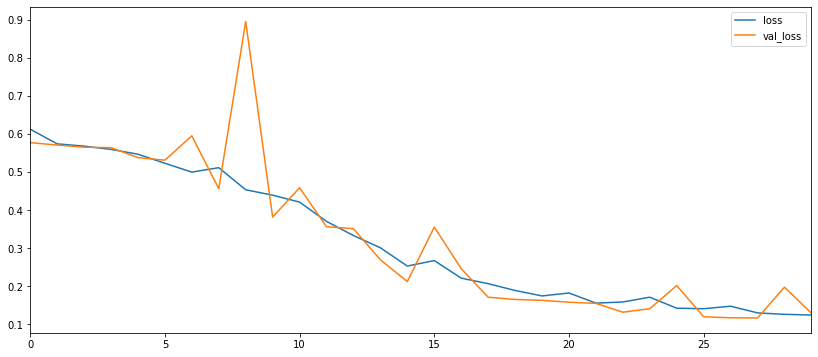

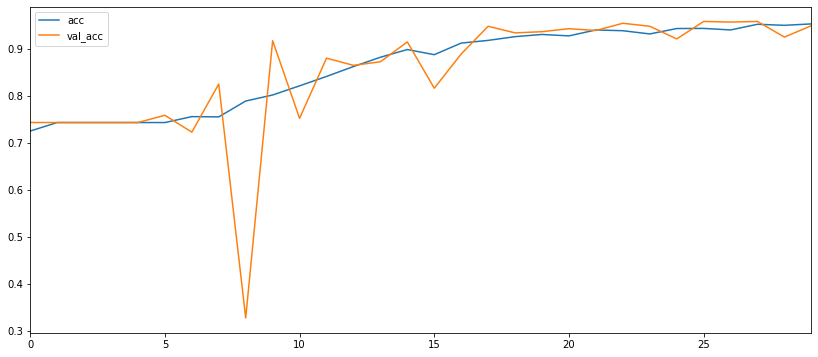

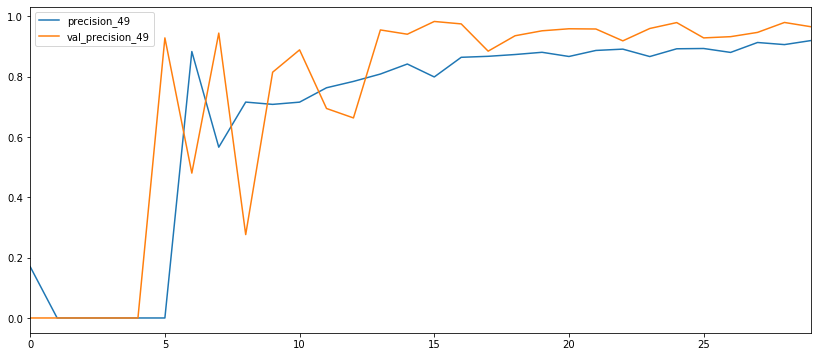

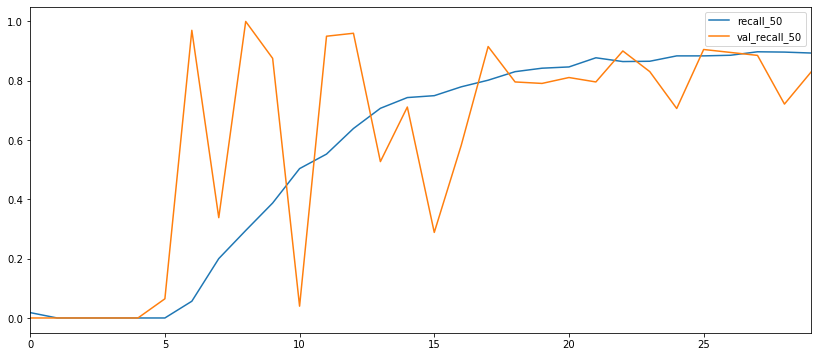

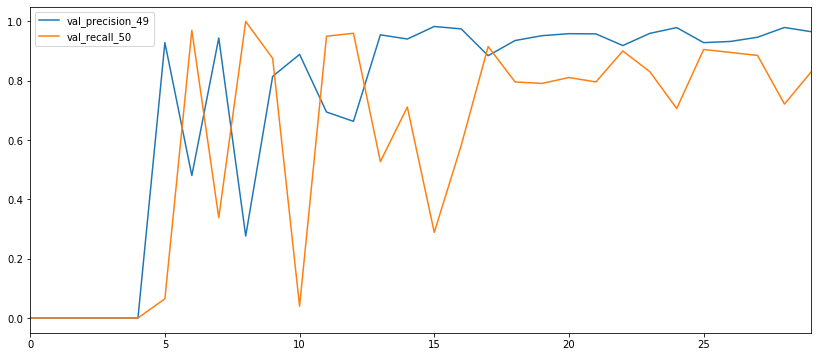

In [225]:
results(history, conv_model)

In [255]:
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Conv2D(256, (4, 4), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(512, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/conv_models_3/{epoch:02d}.h5')
cb = [es, mc]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])

Epoch 1/30
37/37 [==============================] - 49s 1s/step - loss: 0.6757 - acc: 0.7204 - precision_70: 0.2143 - recall_71: 0.0412 - val_loss: 0.6321 - val_acc: 0.7430 - val_precision_70: 0.0000e+00 - val_recall_71: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 44s 1s/step - loss: 0.6173 - acc: 0.7463 - precision_70: 0.0000e+00 - recall_71: 0.0000e+00 - val_loss: 0.5820 - val_acc: 0.7430 - val_precision_70: 0.0000e+00 - val_recall_71: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 44s 1s/step - loss: 0.5703 - acc: 0.7516 - precision_70: 0.0000e+00 - recall_71: 0.0000e+00 - val_loss: 0.5724 - val_acc: 0.7430 - val_precision_70: 0.0000e+00 - val_recall_71: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 44s 1s/step - loss: 0.5864 - acc: 0.7289 - precision_70: 0.0000e+00 - recall_71: 0.0000e+00 - val_loss: 0.5707 - val_acc: 0.7430 - val_precision_70: 0.0000e+00 - val_recall_71: 0.0000e+00
Epoch 5/30
37/37 [==============================

25/25 [==============================] - 2s 79ms/step - loss: 0.2067 - acc: 0.9118 - precision_70: 0.8300 - recall_71: 0.8259
[0.2067471444606781, 0.9117646813392639, 0.8299999833106995, 0.8258706331253052]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[547  34]
 [ 35 166]]
              precision    recall  f1-score   support

      Normal       0.94      0.94      0.94       581
   Pneumonia       0.83      0.83      0.83       201

    accuracy                           0.91       782
   macro avg       0.88      0.88      0.88       782
weighted avg       0.91      0.91      0.91       782



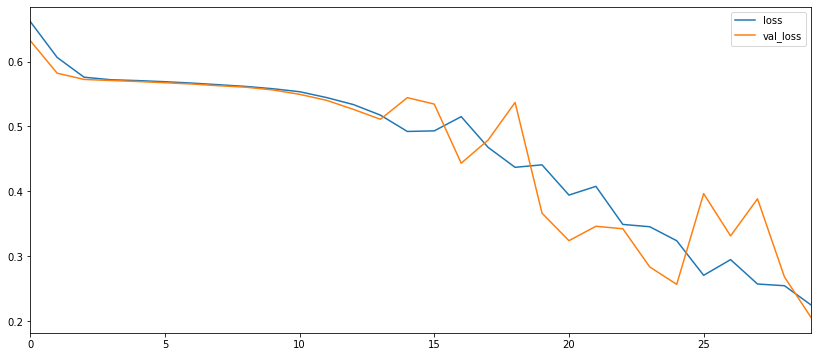

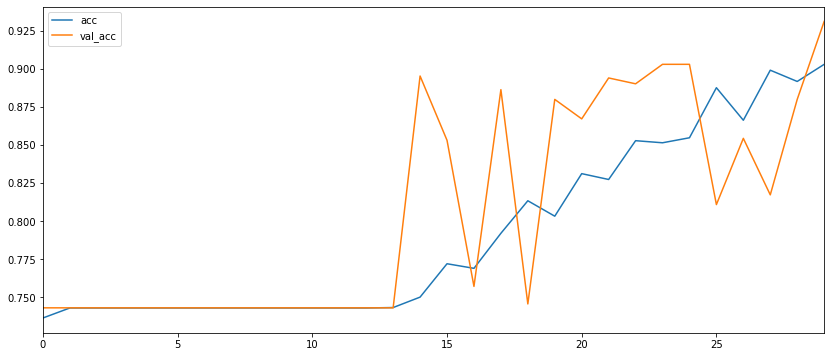

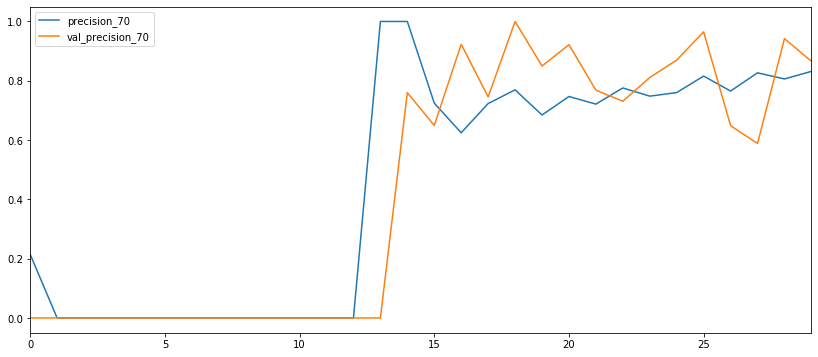

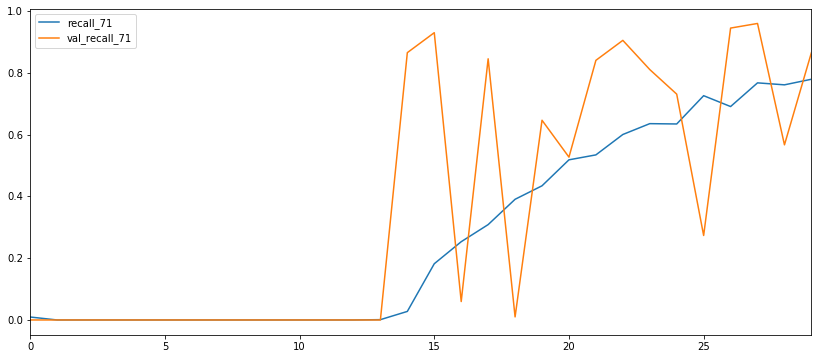

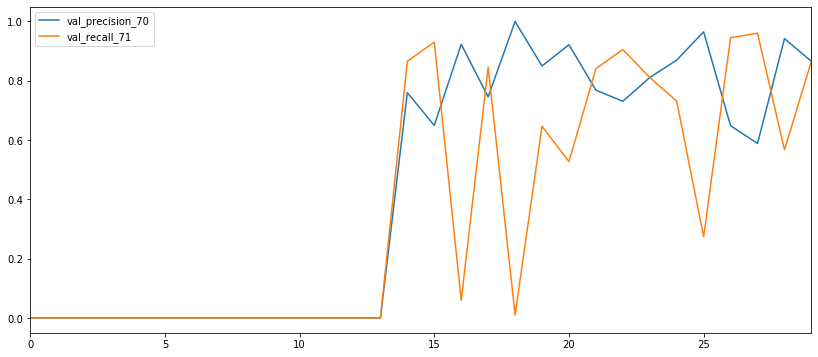

In [256]:
results(history, conv_model)

### Dilated CNN

In [257]:
dil_conv_model = Sequential()
dil_conv_model.add(Conv2D(32, (3, 3), activation='relu', dilation_rate=2, input_shape=(128, 128, 3), ))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2,2))
dil_conv_model.add(Flatten())
dil_conv_model.add(Dense(256, 'relu'))
dil_conv_model.add(Dense(1, 'sigmoid'))

dil_conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/dil_conv_models_1/{epoch:02d}.h5')
cb = [es, mc]
history = dil_conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])

Epoch 1/30
37/37 [==============================] - 76s 2s/step - loss: 0.6422 - acc: 0.7452 - precision_71: 0.0000e+00 - recall_72: 0.0000e+00 - val_loss: 0.5711 - val_acc: 0.7430 - val_precision_71: 0.0000e+00 - val_recall_72: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 71s 2s/step - loss: 0.5745 - acc: 0.7368 - precision_71: 0.0000e+00 - recall_72: 0.0000e+00 - val_loss: 0.5655 - val_acc: 0.7430 - val_precision_71: 0.0000e+00 - val_recall_72: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 71s 2s/step - loss: 0.5779 - acc: 0.7299 - precision_71: 0.0000e+00 - recall_72: 0.0000e+00 - val_loss: 0.5614 - val_acc: 0.7430 - val_precision_71: 0.0000e+00 - val_recall_72: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 79s 2s/step - loss: 0.5608 - acc: 0.7415 - precision_71: 0.0000e+00 - recall_72: 0.0000e+00 - val_loss: 0.5548 - val_acc: 0.7430 - val_precision_71: 0.0000e+00 - val_recall_72: 0.0000e+00
Epoch 5/30
37/37 [======================

25/25 [==============================] - 7s 278ms/step - loss: 0.1515 - acc: 0.9425 - precision_71: 0.8421 - recall_72: 0.9552
[0.15150588750839233, 0.9424552321434021, 0.8421052694320679, 0.9552238583564758]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[545  36]
 [  9 192]]
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96       581
   Pneumonia       0.84      0.96      0.90       201

    accuracy                           0.94       782
   macro avg       0.91      0.95      0.93       782
weighted avg       0.95      0.94      0.94       782



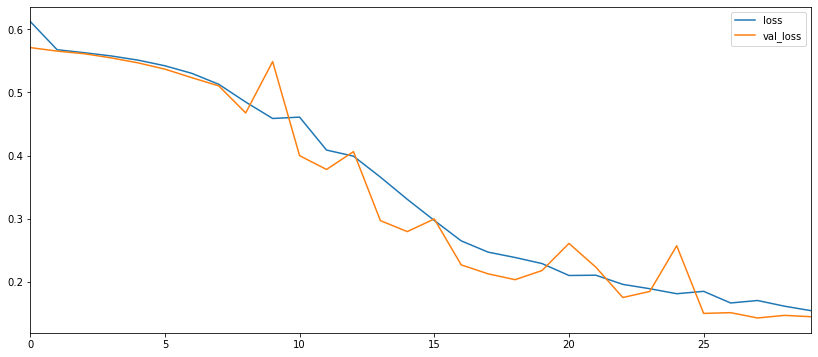

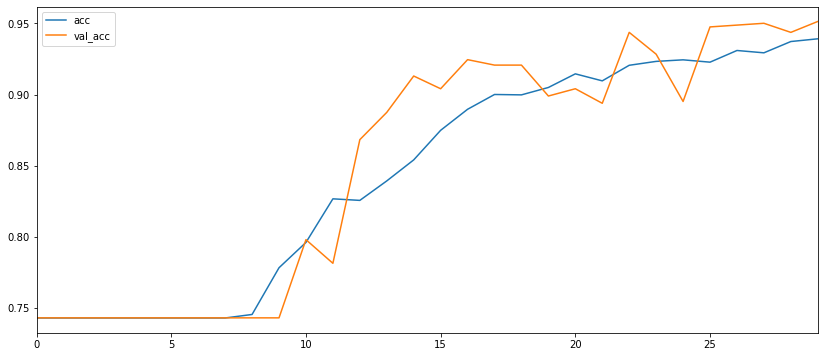

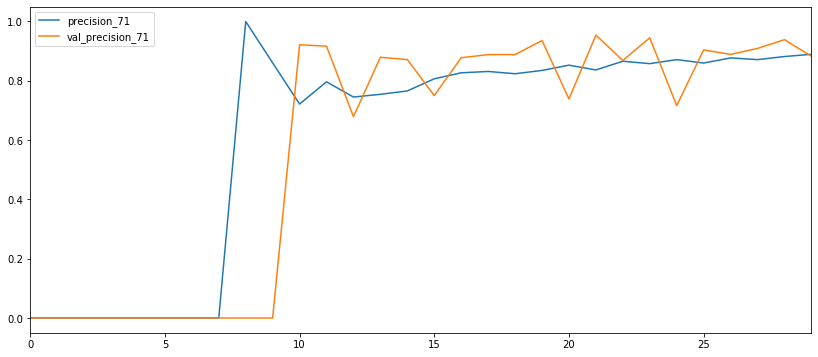

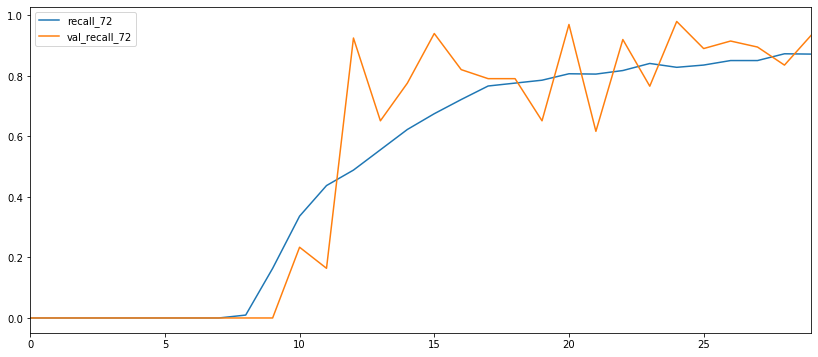

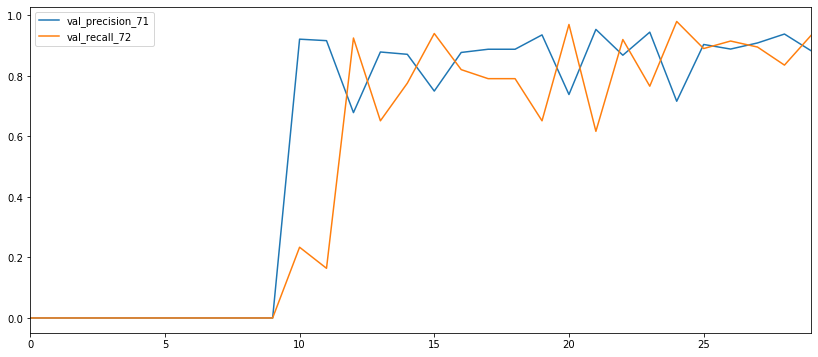

In [258]:
results(history, dil_conv_model)

In [259]:
dil_conv_model = Sequential()
dil_conv_model.add(Conv2D(32, (3, 3), activation='relu', dilation_rate=2, input_shape=(128, 128, 3)))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2,2))
dil_conv_model.add(Flatten())
dil_conv_model.add(Dense(256, 'relu'))
dil_conv_model.add(Dense(1, 'sigmoid'))

dil_conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/dil_conv_models_2/{epoch:02d}.h5')
cb = [es, mc]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])

Epoch 1/30
37/37 [==============================] - 45s 1s/step - loss: 0.2302 - acc: 0.9012 - precision_70: 0.8183 - recall_71: 0.7913 - val_loss: 0.1970 - val_acc: 0.9335 - val_precision_70: 0.8744 - val_recall_71: 0.8657
Epoch 2/30
37/37 [==============================] - 44s 1s/step - loss: 0.2180 - acc: 0.9107 - precision_70: 0.8350 - recall_71: 0.8136 - val_loss: 0.1991 - val_acc: 0.9309 - val_precision_70: 0.8517 - val_recall_71: 0.8856
Epoch 3/30
37/37 [==============================] - 44s 1s/step - loss: 0.2172 - acc: 0.9129 - precision_70: 0.8477 - recall_71: 0.8062 - val_loss: 0.2049 - val_acc: 0.9233 - val_precision_70: 0.8133 - val_recall_71: 0.9104
Epoch 4/30
37/37 [==============================] - 44s 1s/step - loss: 0.2259 - acc: 0.9042 - precision_70: 0.8219 - recall_71: 0.8009 - val_loss: 0.1897 - val_acc: 0.9271 - val_precision_70: 0.9235 - val_recall_71: 0.7811
Epoch 5/30
37/37 [==============================] - 44s 1s/step - loss: 0.2097 - acc: 0.9157 - precision

25/25 [==============================] - 11s 335ms/step - loss: 0.6679 - acc: 0.7182 - precision_72: 0.0000e+00 - recall_73: 0.0000e+00
[0.6650438904762268, 0.7429667711257935, 0.0, 0.0]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[581   0]
 [201   0]]
              precision    recall  f1-score   support

      Normal       0.74      1.00      0.85       581
   Pneumonia       0.00      0.00      0.00       201

    accuracy                           0.74       782
   macro avg       0.37      0.50      0.43       782
weighted avg       0.55      0.74      0.63       782



C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


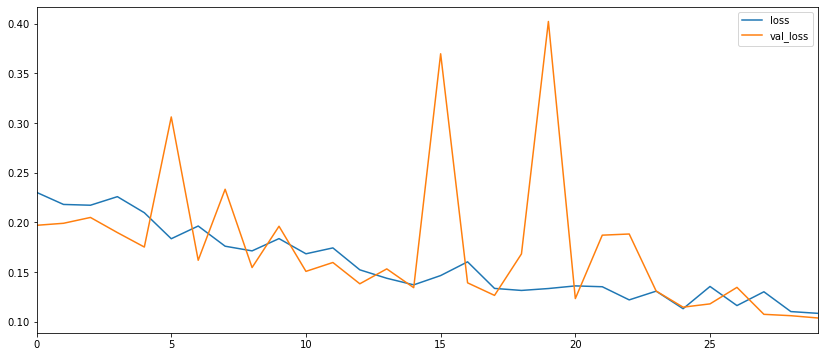

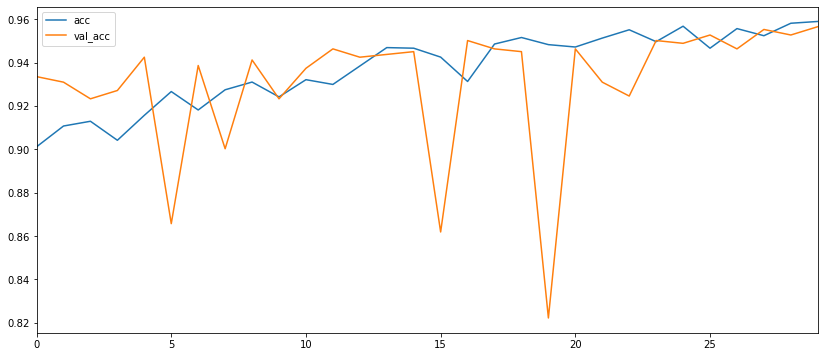

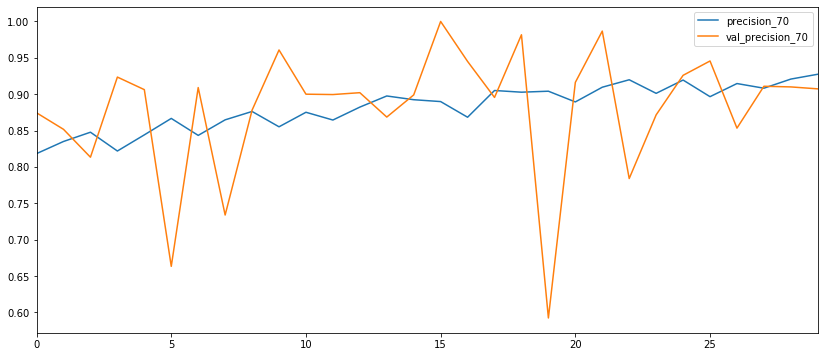

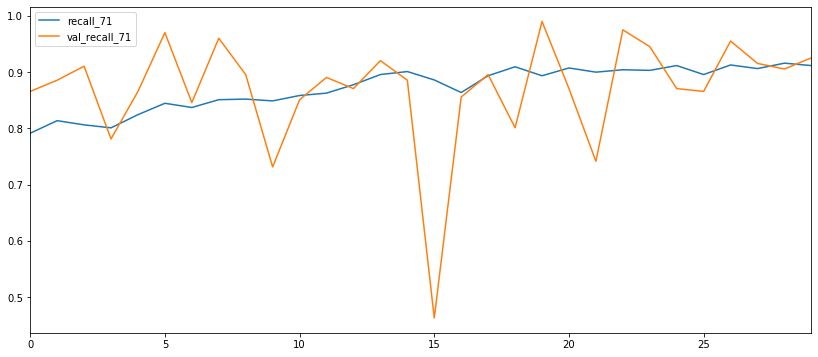

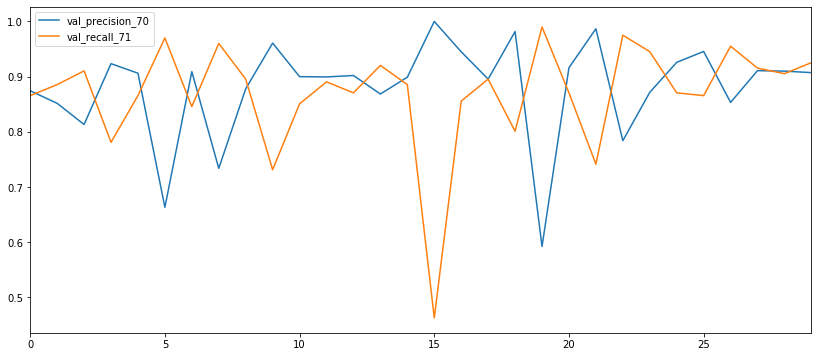

In [260]:
results(history, dil_conv_model)

In [261]:
dil_conv_model = Sequential()
dil_conv_model.add(Conv2D(32, (3, 3), activation='relu', dilation_rate=2, input_shape=(128, 128, 3)))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(Conv2D(256, (4, 4), activation='relu', dilation_rate=2))
dil_conv_model.add(Flatten())
dil_conv_model.add(Dense(256, 'relu'))
dil_conv_model.add(Dense(1, 'sigmoid'))

dil_conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/dil_conv_models_3/{epoch:02d}.h5')
cb = [es, mc]
history = dil_conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])

Epoch 1/30
37/37 [==============================] - 129s 3s/step - loss: 0.6571 - acc: 0.7477 - precision_73: 0.0000e+00 - recall_74: 0.0000e+00 - val_loss: 0.5856 - val_acc: 0.7430 - val_precision_73: 0.0000e+00 - val_recall_74: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 117s 3s/step - loss: 0.5809 - acc: 0.7381 - precision_73: 0.0000e+00 - recall_74: 0.0000e+00 - val_loss: 0.5695 - val_acc: 0.7430 - val_precision_73: 0.0000e+00 - val_recall_74: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 104s 3s/step - loss: 0.5626 - acc: 0.7487 - precision_73: 0.0000e+00 - recall_74: 0.0000e+00 - val_loss: 0.5666 - val_acc: 0.7430 - val_precision_73: 0.0000e+00 - val_recall_74: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 123s 3s/step - loss: 0.5717 - acc: 0.7375 - precision_73: 0.0000e+00 - recall_74: 0.0000e+00 - val_loss: 0.5646 - val_acc: 0.7430 - val_precision_73: 0.0000e+00 - val_recall_74: 0.0000e+00
Epoch 5/30
37/37 [==================

25/25 [==============================] - 7s 272ms/step - loss: 0.1569 - acc: 0.9399 - precision_73: 0.8407 - recall_74: 0.9453
[0.15686555206775665, 0.9398977160453796, 0.8407079577445984, 0.9452736377716064]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[545  36]
 [ 11 190]]
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96       581
   Pneumonia       0.84      0.95      0.89       201

    accuracy                           0.94       782
   macro avg       0.91      0.94      0.92       782
weighted avg       0.94      0.94      0.94       782



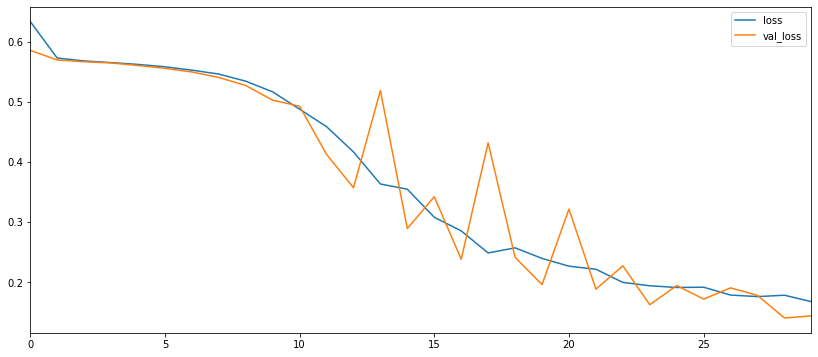

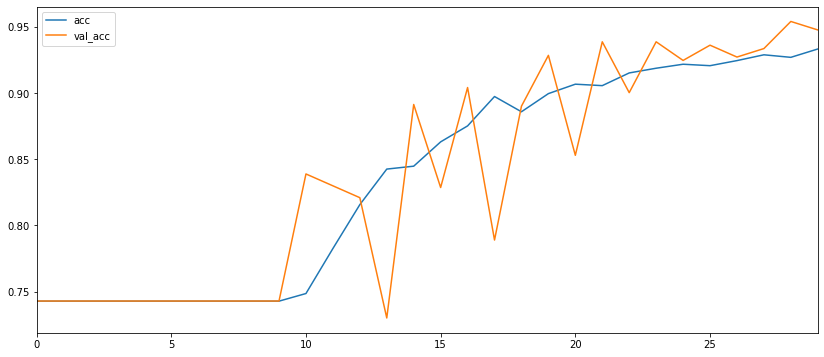

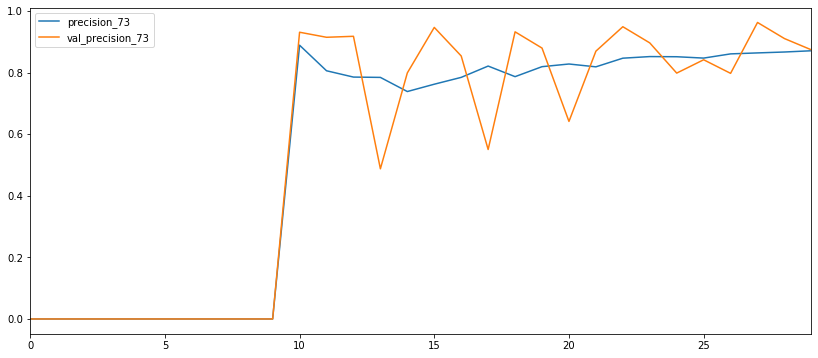

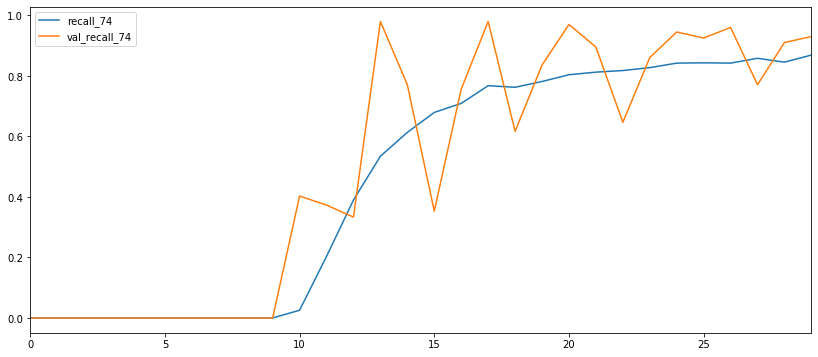

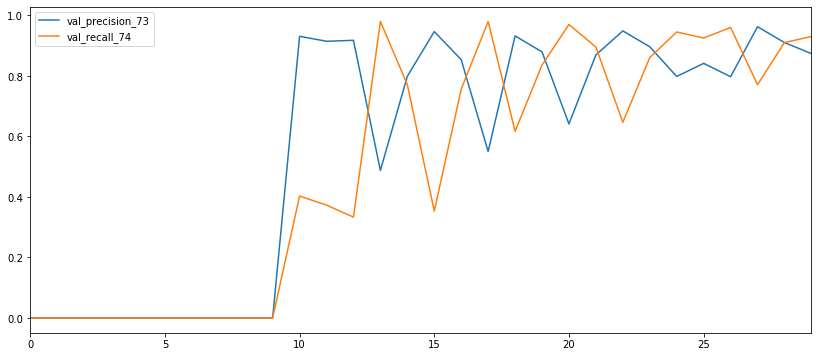

In [262]:
results(history, dil_conv_model)

In [263]:
dil_conv_model = Sequential()
dil_conv_model.add(Conv2D(32, (3, 3), activation='relu', dilation_rate=2, input_shape=(128, 128, 3)))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(128, (3, 3), activation='relu'))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(256, (4, 4), activation='relu'))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Flatten())
dil_conv_model.add(Dense(256, 'relu'))
dil_conv_model.add(Dense(1, 'sigmoid'))

dil_conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/dil_conv_models_4/{epoch:02d}.h5')
cb = [mc]
history = dil_conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])

Epoch 1/30
37/37 [==============================] - 77s 2s/step - loss: 0.6552 - acc: 0.7337 - precision_74: 0.0000e+00 - recall_75: 0.0000e+00 - val_loss: 0.5855 - val_acc: 0.7430 - val_precision_74: 0.0000e+00 - val_recall_75: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 92s 3s/step - loss: 0.5738 - acc: 0.7481 - precision_74: 0.0000e+00 - recall_75: 0.0000e+00 - val_loss: 0.5696 - val_acc: 0.7430 - val_precision_74: 0.0000e+00 - val_recall_75: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 65s 2s/step - loss: 0.5663 - acc: 0.7459 - precision_74: 0.0000e+00 - recall_75: 0.0000e+00 - val_loss: 0.5675 - val_acc: 0.7430 - val_precision_74: 0.0000e+00 - val_recall_75: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 72s 2s/step - loss: 0.5686 - acc: 0.7414 - precision_74: 0.0000e+00 - recall_75: 0.0000e+00 - val_loss: 0.5658 - val_acc: 0.7430 - val_precision_74: 0.0000e+00 - val_recall_75: 0.0000e+00
Epoch 5/30
37/37 [======================

25/25 [==============================] - 7s 267ms/step - loss: 0.2216 - acc: 0.9066 - precision_74: 0.7857 - recall_75: 0.8756
[0.2215917408466339, 0.9066495895385742, 0.7857142686843872, 0.8756219148635864]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[533  48]
 [ 25 176]]
              precision    recall  f1-score   support

      Normal       0.96      0.92      0.94       581
   Pneumonia       0.79      0.88      0.83       201

    accuracy                           0.91       782
   macro avg       0.87      0.90      0.88       782
weighted avg       0.91      0.91      0.91       782



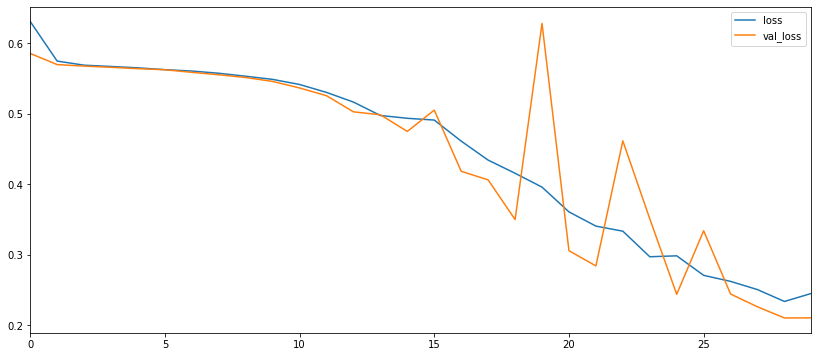

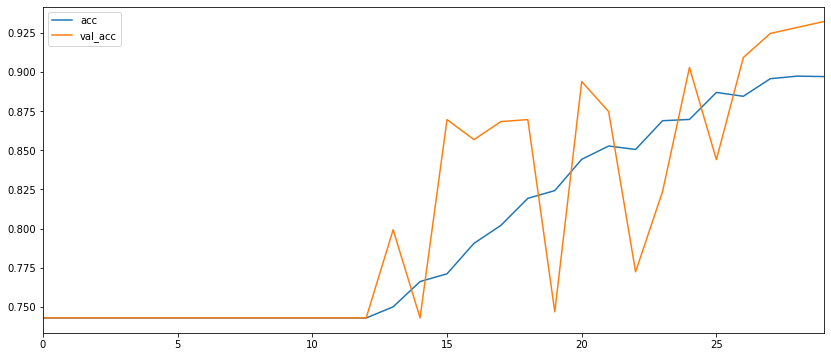

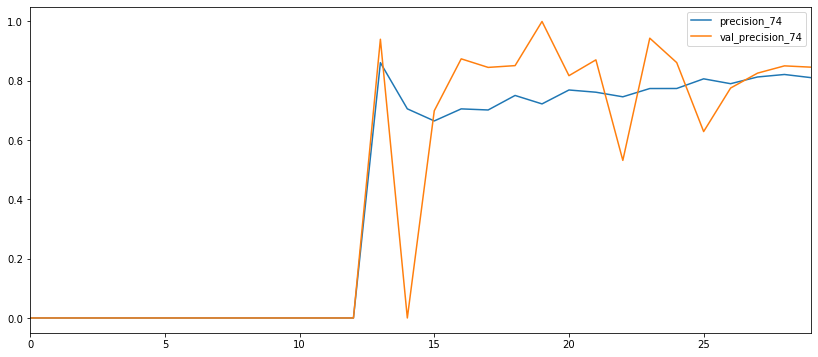

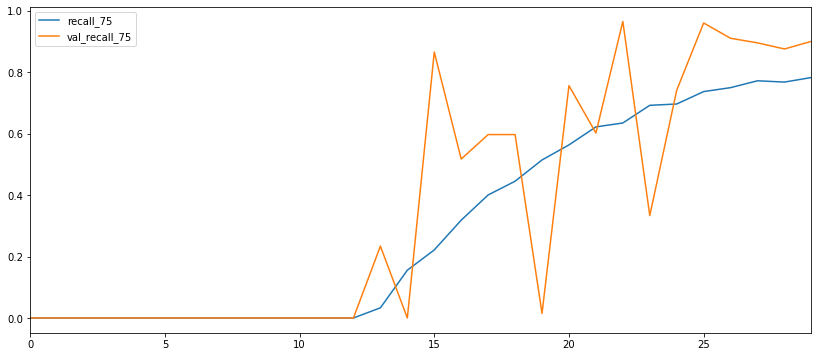

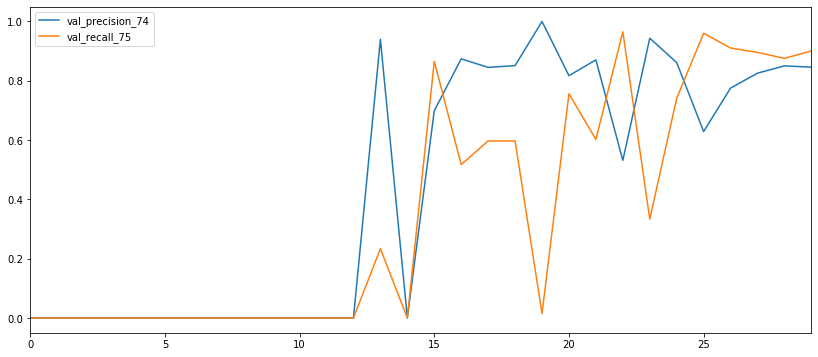

In [264]:
results(history, dil_conv_model)

In [265]:
dil_conv_model = Sequential()
dil_conv_model.add(Conv2D(32, (3, 3), activation='relu', dilation_rate=2, input_shape=(128, 128, 3)))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(128, (3, 3), activation='relu'))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(256, (4, 4), activation='relu'))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Flatten())
dil_conv_model.add(Dense(256, 'relu'))
dil_conv_model.add(Dense(1, 'sigmoid'))

dil_conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/dil_conv_models_5/{epoch:02d}.h5')
cb = [mc]
history = dil_conv_model.fit(train_imgs, train_y, epochs=50, batch_size=50, validation_data=(val_imgs, val_y), callbacks=[cb])

Epoch 1/50
74/74 [==============================] - 367s 5s/step - loss: 0.6116 - acc: 0.6897 - precision_75: 0.2208 - recall_76: 0.1117 - val_loss: 0.5684 - val_acc: 0.7430 - val_precision_75: 0.0000e+00 - val_recall_76: 0.0000e+00
Epoch 2/50
74/74 [==============================] - 325s 4s/step - loss: 0.5588 - acc: 0.7323 - precision_75: 0.3039 - recall_76: 0.0045 - val_loss: 0.7150 - val_acc: 0.7430 - val_precision_75: 0.0000e+00 - val_recall_76: 0.0000e+00
Epoch 3/50
74/74 [==============================] - 335s 4s/step - loss: 0.5100 - acc: 0.7832 - precision_75: 0.7117 - recall_76: 0.2521 - val_loss: 0.4824 - val_acc: 0.7519 - val_precision_75: 0.8889 - val_recall_76: 0.0398
Epoch 4/50
74/74 [==============================] - 333s 4s/step - loss: 0.4191 - acc: 0.8059 - precision_75: 0.6777 - recall_76: 0.4989 - val_loss: 0.3352 - val_acc: 0.8811 - val_precision_75: 0.7015 - val_recall_76: 0.9353
Epoch 5/50
74/74 [==============================] - 319s 4s/step - loss: 0.3210 - ac

25/25 [==============================] - 27s 1s/step - loss: 0.1671 - acc: 0.9450 - precision_75: 0.8376 - recall_76: 0.9751
[0.16711732745170593, 0.9450128078460693, 0.8376068472862244, 0.9751243591308594]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[543  38]
 [  5 196]]
              precision    recall  f1-score   support

      Normal       0.99      0.93      0.96       581
   Pneumonia       0.84      0.98      0.90       201

    accuracy                           0.95       782
   macro avg       0.91      0.95      0.93       782
weighted avg       0.95      0.95      0.95       782



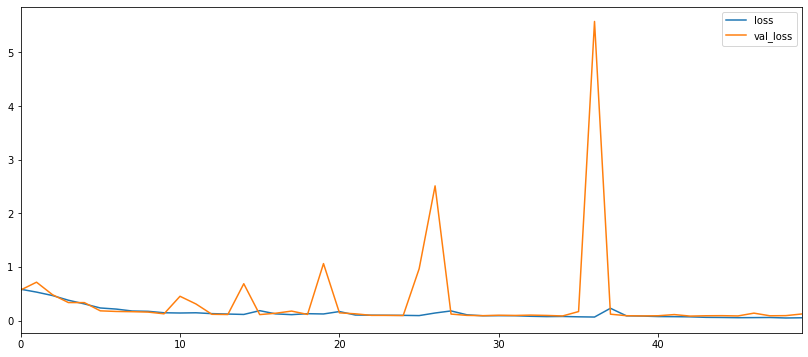

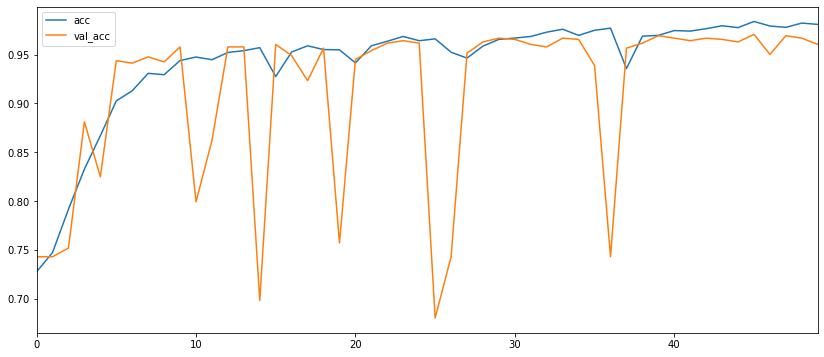

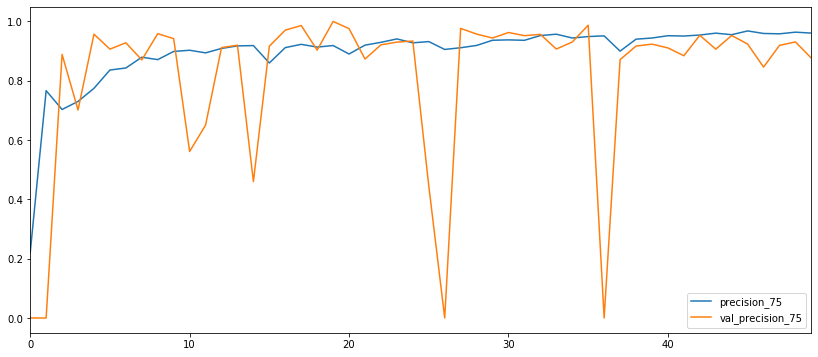

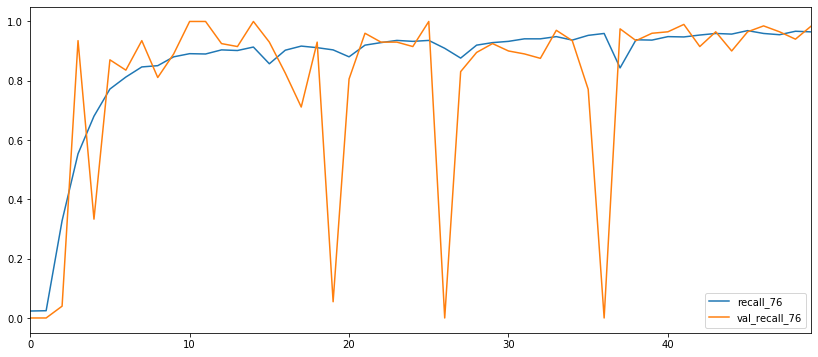

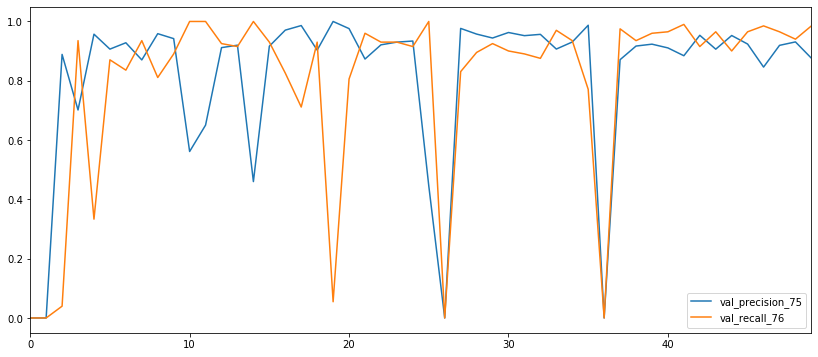

In [266]:
results(history, dil_conv_model)

In [238]:
dil_conv_model = Sequential()
dil_conv_model.add(Conv2D(32, (3, 3), activation='relu', dilation_rate=2, input_shape=(128, 128, 3)))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate=2))
dil_conv_model.add(Conv2D(128, (3, 3), activation='relu'))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Conv2D(256, (4, 4), activation='relu'))
dil_conv_model.add(MaxPooling2D(2, 2))
dil_conv_model.add(Flatten())
dil_conv_model.add(Dense(256, 'relu'))
dil_conv_model.add(Dense(1, 'sigmoid'))

dil_conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/dil_conv_models_6/{epoch:02d}.h5')
cb = [mc]
history = dil_conv_model.fit(train_imgs, train_y, epochs=50, batch_size=50, validation_data=(val_imgs, val_y), callbacks=[cb])

Epoch 1/50
74/74 [==============================] - 543s 7s/step - loss: 0.5745 - acc: 0.7223 - precision_56: 0.3984 - recall_57: 0.0876 - val_loss: 0.6416 - val_acc: 0.7839 - val_precision_56: 0.9706 - val_recall_57: 0.1642
Epoch 2/50
74/74 [==============================] - 532s 7s/step - loss: 0.4990 - acc: 0.7725 - precision_56: 0.6692 - recall_57: 0.1589 - val_loss: 0.2965 - val_acc: 0.8708 - val_precision_56: 0.9386 - val_recall_57: 0.5323
Epoch 3/50
74/74 [==============================] - 530s 7s/step - loss: 0.3748 - acc: 0.8382 - precision_56: 0.7081 - recall_57: 0.6073 - val_loss: 0.9912 - val_acc: 0.5128 - val_precision_56: 0.3454 - val_recall_57: 1.0000
Epoch 4/50
74/74 [==============================] - 531s 7s/step - loss: 0.3151 - acc: 0.8715 - precision_56: 0.7730 - recall_57: 0.7520 - val_loss: 0.1887 - val_acc: 0.9348 - val_precision_56: 0.8440 - val_recall_57: 0.9154
Epoch 5/50
74/74 [==============================] - 530s 7s/step - loss: 0.2231 - acc: 0.9082 - prec

25/25 [==============================] - 39s 1s/step - loss: 0.0921 - acc: 0.9706 - precision_56: 0.9541 - recall_57: 0.9303
[0.09212342649698257, 0.970588207244873, 0.954081654548645, 0.93034827709198]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[572   9]
 [ 14 187]]
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       581
   Pneumonia       0.95      0.93      0.94       201

    accuracy                           0.97       782
   macro avg       0.97      0.96      0.96       782
weighted avg       0.97      0.97      0.97       782



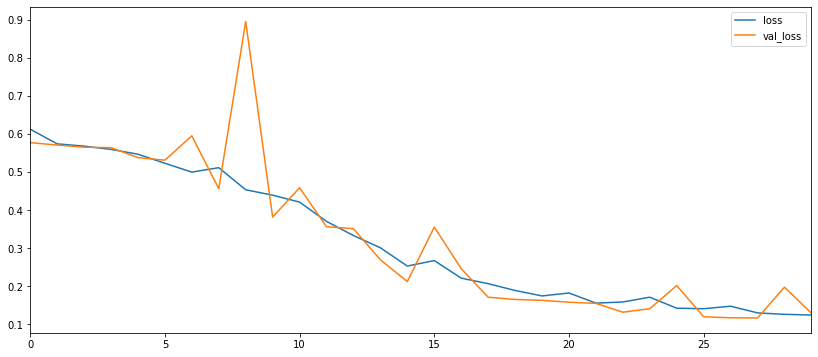

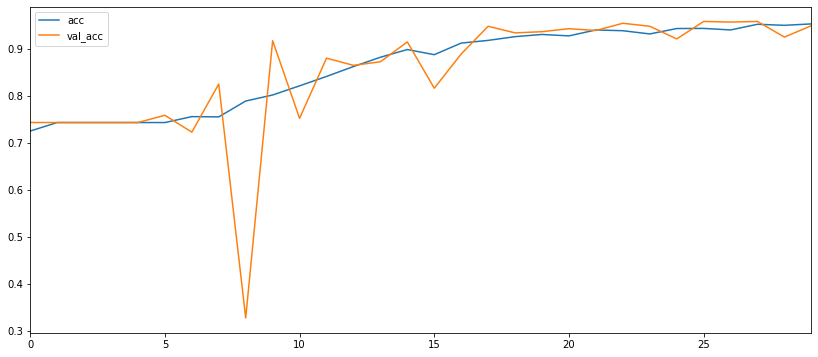

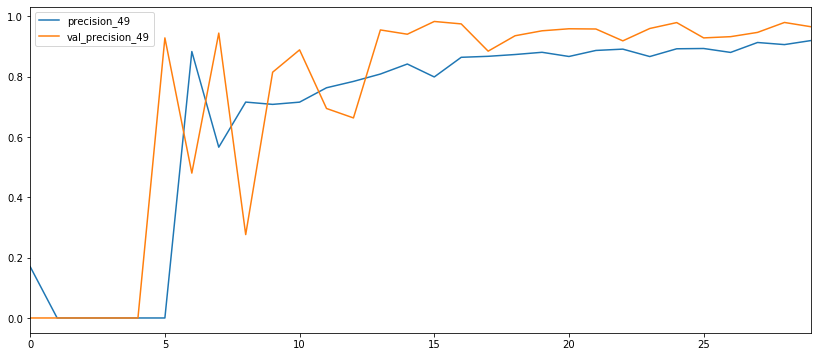

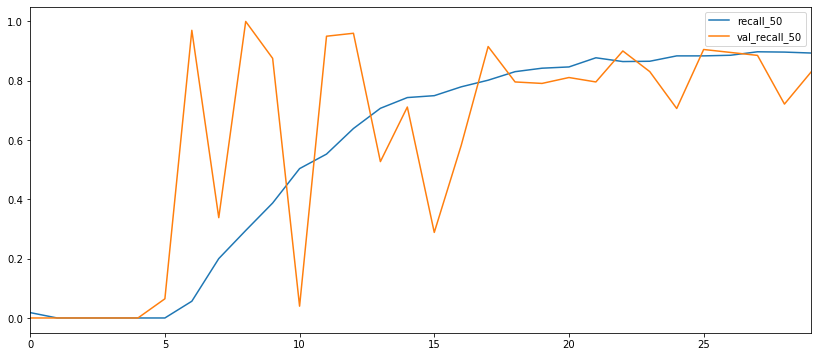

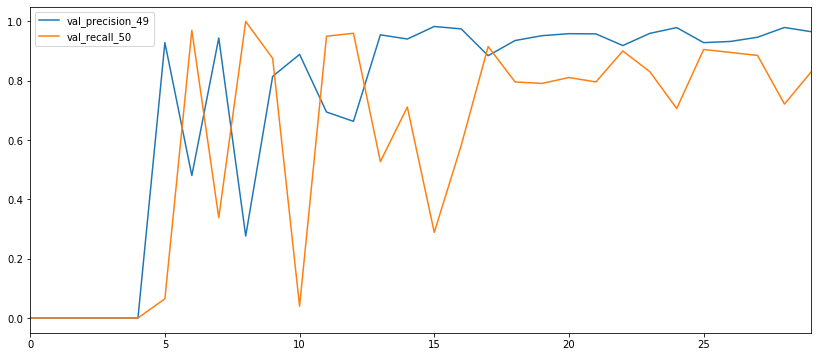

In [239]:
results(history, dil_conv_model)

### Options

#### Activation Function

Epoch 1/30
37/37 [==============================] - 46s 1s/step - loss: 0.6331 - acc: 0.6856 - precision_57: 0.2741 - recall_58: 0.1442 - val_loss: 0.5741 - val_acc: 0.7430 - val_precision_57: 0.0000e+00 - val_recall_58: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 41s 1s/step - loss: 0.5722 - acc: 0.7436 - precision_57: 0.0000e+00 - recall_58: 0.0000e+00 - val_loss: 0.5755 - val_acc: 0.7430 - val_precision_57: 0.0000e+00 - val_recall_58: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 0.5713 - acc: 0.7398 - precision_57: 0.0000e+00 - recall_58: 0.0000e+00 - val_loss: 0.5581 - val_acc: 0.7430 - val_precision_57: 0.0000e+00 - val_recall_58: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 41s 1s/step - loss: 0.5562 - acc: 0.7428 - precision_57: 0.0000e+00 - recall_58: 0.0000e+00 - val_loss: 0.5447 - val_acc: 0.7430 - val_precision_57: 0.0000e+00 - val_recall_58: 0.0000e+00
Epoch 5/30
37/37 [==============================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[577   4]
 [ 42 159]]
              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96       581
   Pneumonia       0.98      0.79      0.87       201

    accuracy                           0.94       782
   macro avg       0.95      0.89      0.92       782
weighted avg       0.94      0.94      0.94       782



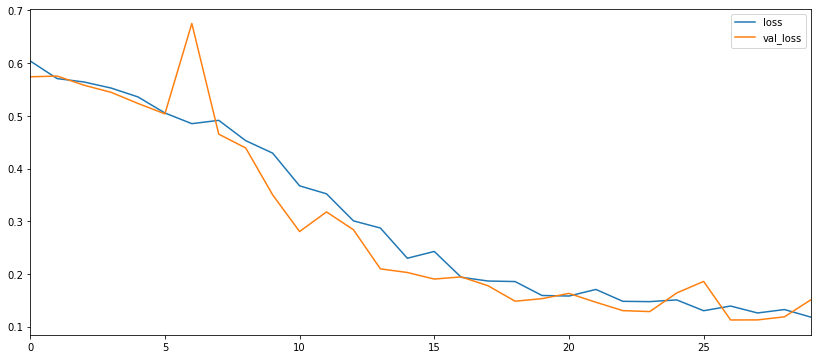

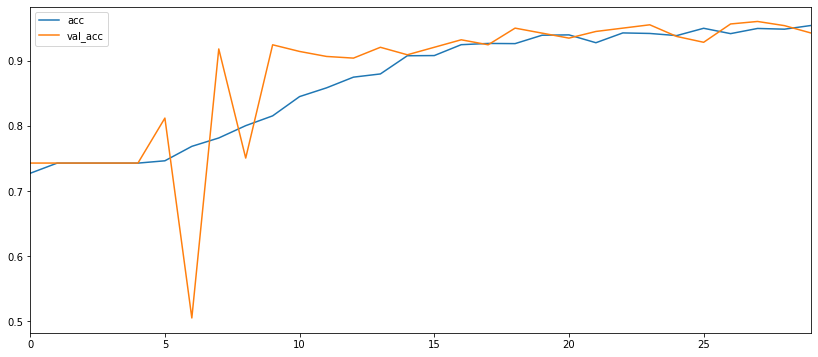

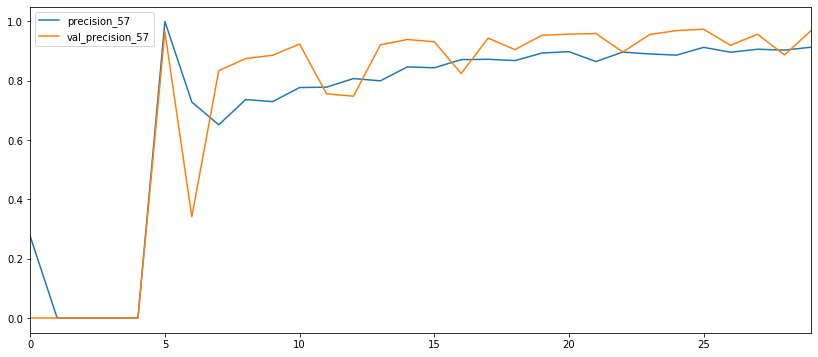

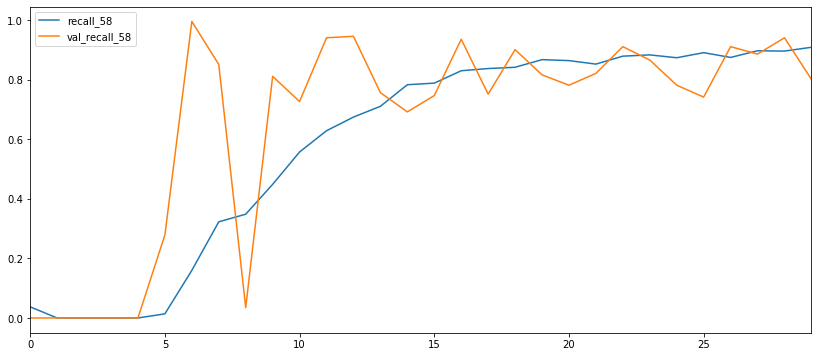

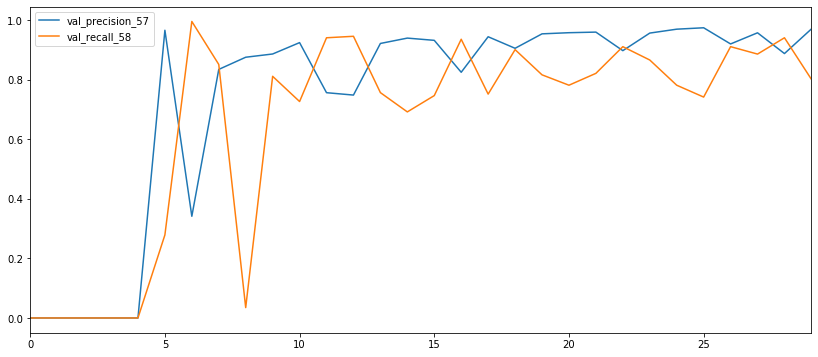

In [240]:
#Original: relu
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 49s 1s/step - loss: 0.6853 - acc: 0.6966 - precision_58: 0.3752 - recall_59: 0.1944 - val_loss: 0.5990 - val_acc: 0.6381 - val_precision_58: 0.4149 - val_recall_59: 0.9950
Epoch 2/30
37/37 [==============================] - 43s 1s/step - loss: 0.3899 - acc: 0.8203 - precision_58: 0.6979 - recall_59: 0.5138 - val_loss: 0.2679 - val_acc: 0.9220 - val_precision_58: 0.9268 - val_recall_59: 0.7562
Epoch 3/30
37/37 [==============================] - 43s 1s/step - loss: 0.2899 - acc: 0.8776 - precision_58: 0.8261 - recall_59: 0.6575 - val_loss: 0.2488 - val_acc: 0.9425 - val_precision_58: 0.8578 - val_recall_59: 0.9303
Epoch 4/30
37/37 [==============================] - 44s 1s/step - loss: 0.2411 - acc: 0.9103 - precision_58: 0.8654 - recall_59: 0.7720 - val_loss: 0.2263 - val_acc: 0.8977 - val_precision_58: 0.9481 - val_recall_59: 0.6368
Epoch 5/30
37/37 [==============================] - 43s 1s/step - loss: 0.2287 - acc: 0.9089 - precision

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[563  18]
 [  4 197]]
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       581
   Pneumonia       0.92      0.98      0.95       201

    accuracy                           0.97       782
   macro avg       0.95      0.97      0.96       782
weighted avg       0.97      0.97      0.97       782



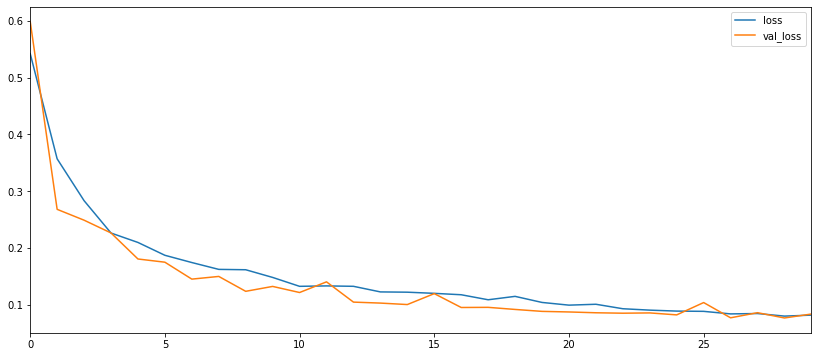

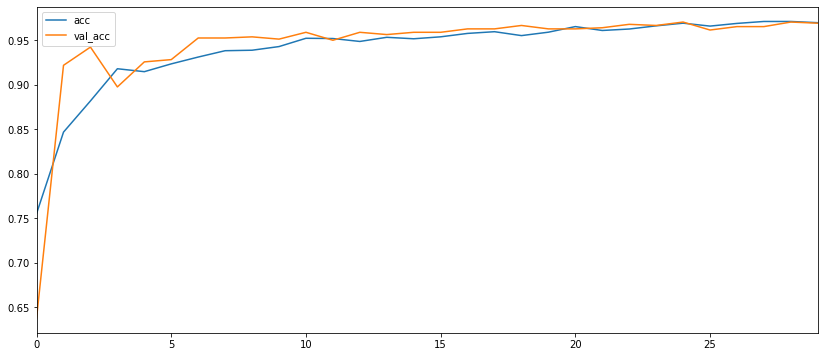

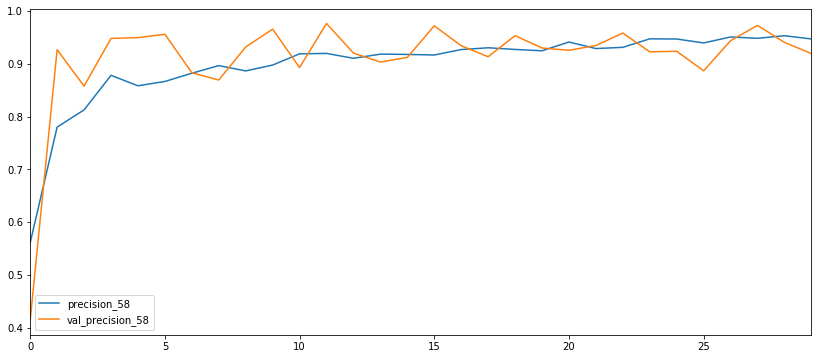

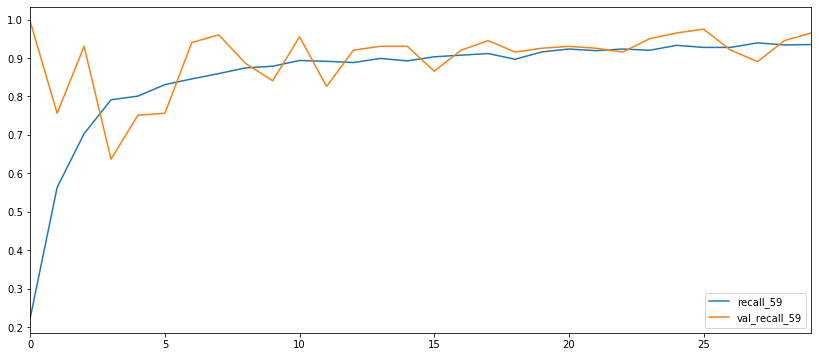

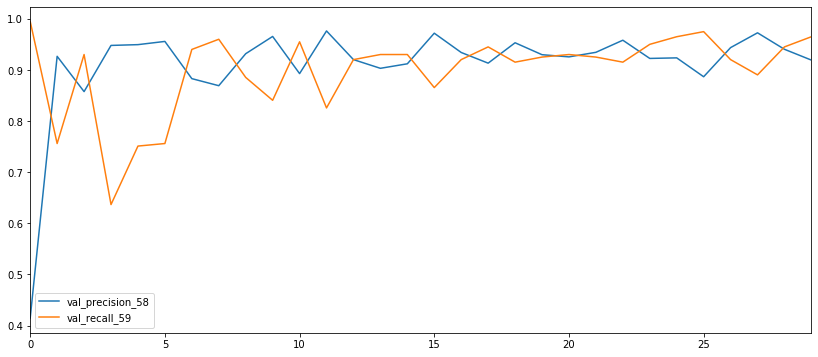

In [241]:
#selu
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='selu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='selu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='selu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='selu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'selu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Better results with 'selu', will use this in final model

#### Optimizer

Epoch 1/30
37/37 [==============================] - 51s 1s/step - loss: 0.6463 - acc: 0.6826 - precision_60: 0.2782 - recall_61: 0.1244 - val_loss: 0.5751 - val_acc: 0.7430 - val_precision_60: 0.0000e+00 - val_recall_61: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 43s 1s/step - loss: 0.5703 - acc: 0.7453 - precision_60: 0.0000e+00 - recall_61: 0.0000e+00 - val_loss: 0.5685 - val_acc: 0.7430 - val_precision_60: 0.0000e+00 - val_recall_61: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 0.5647 - acc: 0.7439 - precision_60: 0.0000e+00 - recall_61: 0.0000e+00 - val_loss: 0.5621 - val_acc: 0.7430 - val_precision_60: 0.0000e+00 - val_recall_61: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 46s 1s/step - loss: 0.5638 - acc: 0.7385 - precision_60: 0.0000e+00 - recall_61: 0.0000e+00 - val_loss: 0.5580 - val_acc: 0.7430 - val_precision_60: 0.0000e+00 - val_recall_61: 0.0000e+00
Epoch 5/30
37/37 [==============================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[555  26]
 [  9 192]]
              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97       581
   Pneumonia       0.88      0.96      0.92       201

    accuracy                           0.96       782
   macro avg       0.93      0.96      0.94       782
weighted avg       0.96      0.96      0.96       782



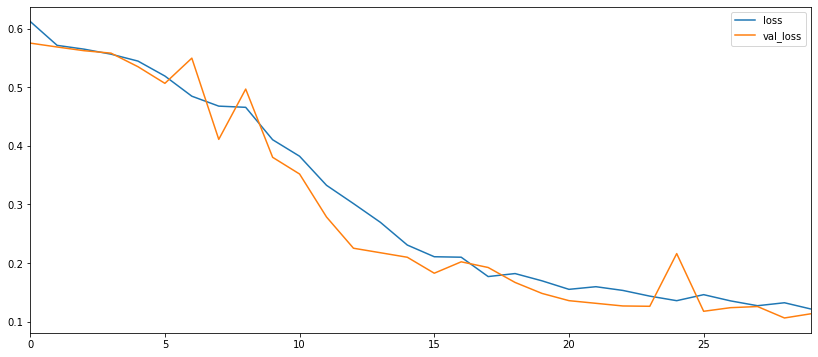

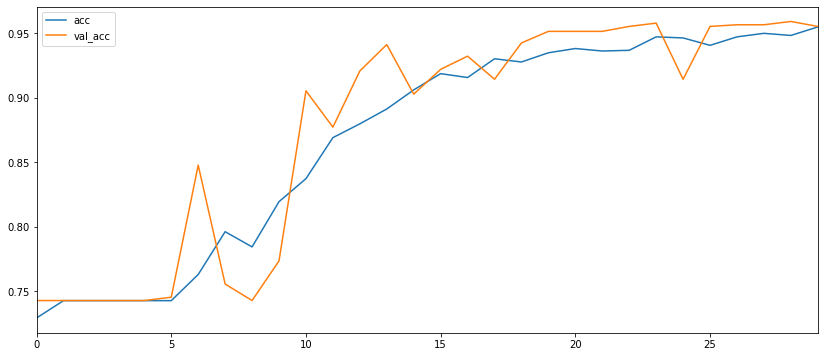

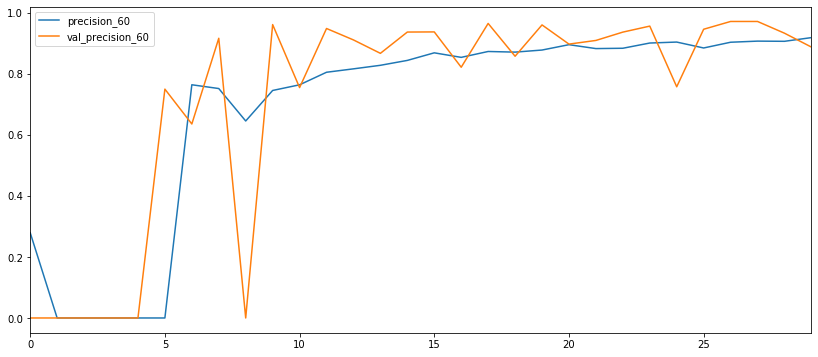

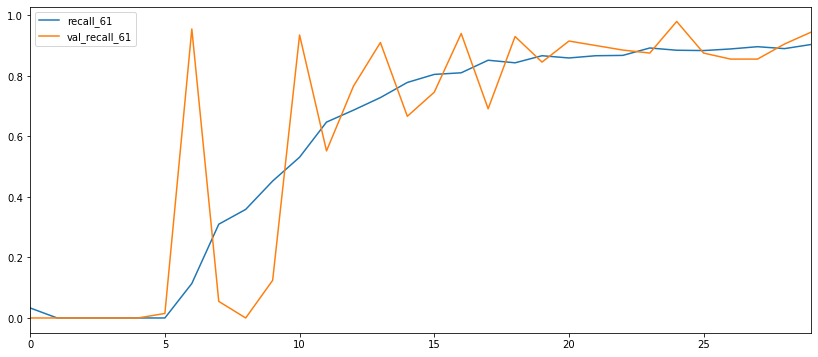

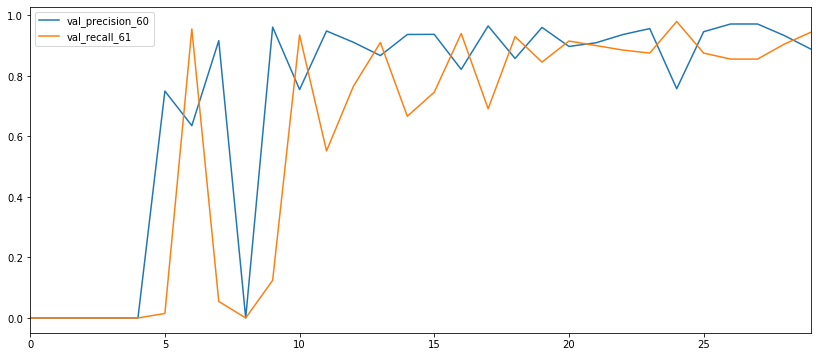

In [243]:
#Original: sgd
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 47s 1s/step - loss: 0.7111 - acc: 0.6623 - precision_78: 0.3397 - recall_79: 0.2666 - val_loss: 0.4712 - val_acc: 0.7852 - val_precision_78: 0.9459 - val_recall_79: 0.1741
Epoch 2/30
37/37 [==============================] - 41s 1s/step - loss: 0.3829 - acc: 0.8433 - precision_78: 0.7812 - recall_79: 0.5689 - val_loss: 0.1808 - val_acc: 0.9309 - val_precision_78: 0.8551 - val_recall_79: 0.8806
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 0.2038 - acc: 0.9194 - precision_78: 0.8536 - recall_79: 0.8284 - val_loss: 0.2076 - val_acc: 0.9386 - val_precision_78: 0.9091 - val_recall_79: 0.8458
Epoch 4/30
37/37 [==============================] - 41s 1s/step - loss: 0.1735 - acc: 0.9361 - precision_78: 0.8923 - recall_79: 0.8473 - val_loss: 0.1071 - val_acc: 0.9655 - val_precision_78: 0.9350 - val_recall_79: 0.9303
Epoch 5/30
37/37 [==============================] - 41s 1s/step - loss: 0.1441 - acc: 0.9486 - precision

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[570  11]
 [  7 194]]
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       581
   Pneumonia       0.95      0.97      0.96       201

    accuracy                           0.98       782
   macro avg       0.97      0.97      0.97       782
weighted avg       0.98      0.98      0.98       782



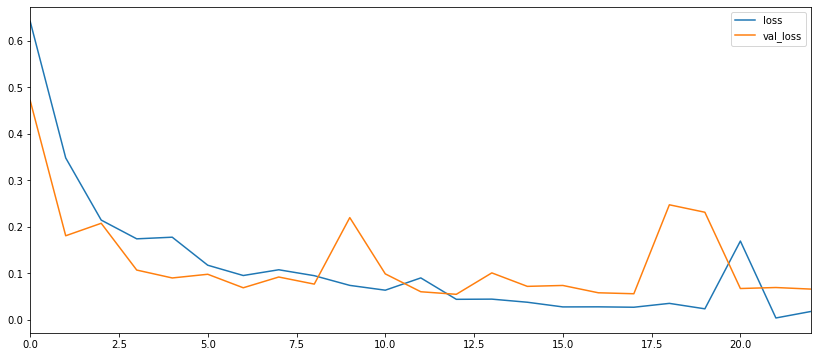

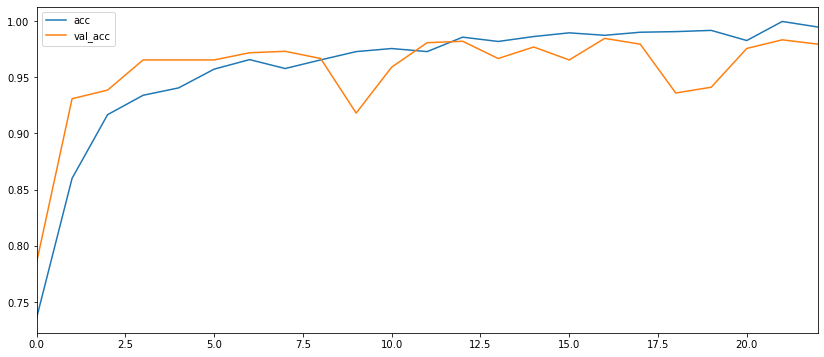

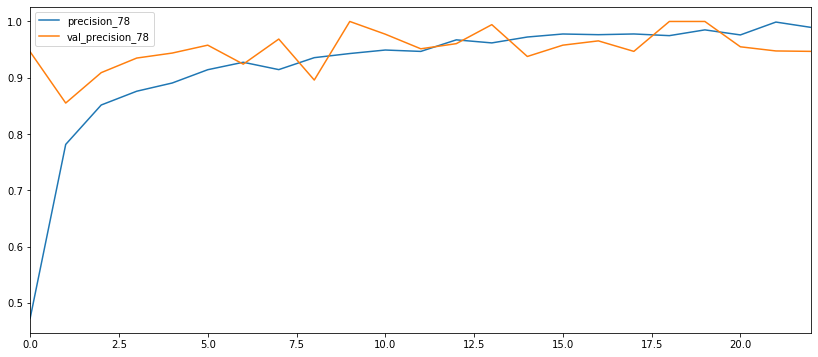

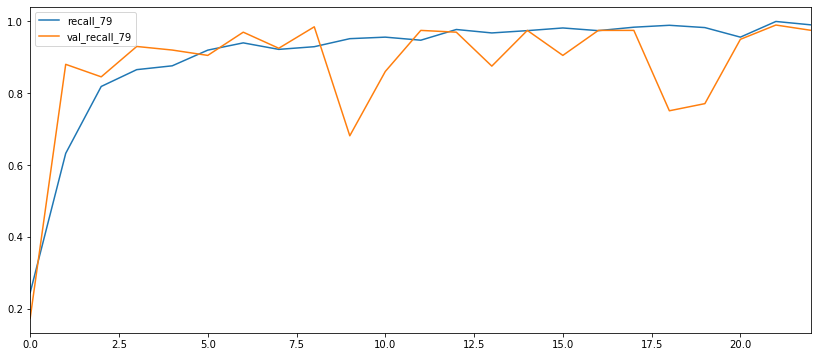

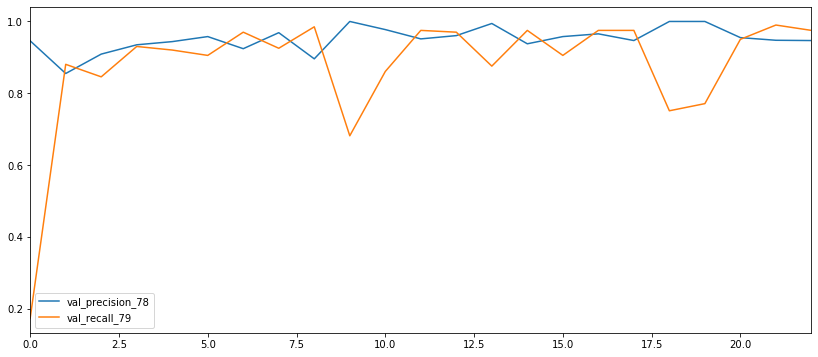

In [275]:
#RMSprop
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 46s 1s/step - loss: 0.6004 - acc: 0.7037 - precision_79: 0.3147 - recall_80: 0.1307 - val_loss: 0.4118 - val_acc: 0.7545 - val_precision_79: 0.9091 - val_recall_80: 0.0498
Epoch 2/30
37/37 [==============================] - 41s 1s/step - loss: 0.3341 - acc: 0.8404 - precision_79: 0.7877 - recall_80: 0.5572 - val_loss: 0.1423 - val_acc: 0.9514 - val_precision_79: 0.9605 - val_recall_80: 0.8458
Epoch 3/30
37/37 [==============================] - 42s 1s/step - loss: 0.1557 - acc: 0.9415 - precision_79: 0.9073 - recall_80: 0.8728 - val_loss: 0.0939 - val_acc: 0.9629 - val_precision_79: 0.9624 - val_recall_80: 0.8905
Epoch 4/30
37/37 [==============================] - 42s 1s/step - loss: 0.1050 - acc: 0.9639 - precision_79: 0.9186 - recall_80: 0.9386 - val_loss: 0.1458 - val_acc: 0.9437 - val_precision_79: 0.9876 - val_recall_80: 0.7910
Epoch 5/30
37/37 [==============================] - 41s 1s/step - loss: 0.1240 - acc: 0.9494 - precision

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[569  12]
 [  6 195]]
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98       581
   Pneumonia       0.94      0.97      0.96       201

    accuracy                           0.98       782
   macro avg       0.97      0.97      0.97       782
weighted avg       0.98      0.98      0.98       782



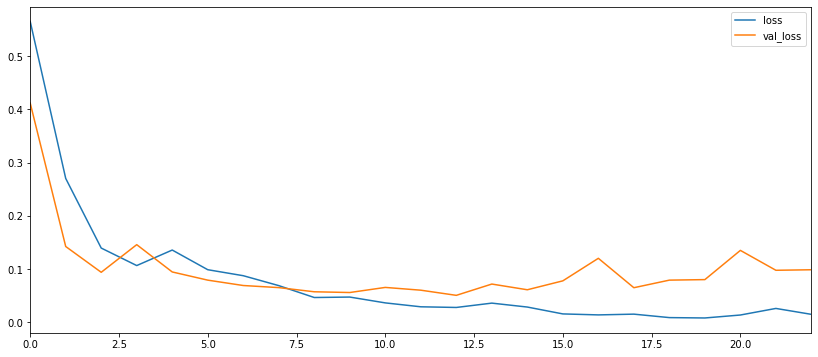

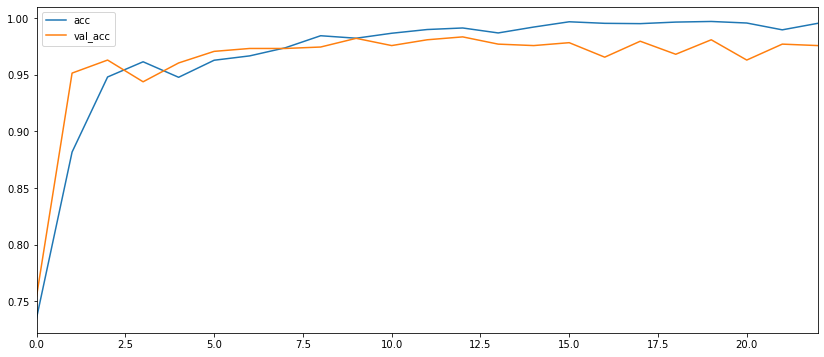

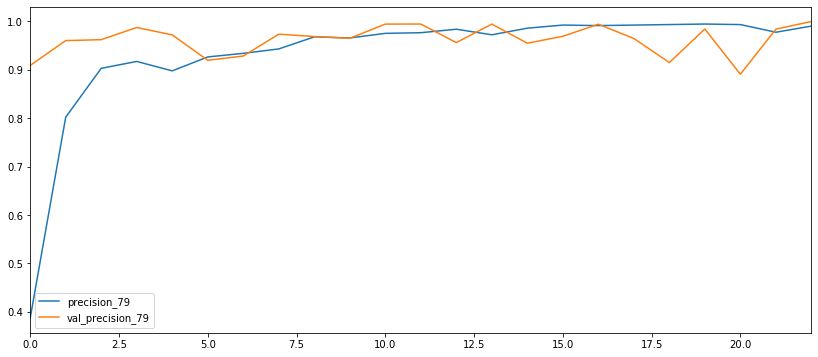

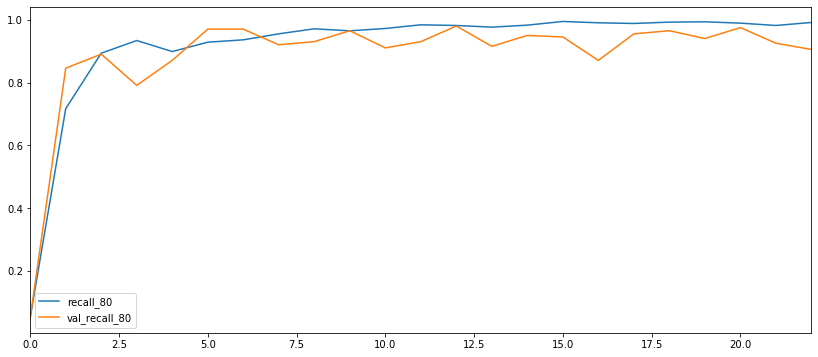

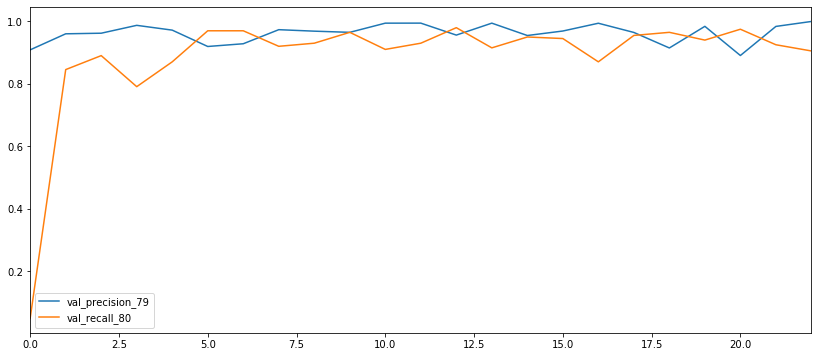

In [276]:
#Adam
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Adam is in improvement on sgd, but RMSprop even moreso.

#### Weight Initializers

Epoch 1/30
37/37 [==============================] - 46s 1s/step - loss: 0.6462 - acc: 0.6481 - precision_63: 0.3003 - recall_64: 0.2016 - val_loss: 0.5773 - val_acc: 0.7430 - val_precision_63: 0.0000e+00 - val_recall_64: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 41s 1s/step - loss: 0.5780 - acc: 0.7408 - precision_63: 0.0000e+00 - recall_64: 0.0000e+00 - val_loss: 0.5712 - val_acc: 0.7430 - val_precision_63: 0.0000e+00 - val_recall_64: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 0.5738 - acc: 0.7400 - precision_63: 0.0000e+00 - recall_64: 0.0000e+00 - val_loss: 0.5655 - val_acc: 0.7430 - val_precision_63: 0.0000e+00 - val_recall_64: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 40s 1s/step - loss: 0.5637 - acc: 0.7440 - precision_63: 0.0000e+00 - recall_64: 0.0000e+00 - val_loss: 0.5581 - val_acc: 0.7430 - val_precision_63: 0.0000e+00 - val_recall_64: 0.0000e+00
Epoch 5/30
37/37 [==============================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[565  16]
 [ 17 184]]
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       581
   Pneumonia       0.92      0.92      0.92       201

    accuracy                           0.96       782
   macro avg       0.95      0.94      0.94       782
weighted avg       0.96      0.96      0.96       782



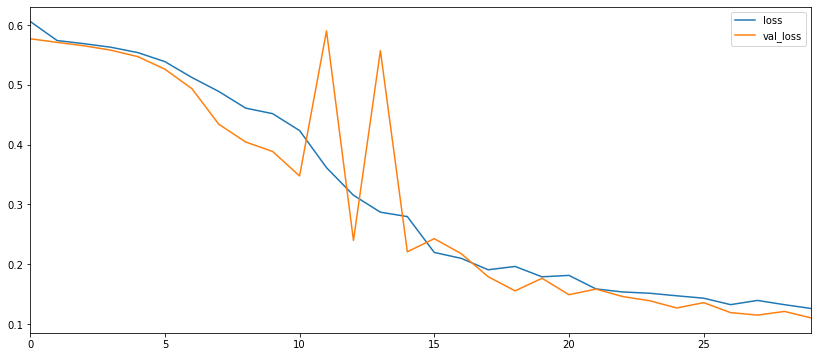

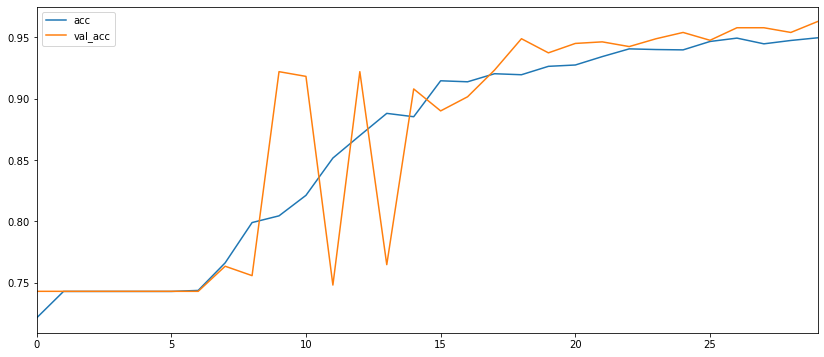

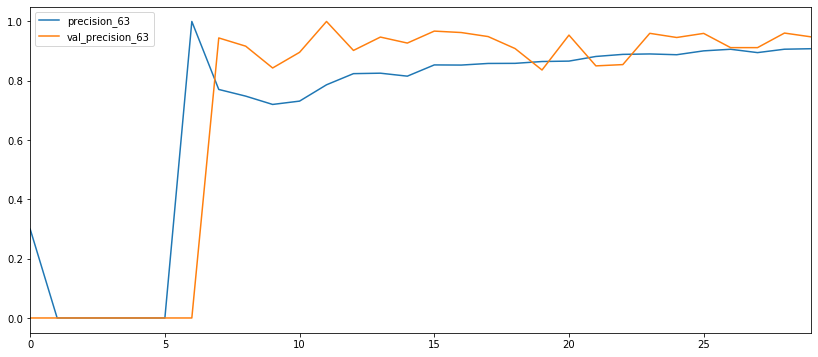

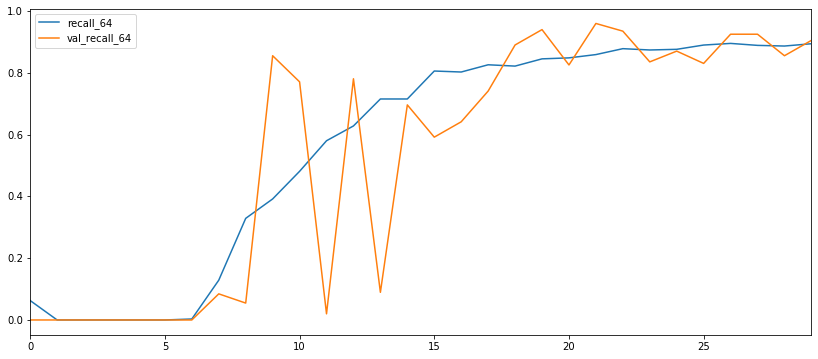

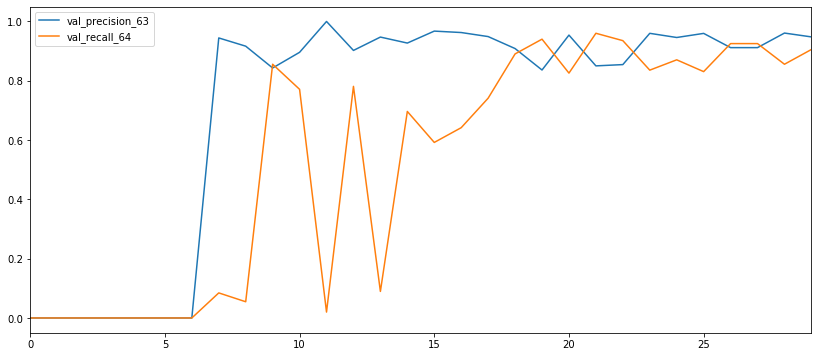

In [246]:
#Original:
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 46s 1s/step - loss: 0.6008 - acc: 0.7396 - precision_64: 0.0000e+00 - recall_65: 0.0000e+00 - val_loss: 0.5691 - val_acc: 0.7430 - val_precision_64: 0.0000e+00 - val_recall_65: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 40s 1s/step - loss: 0.5711 - acc: 0.7342 - precision_64: 0.0000e+00 - recall_65: 0.0000e+00 - val_loss: 0.5471 - val_acc: 0.7430 - val_precision_64: 0.0000e+00 - val_recall_65: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 0.5420 - acc: 0.7420 - precision_64: 0.0000e+00 - recall_65: 0.0000e+00 - val_loss: 0.5109 - val_acc: 0.7430 - val_precision_64: 0.0000e+00 - val_recall_65: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 41s 1s/step - loss: 0.5134 - acc: 0.7587 - precision_64: 0.7436 - recall_65: 0.0827 - val_loss: 0.4610 - val_acc: 0.7468 - val_precision_64: 0.8000 - val_recall_65: 0.0199
Epoch 5/30
37/37 [==============================] - 41s 

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[558  23]
 [  7 194]]
              precision    recall  f1-score   support

      Normal       0.99      0.96      0.97       581
   Pneumonia       0.89      0.97      0.93       201

    accuracy                           0.96       782
   macro avg       0.94      0.96      0.95       782
weighted avg       0.96      0.96      0.96       782



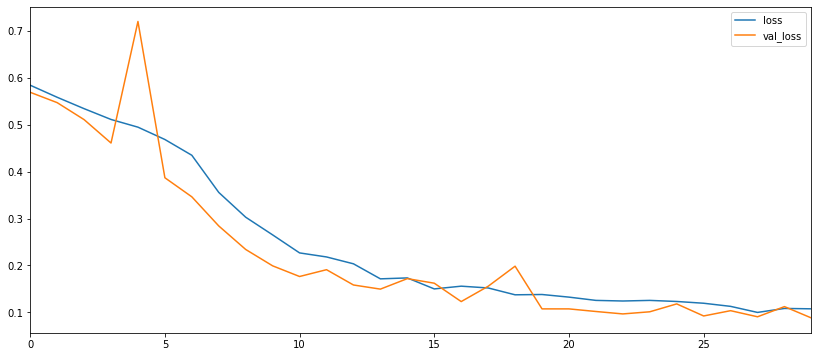

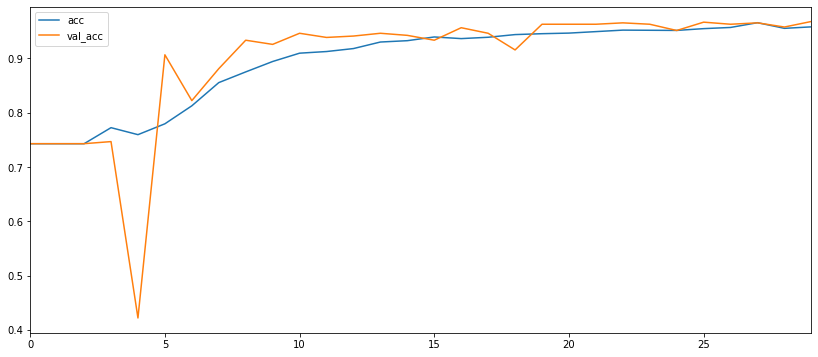

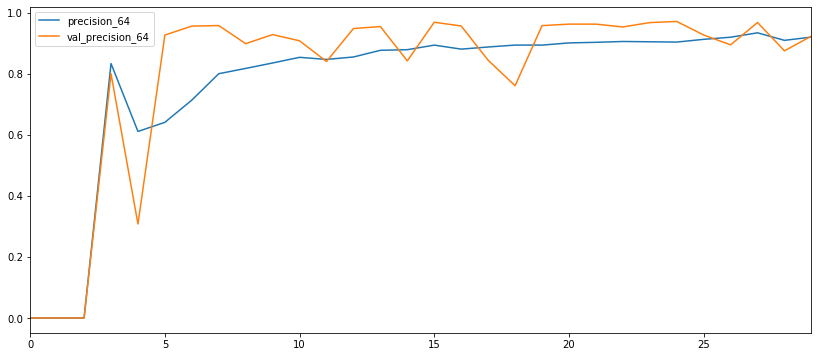

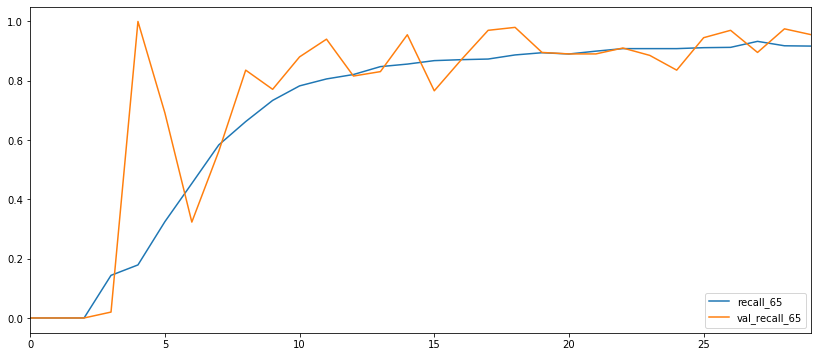

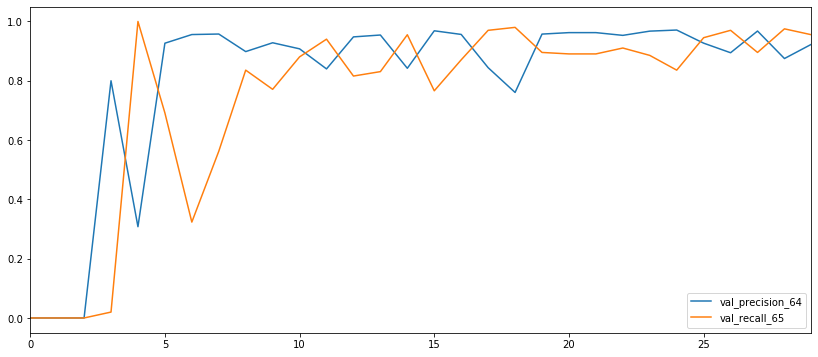

In [247]:
#LecunNormal
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='lecun_normal', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='lecun_normal'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='lecun_normal'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='lecun_normal'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu', kernel_initializer='lecun_normal'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 46s 1s/step - loss: 0.5944 - acc: 0.7444 - precision_65: 0.0000e+00 - recall_66: 0.0000e+00 - val_loss: 0.5663 - val_acc: 0.7430 - val_precision_65: 0.0000e+00 - val_recall_66: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 41s 1s/step - loss: 0.5634 - acc: 0.7408 - precision_65: 0.0000e+00 - recall_66: 0.0000e+00 - val_loss: 0.5540 - val_acc: 0.7430 - val_precision_65: 0.0000e+00 - val_recall_66: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 0.5353 - acc: 0.7476 - precision_65: 0.0000e+00 - recall_66: 0.0000e+00 - val_loss: 0.5121 - val_acc: 0.7430 - val_precision_65: 0.0000e+00 - val_recall_66: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 40s 1s/step - loss: 0.5158 - acc: 0.7513 - precision_65: 0.8075 - recall_66: 0.0669 - val_loss: 0.4750 - val_acc: 0.7430 - val_precision_65: 0.0000e+00 - val_recall_66: 0.0000e+00
Epoch 5/30
37/37 [==============================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[568  13]
 [ 10 191]]
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       581
   Pneumonia       0.94      0.95      0.94       201

    accuracy                           0.97       782
   macro avg       0.96      0.96      0.96       782
weighted avg       0.97      0.97      0.97       782



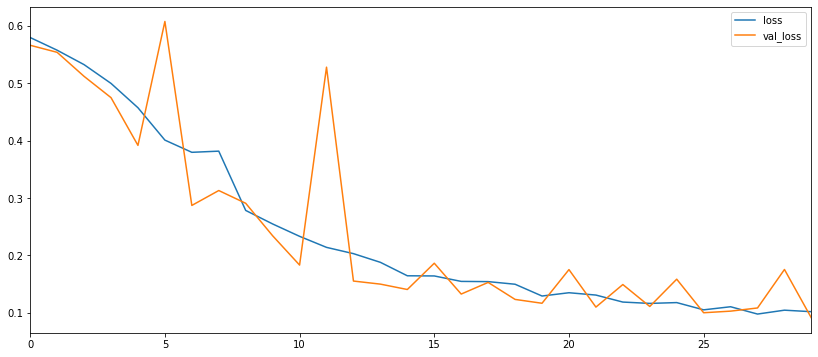

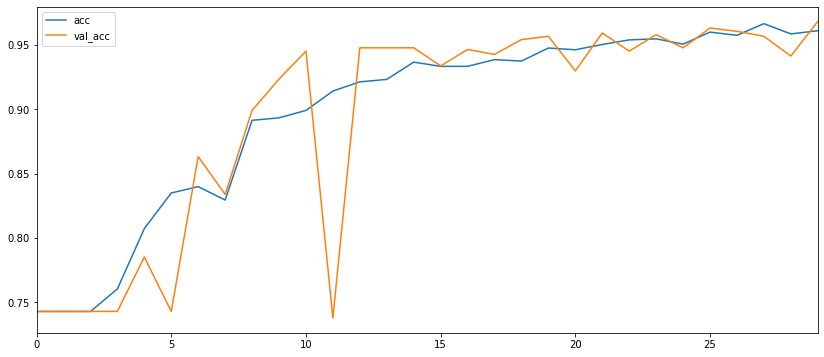

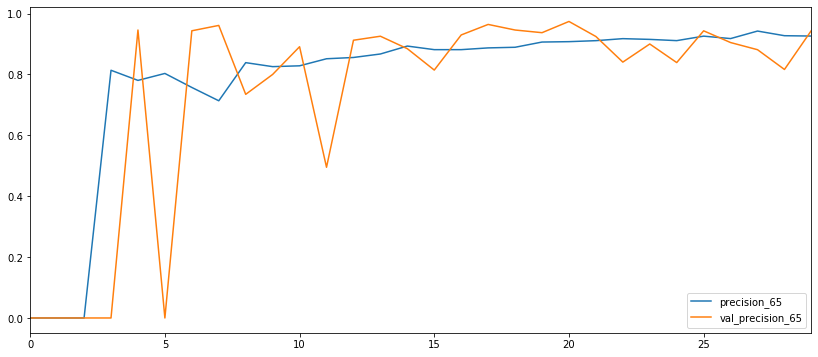

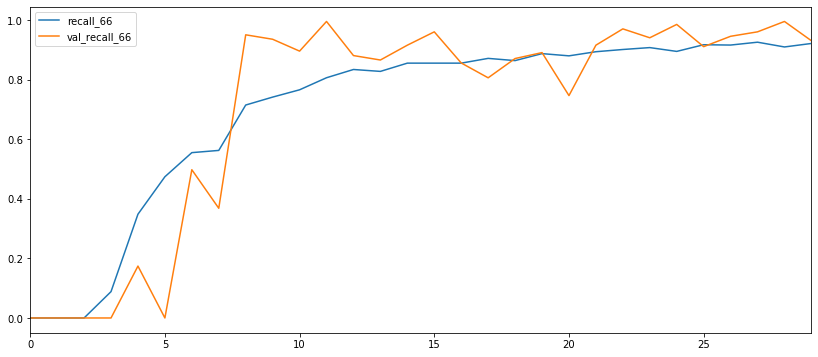

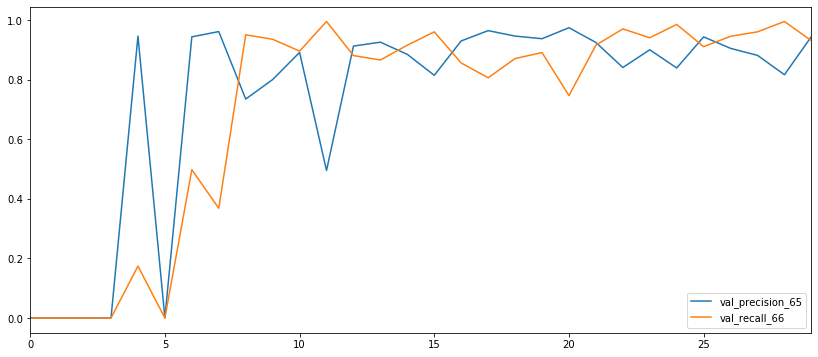

In [248]:
#RandomNormal
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=RandomNormal, input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=RandomNormal))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=RandomNormal))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=RandomNormal))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu', kernel_initializer=RandomNormal))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 50s 1s/step - loss: 0.6708 - acc: 0.7383 - precision_66: 0.4545 - recall_67: 0.0200 - val_loss: 0.6100 - val_acc: 0.7430 - val_precision_66: 0.0000e+00 - val_recall_67: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 44s 1s/step - loss: 0.5881 - acc: 0.7569 - precision_66: 0.0000e+00 - recall_67: 0.0000e+00 - val_loss: 0.5732 - val_acc: 0.7430 - val_precision_66: 0.0000e+00 - val_recall_67: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 0.5774 - acc: 0.7375 - precision_66: 0.0000e+00 - recall_67: 0.0000e+00 - val_loss: 0.5711 - val_acc: 0.7430 - val_precision_66: 0.0000e+00 - val_recall_67: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 41s 1s/step - loss: 0.5630 - acc: 0.7502 - precision_66: 0.0000e+00 - recall_67: 0.0000e+00 - val_loss: 0.5701 - val_acc: 0.7430 - val_precision_66: 0.0000e+00 - val_recall_67: 0.0000e+00
Epoch 5/30
37/37 [==============================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[575   6]
 [ 46 155]]
              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96       581
   Pneumonia       0.96      0.77      0.86       201

    accuracy                           0.93       782
   macro avg       0.94      0.88      0.91       782
weighted avg       0.94      0.93      0.93       782



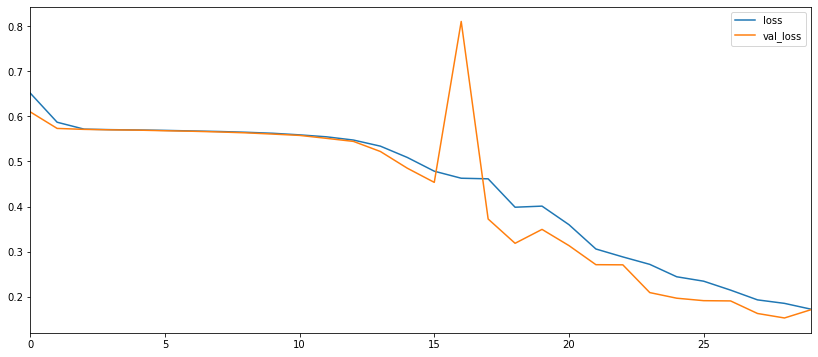

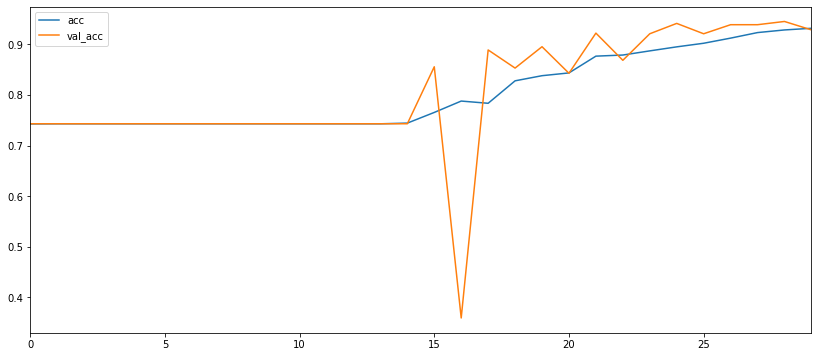

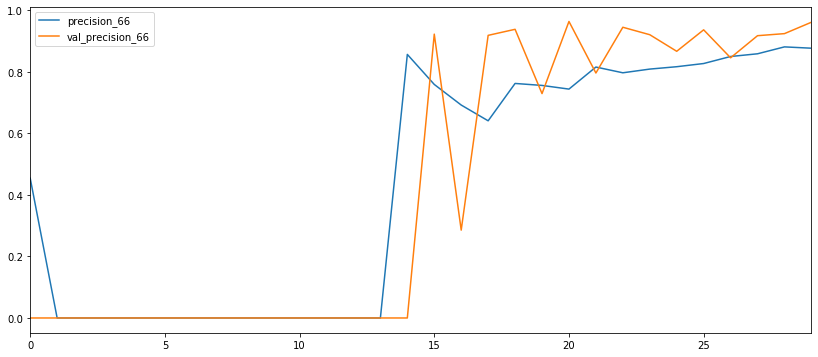

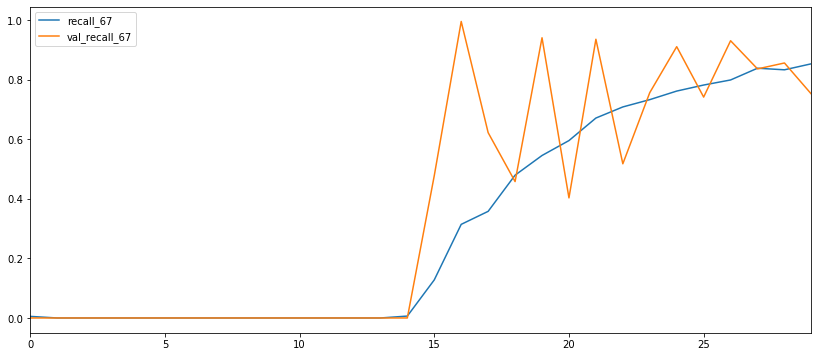

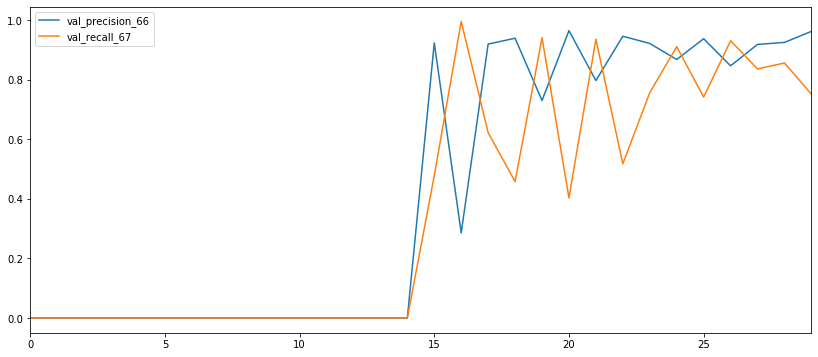

In [251]:
#RandomUniform
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=RandomUniform, input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=RandomUniform))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=RandomUniform))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=RandomUniform))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu', kernel_initializer=RandomUniform))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Lecun_Normal was an improvement, RandomNormal moreso, but RandomUniform was worse than the original

#### More Epochs

Epoch 1/30
37/37 [==============================] - 46s 1s/step - loss: 0.6210 - acc: 0.7431 - precision_67: 0.0000e+00 - recall_68: 0.0000e+00 - val_loss: 0.5748 - val_acc: 0.7430 - val_precision_67: 0.0000e+00 - val_recall_68: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 40s 1s/step - loss: 0.5738 - acc: 0.7435 - precision_67: 0.0000e+00 - recall_68: 0.0000e+00 - val_loss: 0.5686 - val_acc: 0.7430 - val_precision_67: 0.0000e+00 - val_recall_68: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 0.5726 - acc: 0.7384 - precision_67: 0.0000e+00 - recall_68: 0.0000e+00 - val_loss: 0.5602 - val_acc: 0.7430 - val_precision_67: 0.0000e+00 - val_recall_68: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 40s 1s/step - loss: 0.5634 - acc: 0.7383 - precision_67: 0.0000e+00 - recall_68: 0.0000e+00 - val_loss: 0.5474 - val_acc: 0.7430 - val_precision_67: 0.0000e+00 - val_recall_68: 0.0000e+00
Epoch 5/30
37/37 [======================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[569  12]
 [ 18 183]]
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97       581
   Pneumonia       0.94      0.91      0.92       201

    accuracy                           0.96       782
   macro avg       0.95      0.94      0.95       782
weighted avg       0.96      0.96      0.96       782



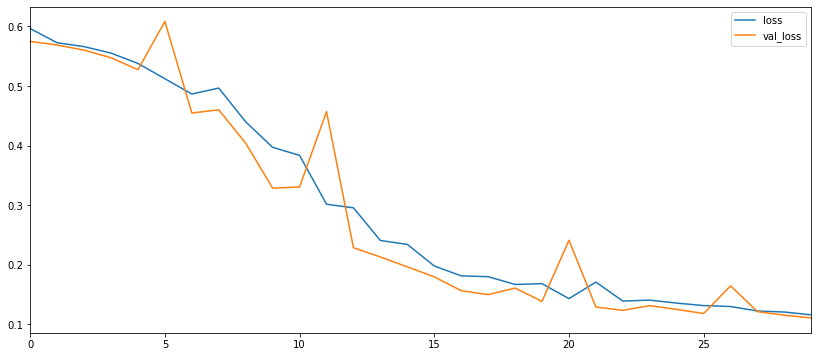

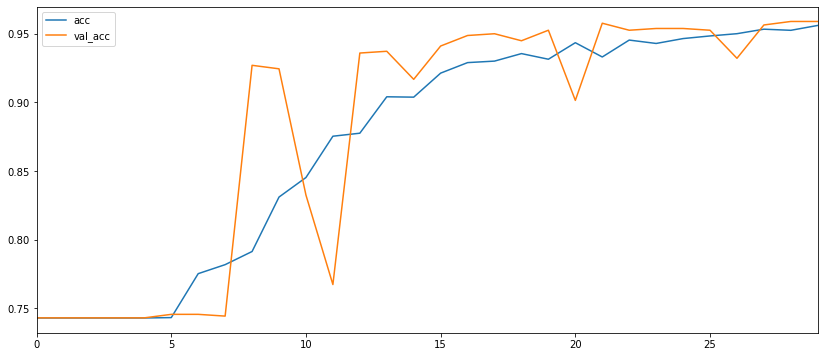

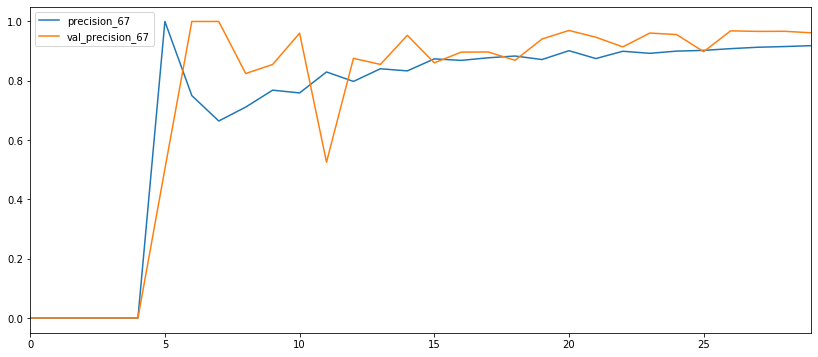

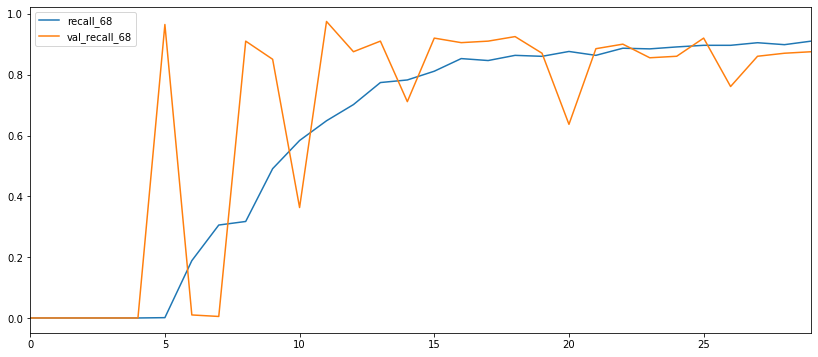

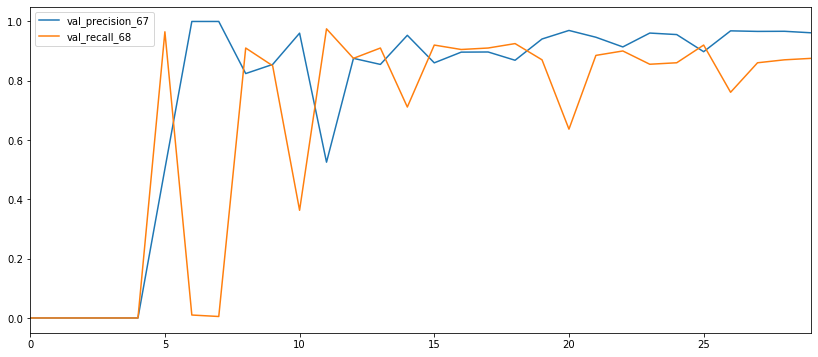

In [252]:
#Original: 30 epochs
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/75
37/37 [==============================] - 46s 1s/step - loss: 0.6231 - acc: 0.6767 - precision_68: 0.1700 - recall_69: 0.0849 - val_loss: 0.5765 - val_acc: 0.7430 - val_precision_68: 0.0000e+00 - val_recall_69: 0.0000e+00
Epoch 2/75
37/37 [==============================] - 41s 1s/step - loss: 0.5723 - acc: 0.7436 - precision_68: 0.0000e+00 - recall_69: 0.0000e+00 - val_loss: 0.5717 - val_acc: 0.7430 - val_precision_68: 0.0000e+00 - val_recall_69: 0.0000e+00
Epoch 3/75
37/37 [==============================] - 41s 1s/step - loss: 0.5624 - acc: 0.7482 - precision_68: 0.0000e+00 - recall_69: 0.0000e+00 - val_loss: 0.5607 - val_acc: 0.7430 - val_precision_68: 0.0000e+00 - val_recall_69: 0.0000e+00
Epoch 4/75
37/37 [==============================] - 41s 1s/step - loss: 0.5610 - acc: 0.7383 - precision_68: 0.0000e+00 - recall_69: 0.0000e+00 - val_loss: 0.5467 - val_acc: 0.7430 - val_precision_68: 0.0000e+00 - val_recall_69: 0.0000e+00
Epoch 5/75
37/37 [==============================

37/37 [==============================] - 41s 1s/step - loss: 0.0588 - acc: 0.9785 - precision_68: 0.9633 - recall_69: 0.9544 - val_loss: 0.0663 - val_acc: 0.9744 - val_precision_68: 0.9372 - val_recall_69: 0.9652
Epoch 74/75
37/37 [==============================] - 40s 1s/step - loss: 0.0581 - acc: 0.9816 - precision_68: 0.9656 - recall_69: 0.9643 - val_loss: 0.0609 - val_acc: 0.9757 - val_precision_68: 0.9550 - val_recall_69: 0.9502
Epoch 75/75
25/25 [==============================] - 2s 75ms/step - loss: 0.1162 - acc: 0.9616 - precision_68: 0.9777 - recall_69: 0.8706
[0.11622967571020126, 0.9616368412971497, 0.9776536226272583, 0.8706467747688293]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[577   4]
 [ 26 175]]
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97       581
   Pneumonia       0.98      0.87      0.92       201

    accuracy                           0.96       782
   macro avg       0.97      0.93      0.95       782
weighted avg       0.96      0.96      0.96       782



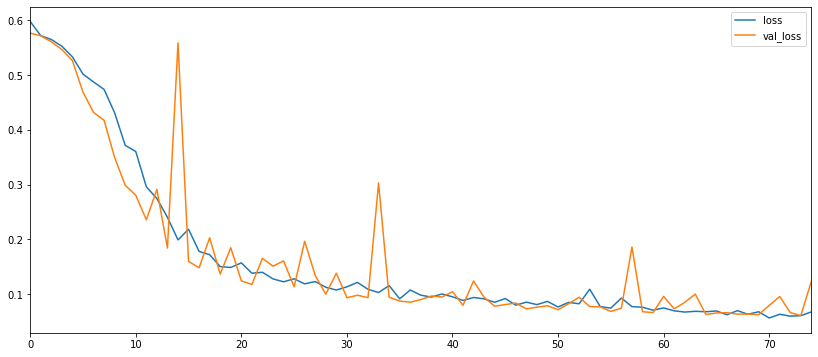

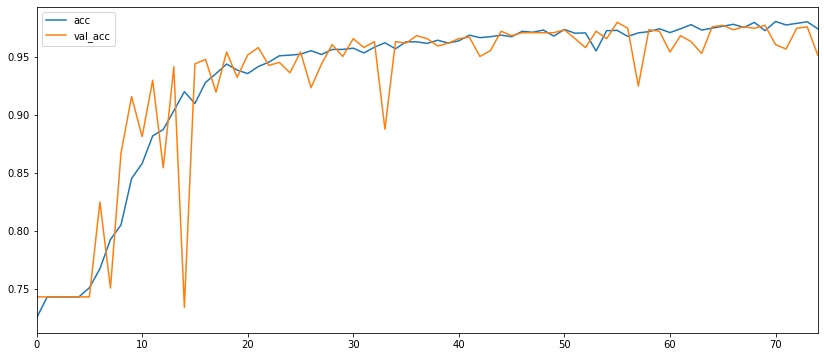

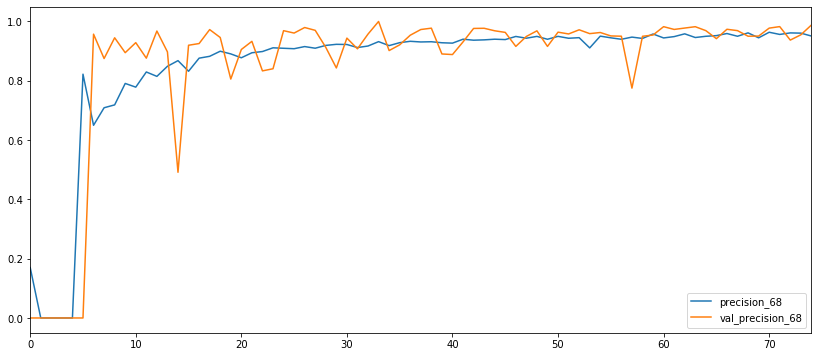

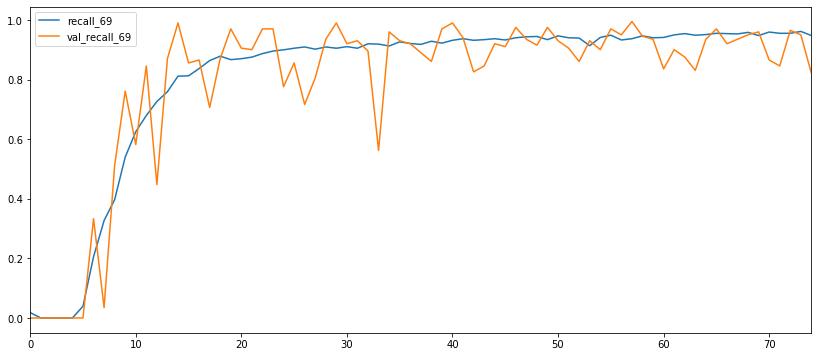

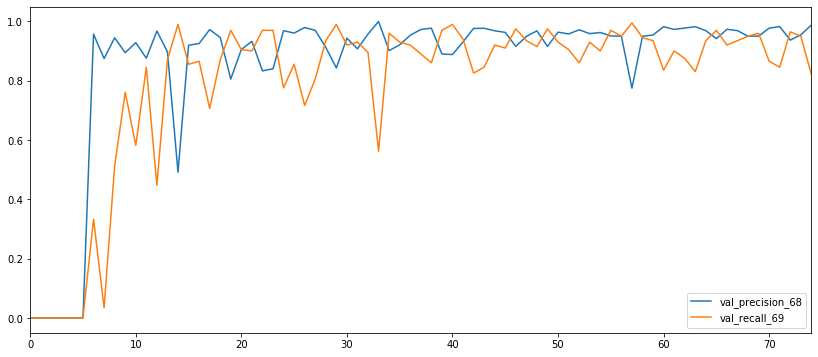

In [253]:
#75 epochs
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=75, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/150
37/37 [==============================] - 47s 1s/step - loss: 0.6442 - acc: 0.6586 - precision_69: 0.2957 - recall_70: 0.2085 - val_loss: 0.5748 - val_acc: 0.7430 - val_precision_69: 0.0000e+00 - val_recall_70: 0.0000e+00
Epoch 2/150
37/37 [==============================] - 41s 1s/step - loss: 0.5658 - acc: 0.7506 - precision_69: 0.0000e+00 - recall_70: 0.0000e+00 - val_loss: 0.5697 - val_acc: 0.7430 - val_precision_69: 0.0000e+00 - val_recall_70: 0.0000e+00
Epoch 3/150
37/37 [==============================] - 40s 1s/step - loss: 0.5713 - acc: 0.7388 - precision_69: 0.0000e+00 - recall_70: 0.0000e+00 - val_loss: 0.5648 - val_acc: 0.7430 - val_precision_69: 0.0000e+00 - val_recall_70: 0.0000e+00
Epoch 4/150
37/37 [==============================] - 41s 1s/step - loss: 0.5519 - acc: 0.7520 - precision_69: 0.0000e+00 - recall_70: 0.0000e+00 - val_loss: 0.5617 - val_acc: 0.7430 - val_precision_69: 0.0000e+00 - val_recall_70: 0.0000e+00
Epoch 5/150
37/37 [=========================

Epoch 37/150
37/37 [==============================] - 41s 1s/step - loss: 0.1082 - acc: 0.9594 - precision_69: 0.9183 - recall_70: 0.9207 - val_loss: 0.0979 - val_acc: 0.9565 - val_precision_69: 0.9034 - val_recall_70: 0.9303
Epoch 38/150
37/37 [==============================] - 40s 1s/step - loss: 0.1107 - acc: 0.9538 - precision_69: 0.9121 - recall_70: 0.9056 - val_loss: 0.1986 - val_acc: 0.9233 - val_precision_69: 0.7701 - val_recall_70: 1.0000
Epoch 39/150
37/37 [==============================] - 42s 1s/step - loss: 0.1438 - acc: 0.9448 - precision_69: 0.8807 - recall_70: 0.9167 - val_loss: 0.0973 - val_acc: 0.9578 - val_precision_69: 0.9000 - val_recall_70: 0.9403
Epoch 40/150
37/37 [==============================] - 41s 1s/step - loss: 0.1096 - acc: 0.9601 - precision_69: 0.9216 - recall_70: 0.9141 - val_loss: 0.0998 - val_acc: 0.9629 - val_precision_69: 0.9725 - val_recall_70: 0.8806
Epoch 41/150
37/37 [==============================] - 41s 1s/step - loss: 0.0949 - acc: 0.9653 -

37/37 [==============================] - 41s 1s/step - loss: 0.0288 - acc: 0.9919 - precision_69: 0.9897 - recall_70: 0.9784 - val_loss: 0.1034 - val_acc: 0.9565 - val_precision_69: 0.9771 - val_recall_70: 0.8507
Epoch 110/150
37/37 [==============================] - 40s 1s/step - loss: 0.0545 - acc: 0.9798 - precision_69: 0.9674 - recall_70: 0.9562 - val_loss: 0.0688 - val_acc: 0.9731 - val_precision_69: 0.9737 - val_recall_70: 0.9204
Epoch 111/150
37/37 [==============================] - 41s 1s/step - loss: 0.0362 - acc: 0.9884 - precision_69: 0.9797 - recall_70: 0.9767 - val_loss: 0.0621 - val_acc: 0.9783 - val_precision_69: 0.9600 - val_recall_70: 0.9552
Epoch 112/150
37/37 [==============================] - 41s 1s/step - loss: 0.0325 - acc: 0.9881 - precision_69: 0.9786 - recall_70: 0.9772 - val_loss: 0.0790 - val_acc: 0.9693 - val_precision_69: 0.9784 - val_recall_70: 0.9005
Epoch 113/150
37/37 [==============================] - 41s 1s/step - loss: 0.0316 - acc: 0.9900 - precisio

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[566  15]
 [  7 194]]
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       581
   Pneumonia       0.93      0.97      0.95       201

    accuracy                           0.97       782
   macro avg       0.96      0.97      0.96       782
weighted avg       0.97      0.97      0.97       782



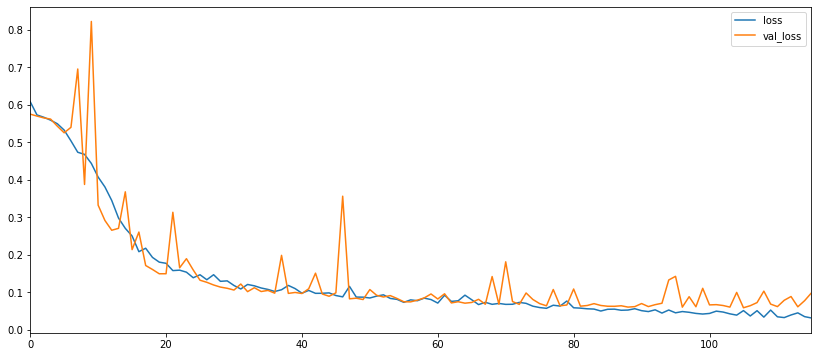

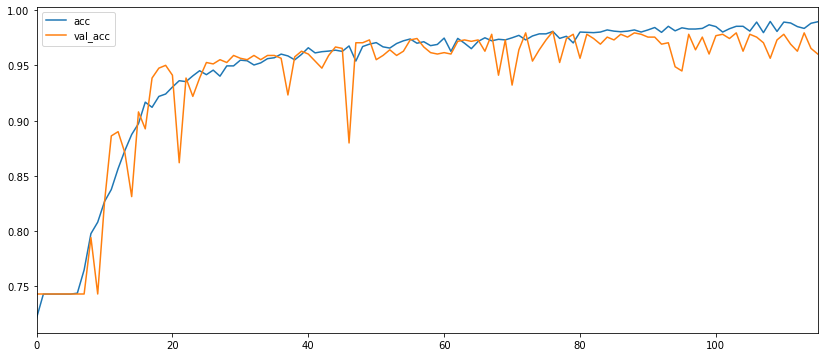

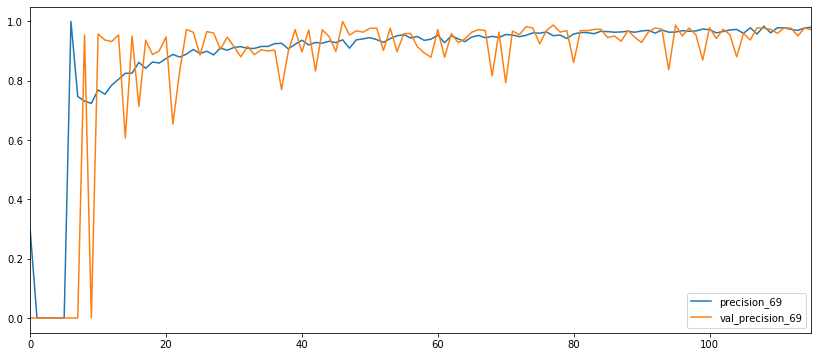

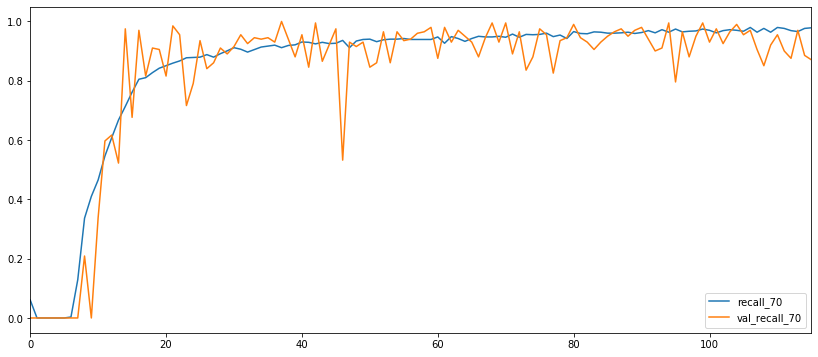

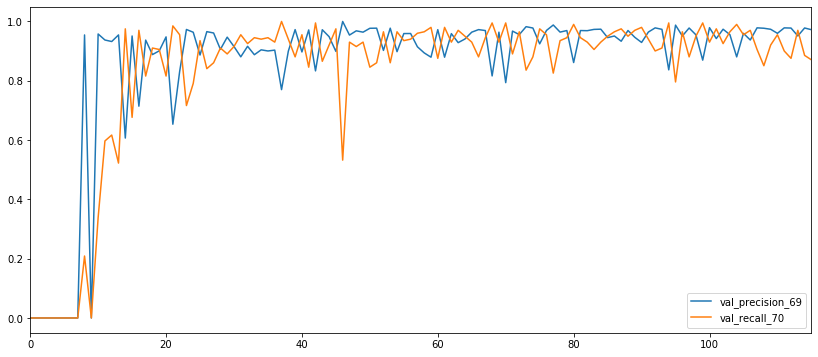

In [254]:
#150 epochs
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=150, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Overfit from ~90 epochs however, next, I'll still try some regularisation techniques

#### Regularised

Epoch 1/30
37/37 [==============================] - 51s 1s/step - loss: 0.6415 - acc: 0.7175 - precision_80: 0.2400 - recall_81: 0.0531 - val_loss: 0.5755 - val_acc: 0.7430 - val_precision_80: 0.0000e+00 - val_recall_81: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 43s 1s/step - loss: 0.5731 - acc: 0.7429 - precision_80: 0.0000e+00 - recall_81: 0.0000e+00 - val_loss: 0.5709 - val_acc: 0.7430 - val_precision_80: 0.0000e+00 - val_recall_81: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 48s 1s/step - loss: 0.5663 - acc: 0.7440 - precision_80: 0.0000e+00 - recall_81: 0.0000e+00 - val_loss: 0.5629 - val_acc: 0.7430 - val_precision_80: 0.0000e+00 - val_recall_81: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 58s 2s/step - loss: 0.5546 - acc: 0.7494 - precision_80: 0.0000e+00 - recall_81: 0.0000e+00 - val_loss: 0.5549 - val_acc: 0.7430 - val_precision_80: 0.0000e+00 - val_recall_81: 0.0000e+00
Epoch 5/30
37/37 [==============================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[544  37]
 [  6 195]]
              precision    recall  f1-score   support

      Normal       0.99      0.94      0.96       581
   Pneumonia       0.84      0.97      0.90       201

    accuracy                           0.95       782
   macro avg       0.91      0.95      0.93       782
weighted avg       0.95      0.95      0.95       782



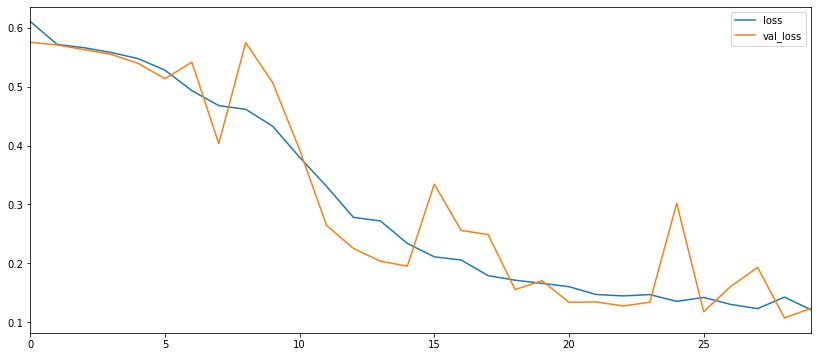

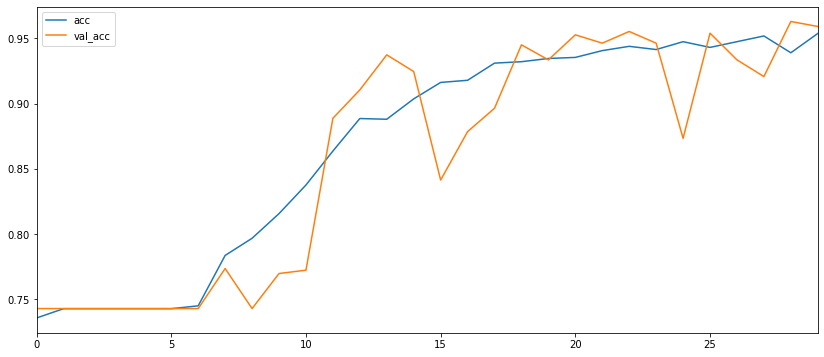

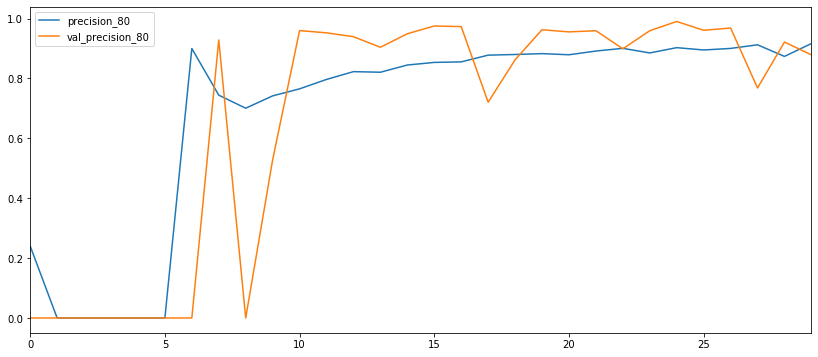

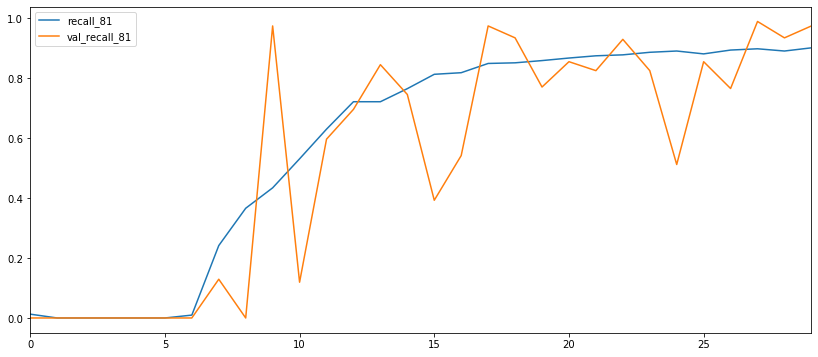

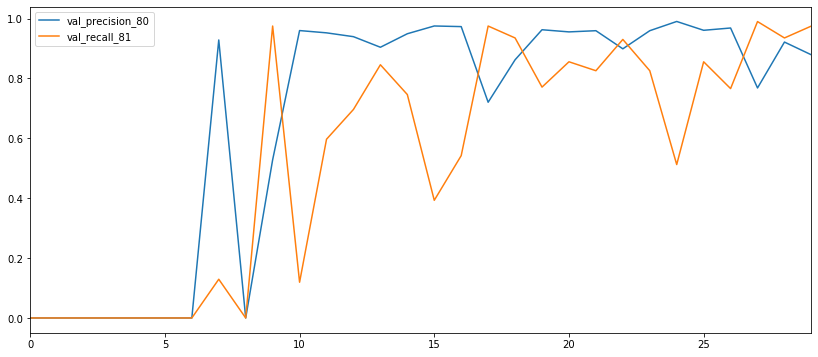

In [278]:
#Original: No regularisation
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
cb = [es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 50s 1s/step - loss: 197.1163 - acc: 0.7434 - precision_86: 0.0000e+00 - recall_87: 0.0000e+00 - val_loss: 166.3763 - val_acc: 0.7430 - val_precision_86: 0.0000e+00 - val_recall_87: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 43s 1s/step - loss: 156.9187 - acc: 0.7434 - precision_86: 0.0000e+00 - recall_87: 0.0000e+00 - val_loss: 129.6919 - val_acc: 0.7430 - val_precision_86: 0.0000e+00 - val_recall_87: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 44s 1s/step - loss: 121.3707 - acc: 0.7504 - precision_86: 0.0000e+00 - recall_87: 0.0000e+00 - val_loss: 97.6026 - val_acc: 0.7430 - val_precision_86: 0.0000e+00 - val_recall_87: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 44s 1s/step - loss: 90.4388 - acc: 0.7443 - precision_86: 0.0000e+00 - recall_87: 0.0000e+00 - val_loss: 70.1224 - val_acc: 0.7430 - val_precision_86: 0.0000e+00 - val_recall_87: 0.0000e+00
Epoch 5/30
37/37 [=========

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[581   0]
 [201   0]]
              precision    recall  f1-score   support

      Normal       0.74      1.00      0.85       581
   Pneumonia       0.00      0.00      0.00       201

    accuracy                           0.74       782
   macro avg       0.37      0.50      0.43       782
weighted avg       0.55      0.74      0.63       782



C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


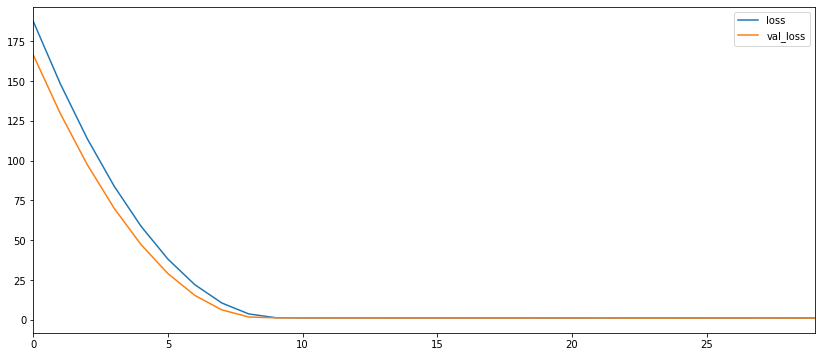

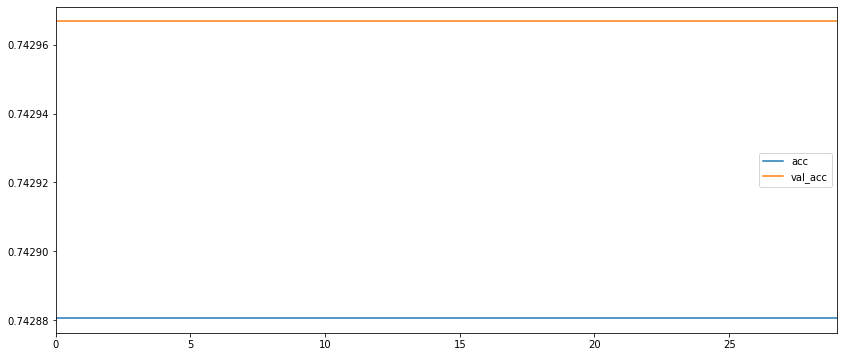

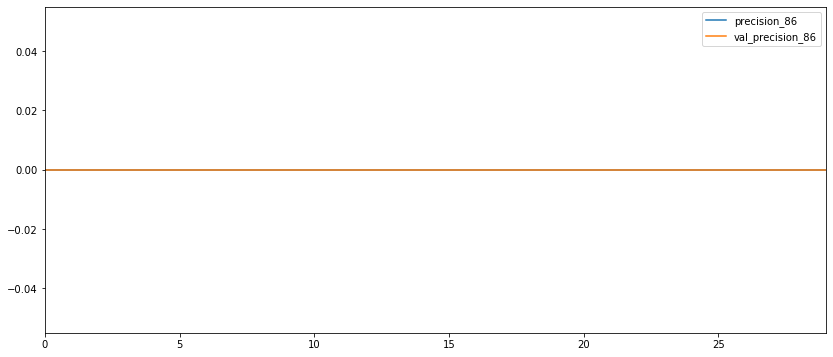

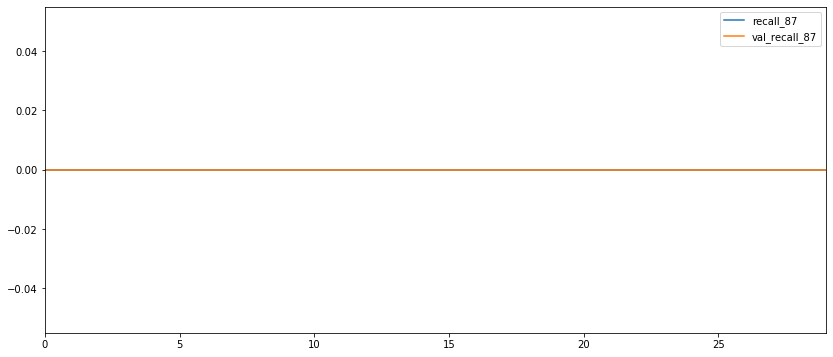

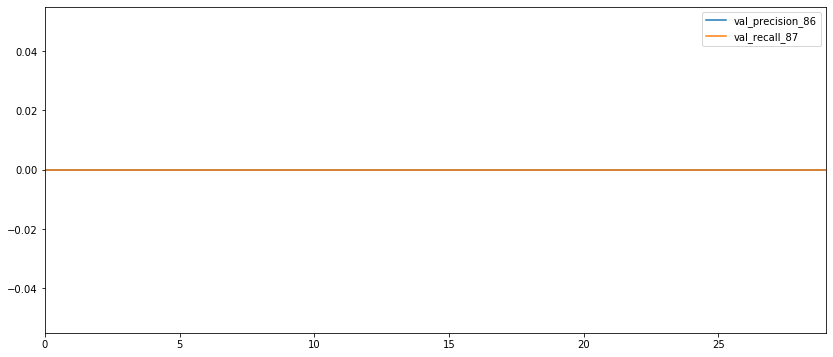

In [285]:
#Original: l1 regularisation
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu', kernel_regularizer='l1'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/reg_models_1/{epoch:02d}.h5')
cb = [mc, es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 46s 1s/step - loss: 239.4688 - acc: 0.6954 - precision_90: 0.3727 - recall_91: 0.2258 - val_loss: 205.2507 - val_acc: 0.7430 - val_precision_90: 0.0000e+00 - val_recall_91: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 41s 1s/step - loss: 194.6724 - acc: 0.7451 - precision_90: 0.0000e+00 - recall_91: 0.0000e+00 - val_loss: 164.1537 - val_acc: 0.7430 - val_precision_90: 0.0000e+00 - val_recall_91: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 154.7972 - acc: 0.7356 - precision_90: 0.0000e+00 - recall_91: 0.0000e+00 - val_loss: 127.9211 - val_acc: 0.7430 - val_precision_90: 0.0000e+00 - val_recall_91: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 40s 1s/step - loss: 119.7807 - acc: 0.7330 - precision_90: 0.0000e+00 - recall_91: 0.0000e+00 - val_loss: 96.5565 - val_acc: 0.7430 - val_precision_90: 0.0000e+00 - val_recall_91: 0.0000e+00
Epoch 5/30
37/37 [===============

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[581   0]
 [201   0]]
              precision    recall  f1-score   support

      Normal       0.74      1.00      0.85       581
   Pneumonia       0.00      0.00      0.00       201

    accuracy                           0.74       782
   macro avg       0.37      0.50      0.43       782
weighted avg       0.55      0.74      0.63       782



C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


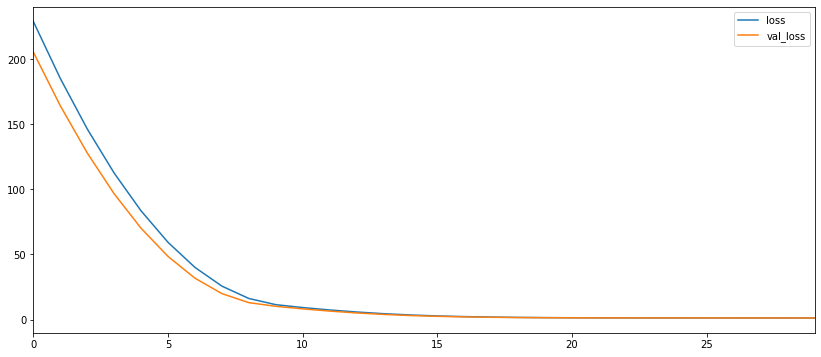

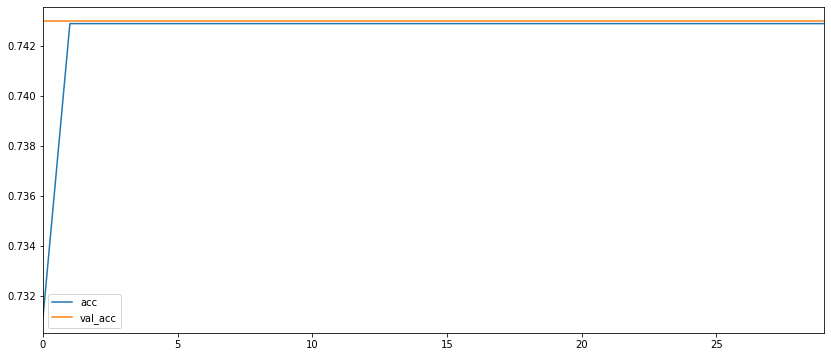

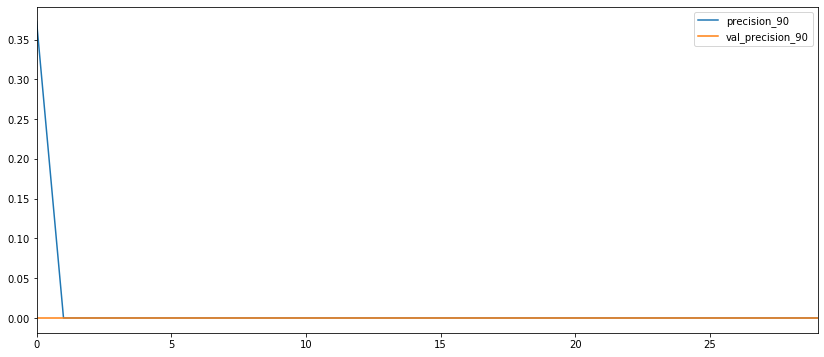

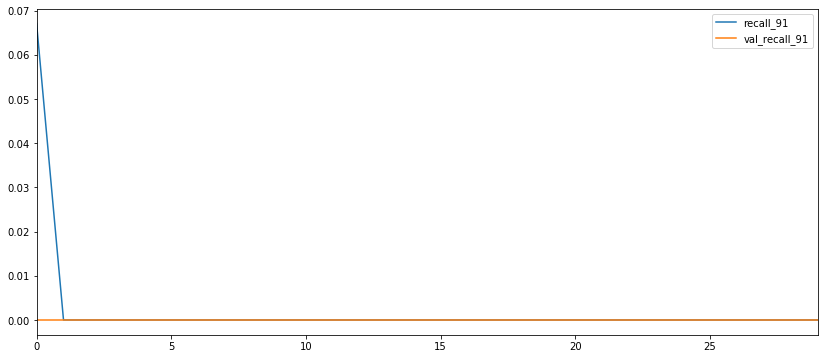

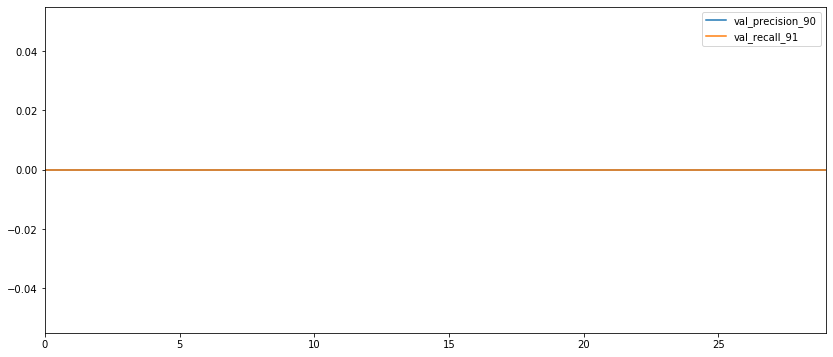

In [289]:
#Original: l1 regularisation
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l1', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l1'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l1'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l1'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu', kernel_regularizer='l1'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/reg_models_1b/{epoch:02d}.h5')
cb = [mc, es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 54s 1s/step - loss: 5.4494 - acc: 0.6935 - precision_88: 0.3103 - recall_89: 0.1630 - val_loss: 5.3486 - val_acc: 0.7430 - val_precision_88: 0.0000e+00 - val_recall_89: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 50s 1s/step - loss: 5.3359 - acc: 0.7356 - precision_88: 0.0000e+00 - recall_89: 0.0000e+00 - val_loss: 5.2718 - val_acc: 0.7430 - val_precision_88: 0.0000e+00 - val_recall_89: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 48s 1s/step - loss: 5.2512 - acc: 0.7406 - precision_88: 0.0000e+00 - recall_89: 0.0000e+00 - val_loss: 5.1865 - val_acc: 0.7430 - val_precision_88: 0.0000e+00 - val_recall_89: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 46s 1s/step - loss: 5.1700 - acc: 0.7367 - precision_88: 0.0000e+00 - recall_89: 0.0000e+00 - val_loss: 5.0965 - val_acc: 0.7430 - val_precision_88: 0.0000e+00 - val_recall_89: 0.0000e+00
Epoch 5/30
37/37 [==============================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[565  16]
 [ 11 190]]
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.98       581
   Pneumonia       0.92      0.95      0.93       201

    accuracy                           0.97       782
   macro avg       0.95      0.96      0.96       782
weighted avg       0.97      0.97      0.97       782



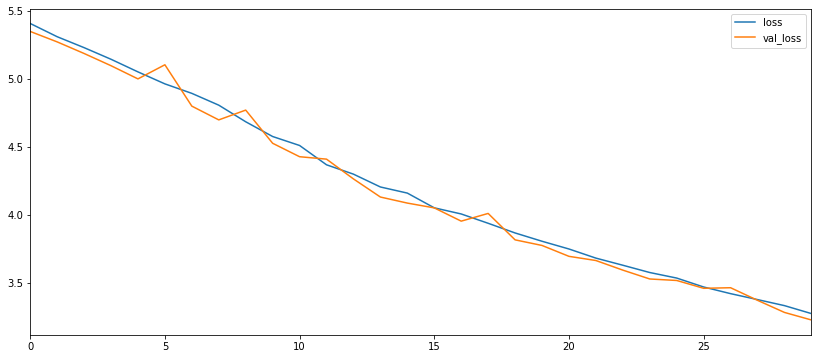

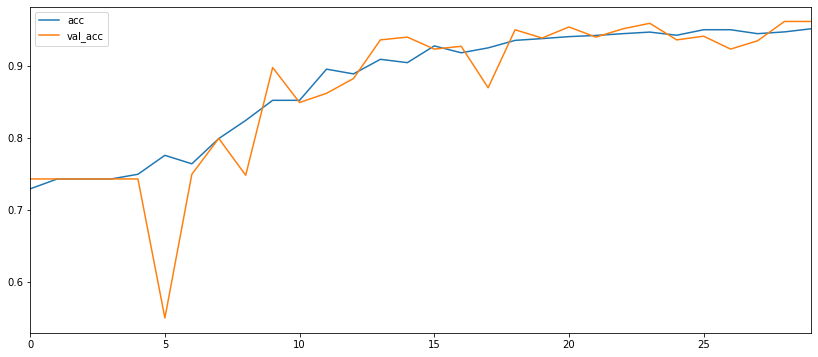

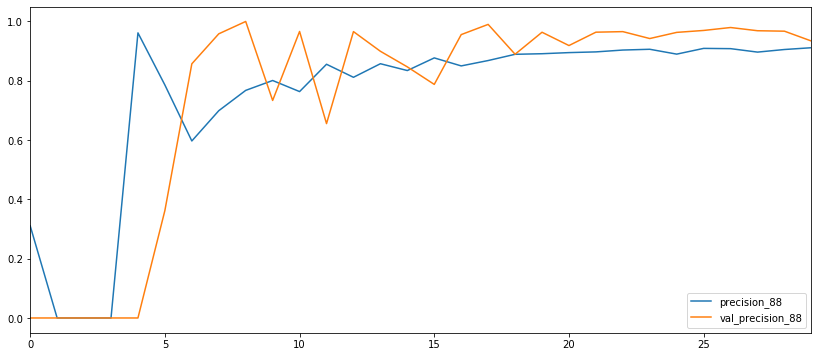

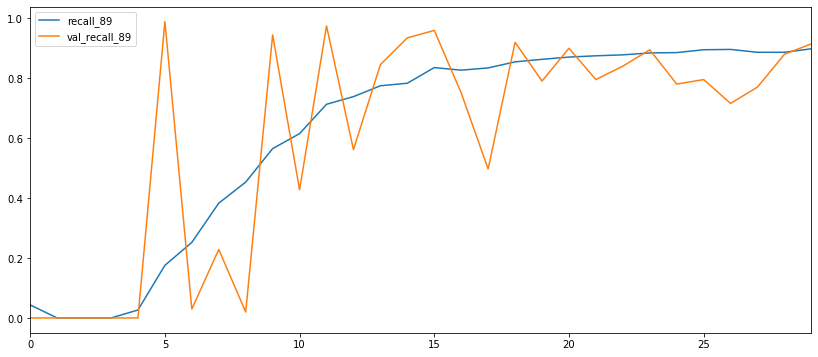

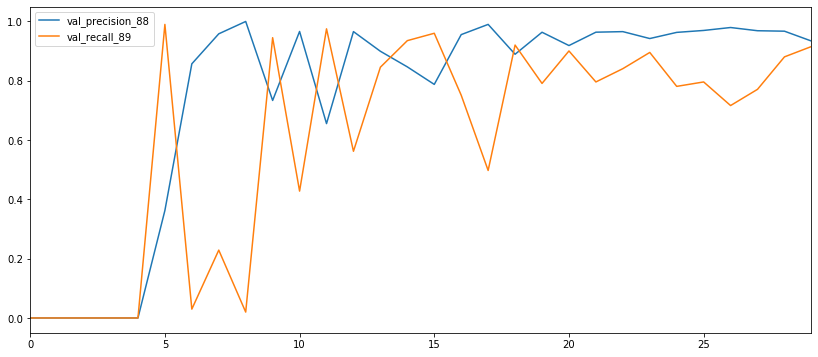

In [287]:
#Original: l2 regularisation
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu', kernel_regularizer='l2'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/reg_models_2/{epoch:02d}.h5')
cb = [mc, es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 47s 1s/step - loss: 7.4263 - acc: 0.7441 - precision_91: 0.0000e+00 - recall_92: 0.0000e+00 - val_loss: 7.2981 - val_acc: 0.7430 - val_precision_91: 0.0000e+00 - val_recall_92: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 41s 1s/step - loss: 7.2719 - acc: 0.7429 - precision_91: 0.0000e+00 - recall_92: 0.0000e+00 - val_loss: 7.1944 - val_acc: 0.7430 - val_precision_91: 0.0000e+00 - val_recall_92: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 41s 1s/step - loss: 7.1775 - acc: 0.7341 - precision_91: 0.0000e+00 - recall_92: 0.0000e+00 - val_loss: 7.0933 - val_acc: 0.7430 - val_precision_91: 0.0000e+00 - val_recall_92: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 41s 1s/step - loss: 7.0649 - acc: 0.7436 - precision_91: 0.0000e+00 - recall_92: 0.0000e+00 - val_loss: 6.9887 - val_acc: 0.7430 - val_precision_91: 0.0000e+00 - val_recall_92: 0.0000e+00
Epoch 5/30
37/37 [======================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[497  84]
 [  1 200]]
              precision    recall  f1-score   support

      Normal       1.00      0.86      0.92       581
   Pneumonia       0.70      1.00      0.82       201

    accuracy                           0.89       782
   macro avg       0.85      0.93      0.87       782
weighted avg       0.92      0.89      0.90       782



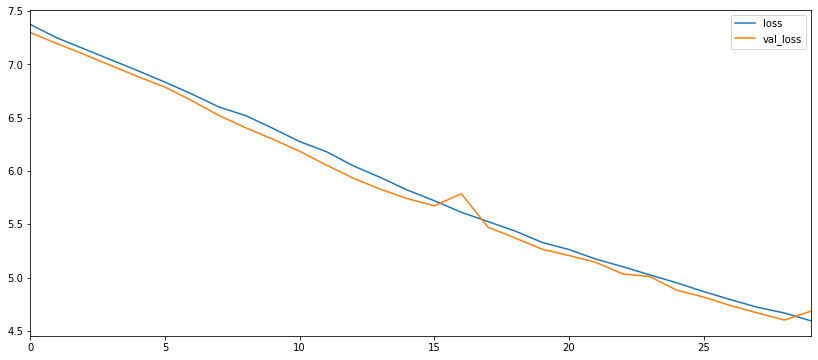

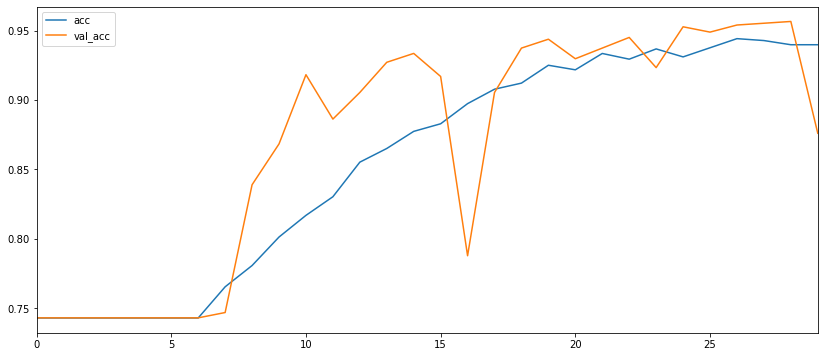

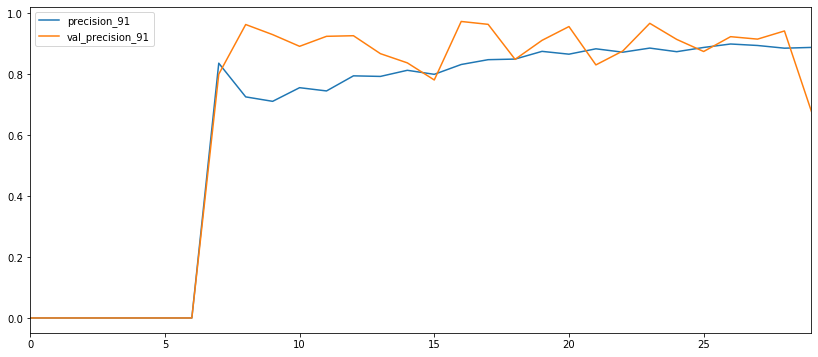

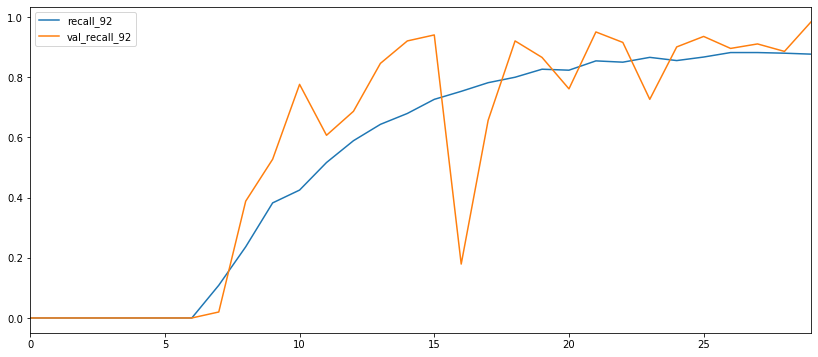

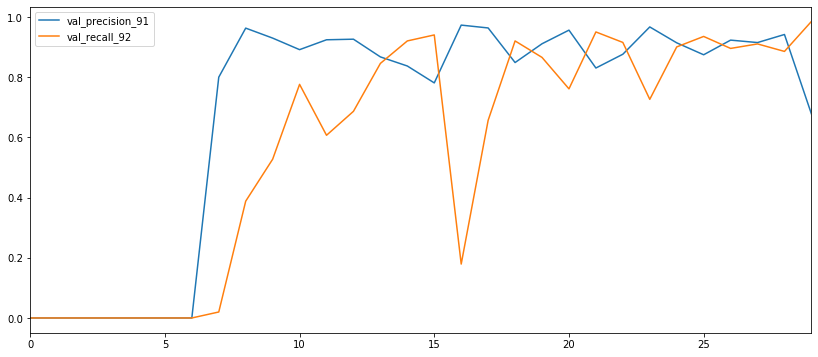

In [290]:
#Original: l2 regularisation
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dense(256, 'relu', kernel_regularizer='l2'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/reg_models_2b/{epoch:02d}.h5')
cb = [mc, es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 70s 2s/step - loss: 0.6472 - acc: 0.7057 - precision_89: 0.2241 - recall_90: 0.0767 - val_loss: 0.5772 - val_acc: 0.7430 - val_precision_89: 0.0000e+00 - val_recall_90: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 68s 2s/step - loss: 0.5714 - acc: 0.7489 - precision_89: 0.0000e+00 - recall_90: 0.0000e+00 - val_loss: 0.5737 - val_acc: 0.7430 - val_precision_89: 0.0000e+00 - val_recall_90: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 67s 2s/step - loss: 0.5723 - acc: 0.7441 - precision_89: 0.0000e+00 - recall_90: 0.0000e+00 - val_loss: 0.5681 - val_acc: 0.7430 - val_precision_89: 0.0000e+00 - val_recall_90: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 68s 2s/step - loss: 0.5744 - acc: 0.7363 - precision_89: 0.0000e+00 - recall_90: 0.0000e+00 - val_loss: 0.5633 - val_acc: 0.7430 - val_precision_89: 0.0000e+00 - val_recall_90: 0.0000e+00
Epoch 5/30
37/37 [==============================

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[563  18]
 [ 13 188]]
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.97       581
   Pneumonia       0.91      0.94      0.92       201

    accuracy                           0.96       782
   macro avg       0.95      0.95      0.95       782
weighted avg       0.96      0.96      0.96       782



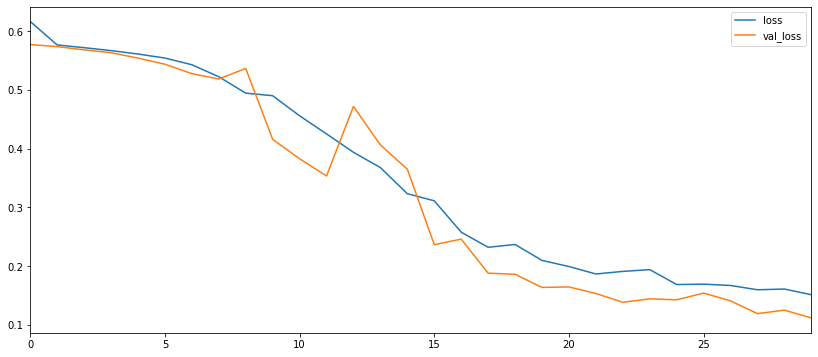

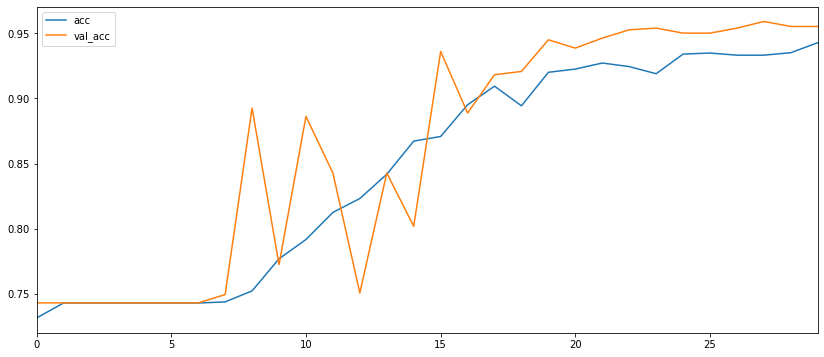

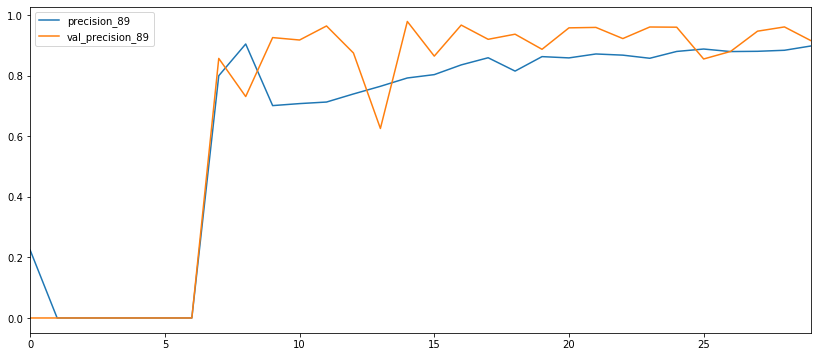

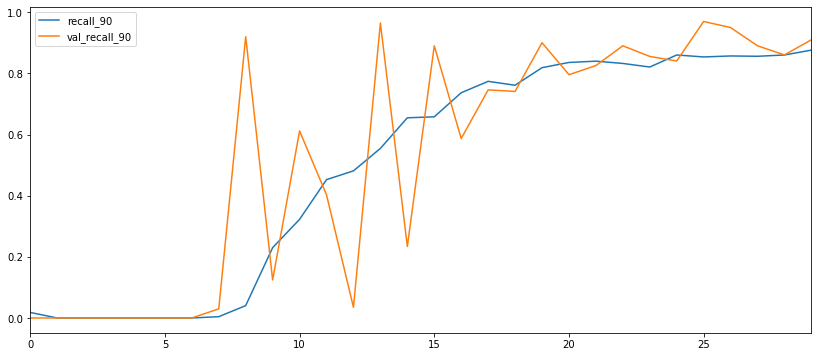

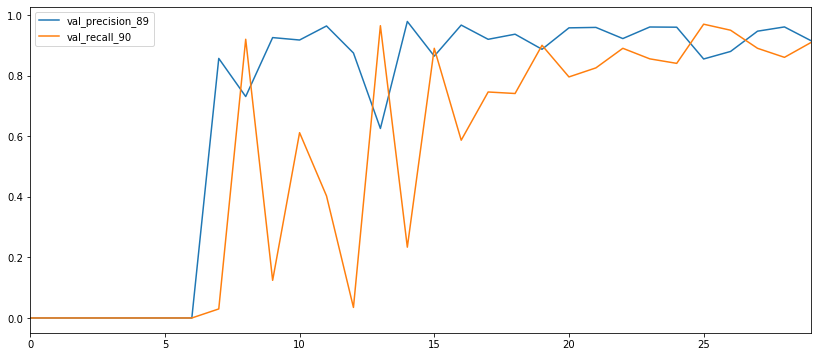

In [288]:
#Original: Dropout regularisation
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dropout(0.3))
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/reg_models_3/{epoch:02d}.h5')
cb = [mc, es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

Epoch 1/30
37/37 [==============================] - 59s 1s/step - loss: 0.5829 - acc: 0.7406 - precision_92: 0.1818 - recall_93: 0.0099 - val_loss: 0.6671 - val_acc: 0.7430 - val_precision_92: 0.0000e+00 - val_recall_93: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 53s 1s/step - loss: 0.5343 - acc: 0.7562 - precision_92: 0.2176 - recall_93: 0.0015 - val_loss: 0.6476 - val_acc: 0.7430 - val_precision_92: 0.0000e+00 - val_recall_93: 0.0000e+00
Epoch 3/30
37/37 [==============================] - 52s 1s/step - loss: 0.5304 - acc: 0.7429 - precision_92: 0.8093 - recall_93: 0.0164 - val_loss: 0.6416 - val_acc: 0.7430 - val_precision_92: 0.0000e+00 - val_recall_93: 0.0000e+00
Epoch 4/30
37/37 [==============================] - 52s 1s/step - loss: 0.4932 - acc: 0.7640 - precision_92: 0.7490 - recall_93: 0.0881 - val_loss: 0.6129 - val_acc: 0.7481 - val_precision_92: 0.8333 - val_recall_93: 0.0249
Epoch 5/30
37/37 [==============================] - 64s 2s/step - loss: 0.4851 -

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[541  40]
 [ 26 175]]
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       581
   Pneumonia       0.81      0.87      0.84       201

    accuracy                           0.92       782
   macro avg       0.88      0.90      0.89       782
weighted avg       0.92      0.92      0.92       782



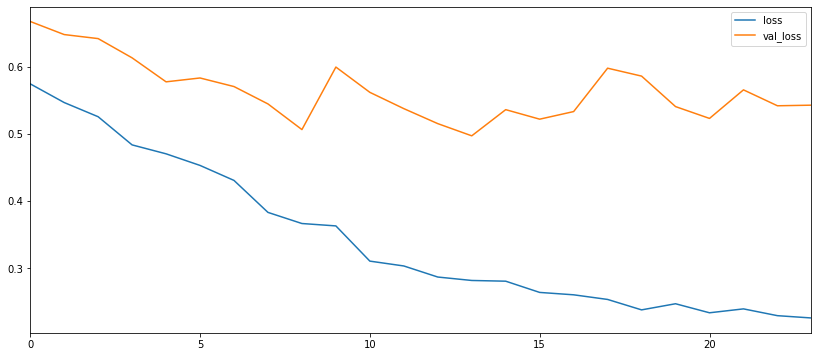

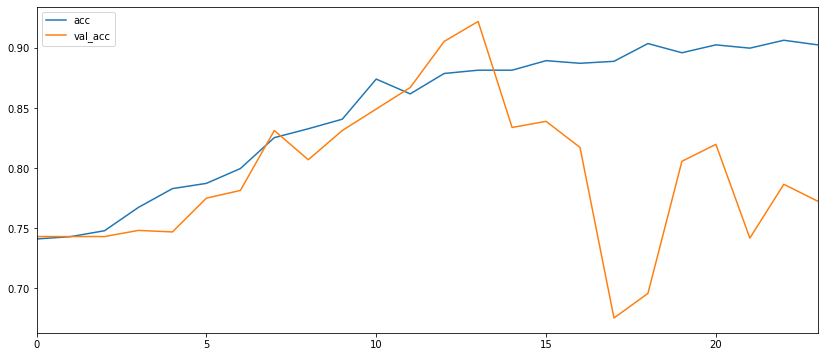

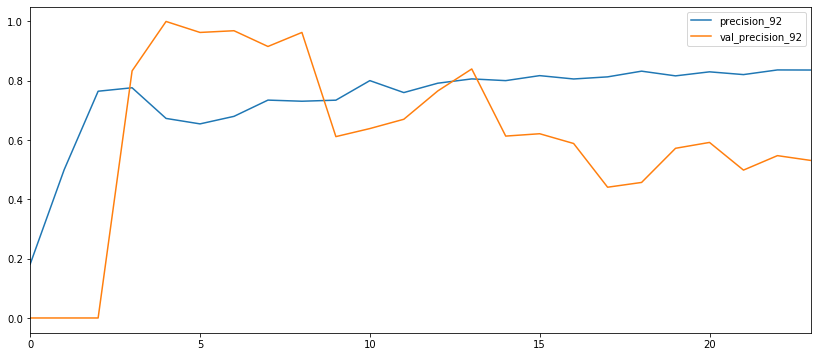

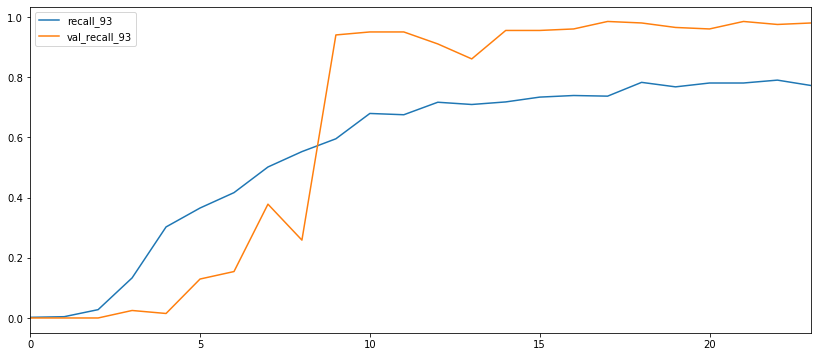

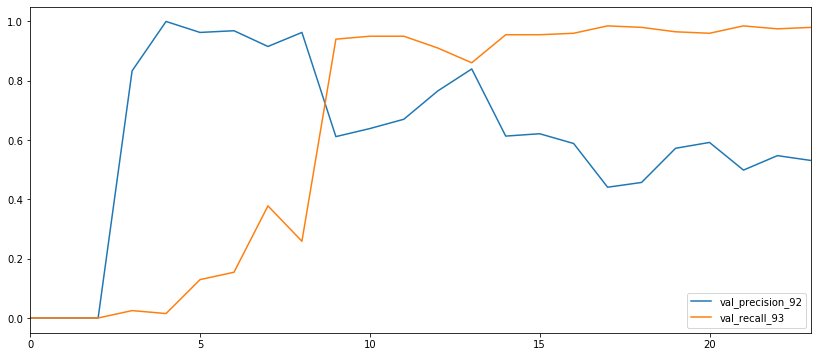

In [291]:
#Original: Dropout regularisation
conv_model = Sequential()
conv_model.add(Dropout(0.3))
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Dropout(0.3))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Dropout(0.3))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Dropout(0.3))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(Flatten())
conv_model.add(Dropout(0.3))
conv_model.add(Dense(256, 'relu'))
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/reg_models_3b/{epoch:02d}.h5')
cb = [mc, es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

l1 regularisation breaks the model. l2 and dropout (single layer before dense) made slight improvement, and looks like it would improve further with more epochs. I'll go for dropout.

#### Global Average Pooling

In [298]:
#Use global average pooling instead of a dense layer
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(64, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2, 2))
conv_model.add(Conv2D(128, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D(2,2))
conv_model.add(GlobalAveragePooling2D)
conv_model.add(Dense(1, 'sigmoid'))

conv_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/gap_models_1/{epoch:02d}.h5')
cb = [mc, es]
history = conv_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, conv_model)

TypeError: The added layer must be an instance of class Layer. Found: <class 'tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D'>

### Best Options

Create a model using the best options from the previous trials

In [ ]:
#Dilated CNN with 'selu', 'RMSprop', RandomNormal weight initialisation, and a dropout layer
BO_model = Sequential()
BO_model.add(Conv2D(32, (3, 3), activation='selu', dilation_rate=2, kernel_initializer=RandomNormal(), input_shape=(128, 128, 3)))
BO_model.add(Conv2D(64, (3, 3), activation='selu', dilation_rate=2, kernel_initializer=RandomNormal()))
BO_model.add(Conv2D(64, (3, 3), activation='selu', dilation_rate=2, kernel_initializer=RandomNormal()))
BO_model.add(MaxPooling2D(2, 2))
BO_model.add(Conv2D(128, (3, 3), activation='selu', kernel_initializer=RandomNormal()))
BO_model.add(MaxPooling2D(2, 2))
BO_model.add(Conv2D(256, (4, 4), activation='selu', kernel_initializer=RandomNormal()))
BO_model.add(MaxPooling2D(2, 2))
BO_model.add(Flatten())
BO_model.add(Dropout(0.3))
BO_model.add(Dense(256, 'selu', kernel_initializer=RandomNormal()))
BO_model.add(Dense(1, 'sigmoid'))

BO_model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])

es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/BO_models_1/{epoch:02d}.h5')
cb = [mc]
history = BO_model.fit(train_imgs, train_y, epochs=100, batch_size=50, validation_data=(val_imgs, val_y), callbacks=[cb])
results(history, BO_model)

Epoch 1/100
74/74 [==============================] - 390s 5s/step - loss: 134.8516 - acc: 0.5735 - precision_97: 0.2714 - recall_99: 0.3767 - val_loss: 0.7895 - val_acc: 0.7430 - val_precision_97: 0.0000e+00 - val_recall_99: 0.0000e+00
Epoch 2/100
74/74 [==============================] - 343s 5s/step - loss: 0.7770 - acc: 0.7306 - precision_97: 0.1443 - recall_99: 0.0272 - val_loss: 0.6065 - val_acc: 0.7430 - val_precision_97: 0.0000e+00 - val_recall_99: 0.0000e+00
Epoch 3/100
74/74 [==============================] - 324s 4s/step - loss: 1.7933 - acc: 0.7434 - precision_97: 0.0154 - recall_99: 7.4036e-04 - val_loss: 0.6115 - val_acc: 0.7430 - val_precision_97: 0.0000e+00 - val_recall_99: 0.0000e+00
Epoch 4/100
74/74 [==============================] - 340s 5s/step - loss: 0.6638 - acc: 0.7125 - precision_97: 0.2662 - recall_99: 0.0585 - val_loss: 0.8601 - val_acc: 0.7430 - val_precision_97: 0.0000e+00 - val_recall_99: 0.0000e+00
Epoch 5/100
74/74 [==============================] - 349s 

## Transfer

Use VGG19 as a base upon which to build my model; first with the base fully frozen, secondly with the top block unfrozen.

In [267]:
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [268]:
trans_model = Sequential()
trans_model.add(cnn_base)
trans_model.add(Flatten())
trans_model.add(Dense(256, 'relu'))
trans_model.add(Dense(1, 'sigmoid'))

In [269]:
cnn_base.trainable = False
for layer in trans_model.layers:
    print(layer.name, layer.trainable)
print(len(trans_model.trainable_weights))

vgg19 False
flatten_56 True
dense_185 True
dense_186 True
4


In [270]:
trans_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])
es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/trans_models_0/{epoch:02d}.h5')
cb = [mc, es]
history = trans_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=cb)

Epoch 1/30
37/37 [==============================] - 203s 5s/step - loss: 0.7537 - acc: 0.7036 - precision_76: 0.4318 - recall_77: 0.2641 - val_loss: 0.6119 - val_acc: 0.7430 - val_precision_76: 0.0000e+00 - val_recall_77: 0.0000e+00
Epoch 2/30
37/37 [==============================] - 197s 5s/step - loss: 0.3667 - acc: 0.8441 - precision_76: 0.7763 - recall_77: 0.4862 - val_loss: 0.2797 - val_acc: 0.8606 - val_precision_76: 1.0000 - val_recall_77: 0.4577
Epoch 3/30
37/37 [==============================] - 195s 5s/step - loss: 0.2675 - acc: 0.8778 - precision_76: 0.8191 - recall_77: 0.6886 - val_loss: 0.2100 - val_acc: 0.9194 - val_precision_76: 0.9662 - val_recall_77: 0.7114
Epoch 4/30
37/37 [==============================] - 196s 5s/step - loss: 0.2441 - acc: 0.8963 - precision_76: 0.8393 - recall_77: 0.7552 - val_loss: 0.2734 - val_acc: 0.8926 - val_precision_76: 0.7127 - val_recall_77: 0.9751
Epoch 5/30
37/37 [==============================] - 196s 5s/step - loss: 0.2041 - acc: 0.922

25/25 [==============================] - 38s 1s/step - loss: 0.1311 - acc: 0.9463 - precision_76: 0.9877 - recall_77: 0.8010
[0.13113783299922943, 0.9462915658950806, 0.987730085849762, 0.8009950518608093]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[579   2]
 [ 40 161]]
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97       581
   Pneumonia       0.99      0.80      0.88       201

    accuracy                           0.95       782
   macro avg       0.96      0.90      0.92       782
weighted avg       0.95      0.95      0.94       782



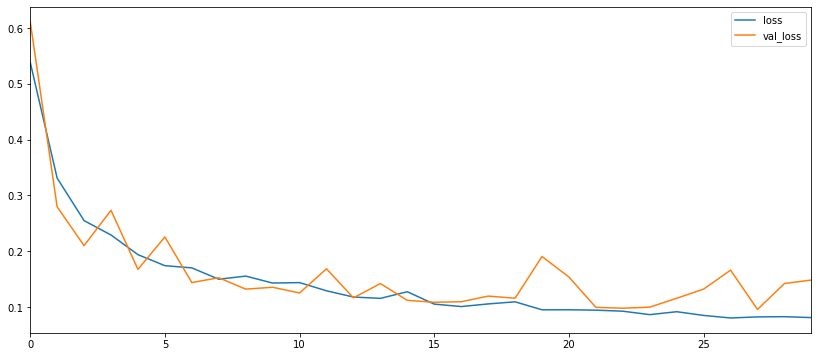

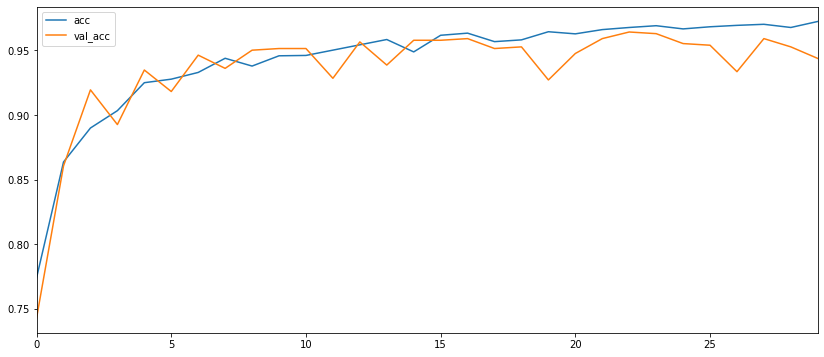

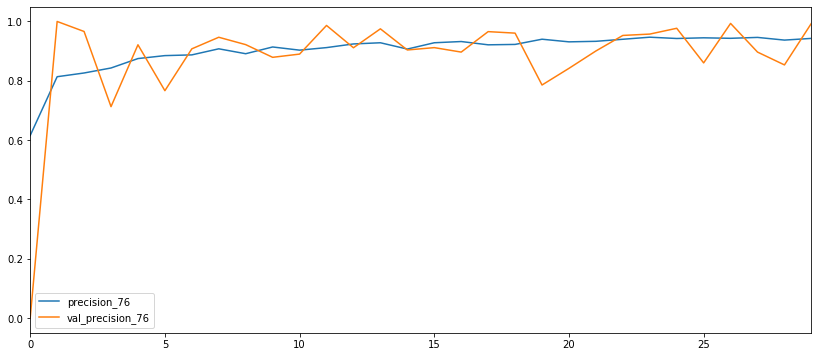

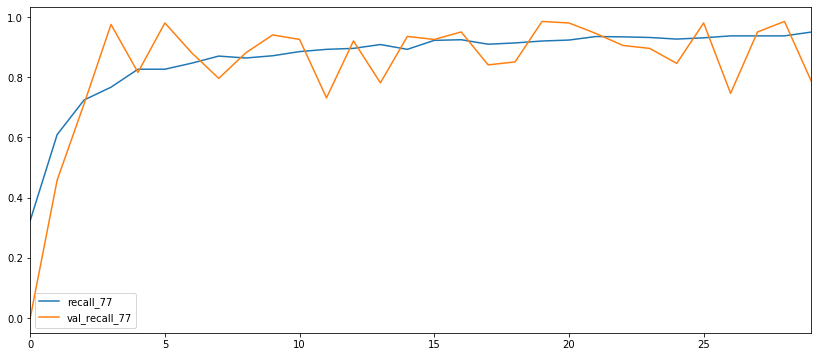

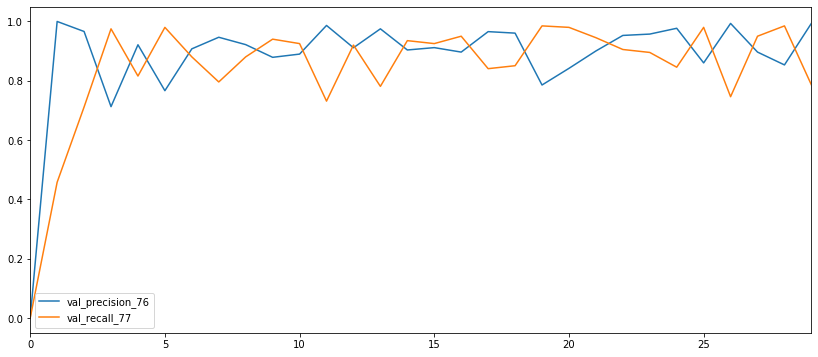

In [271]:
results(history, trans_model)

In [272]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [273]:
trans_model = Sequential()
trans_model.add(cnn_base)
trans_model.add(Flatten())
trans_model.add(Dense(256, 'relu'))
trans_model.add(Dense(1, 'sigmoid'))

cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

trans_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc', Precision(), Recall()])
es = EarlyStopping(patience=10, restore_best_weights=True)
mc = ModelCheckpoint('models/trans_models_1/{epoch:02d}.h5')
cb = [mc, es]
history = trans_model.fit(train_imgs, train_y, epochs=30, batch_size=100, validation_data=(val_imgs, val_y), callbacks=cb)

Epoch 1/30
37/37 [==============================] - 255s 7s/step - loss: 0.6630 - acc: 0.7111 - precision_77: 0.3422 - recall_78: 0.2028 - val_loss: 0.2088 - val_acc: 0.9399 - val_precision_77: 0.8500 - val_recall_78: 0.9303
Epoch 2/30
37/37 [==============================] - 249s 7s/step - loss: 0.2106 - acc: 0.9229 - precision_77: 0.8453 - recall_78: 0.8540 - val_loss: 0.1723 - val_acc: 0.9373 - val_precision_77: 0.8167 - val_recall_78: 0.9751
Epoch 3/30
37/37 [==============================] - 249s 7s/step - loss: 0.1749 - acc: 0.9273 - precision_77: 0.8490 - recall_78: 0.8780 - val_loss: 0.1141 - val_acc: 0.9552 - val_precision_77: 0.8952 - val_recall_78: 0.9353
Epoch 4/30
37/37 [==============================] - 249s 7s/step - loss: 0.1414 - acc: 0.9441 - precision_77: 0.8841 - recall_78: 0.9059 - val_loss: 0.0989 - val_acc: 0.9591 - val_precision_77: 0.9163 - val_recall_78: 0.9254
Epoch 5/30
37/37 [==============================] - 249s 7s/step - loss: 0.1155 - acc: 0.9515 - prec

25/25 [==============================] - 35s 1s/step - loss: 0.0583 - acc: 0.9795 - precision_77: 0.9512 - recall_78: 0.9701
[0.058346886187791824, 0.9795396327972412, 0.9512194991111755, 0.9701492786407471]


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[571  10]
 [  6 195]]
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       581
   Pneumonia       0.95      0.97      0.96       201

    accuracy                           0.98       782
   macro avg       0.97      0.98      0.97       782
weighted avg       0.98      0.98      0.98       782



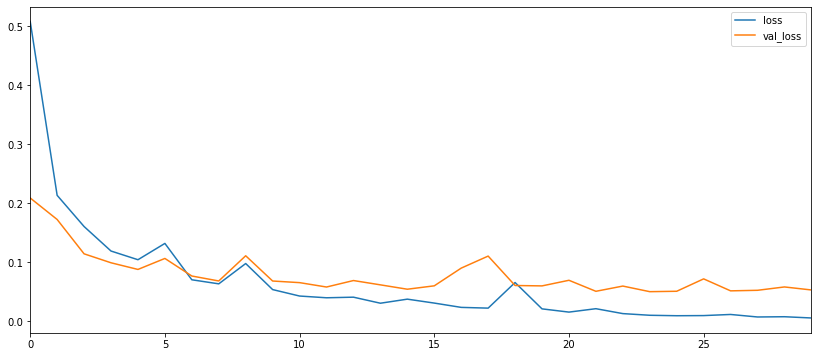

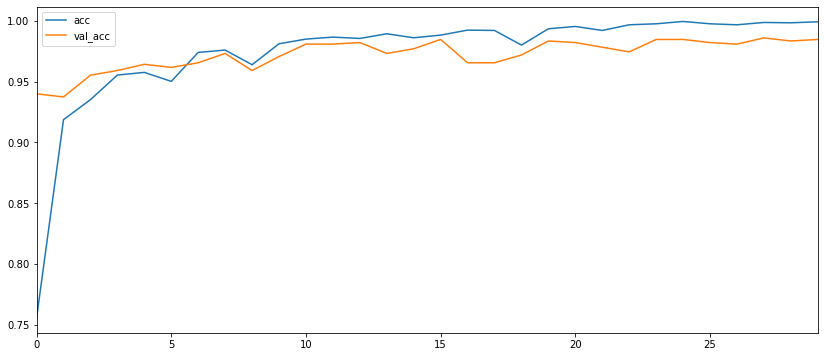

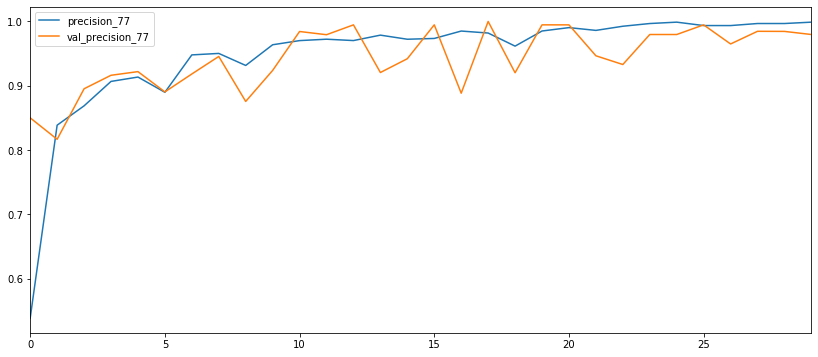

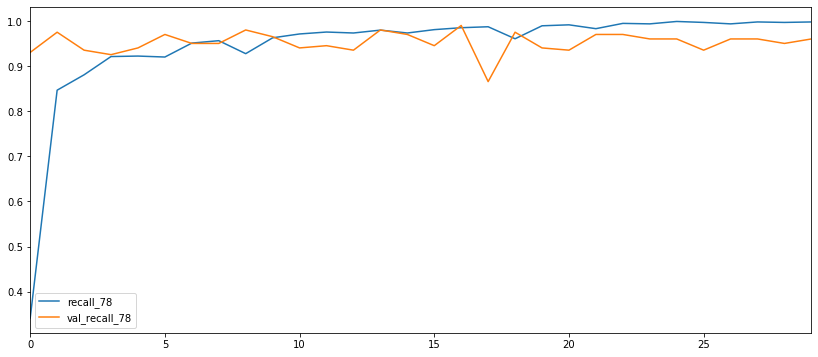

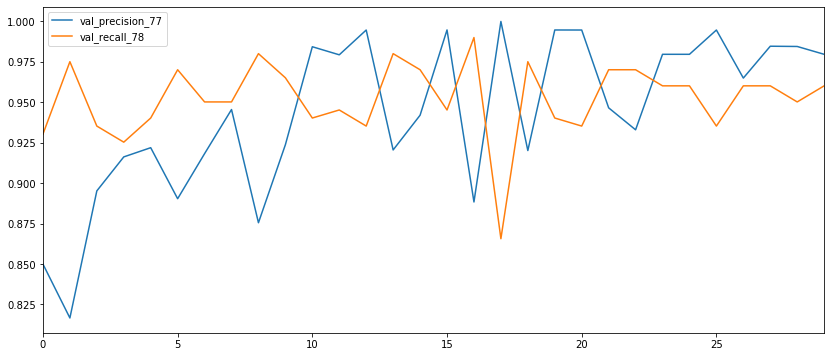

In [274]:
results(history, trans_model)

## Final Model
For my final model I'll be maximising the recall of the model so that cases of pneumonia don't go undiagnosed.

In [303]:
from keras.models import load_model
best = load_model('models/trans_models_1/24.h5')

In [304]:
best.evaluate(test_imgs, test_y)

25/25 [==============================] - 40s 1s/step - loss: 0.0506 - acc: 0.9770 - precision_77: 0.9463 - recall_78: 0.9652


[0.050580888986587524,
 0.9769821166992188,
 0.9463414549827576,
 0.96517413854599]

In [308]:
probs = best.predict(test_imgs)

In [371]:
#Note: just found that class_indices doesn't give labels > 
# > images were labelled incorrectly, want to maximise recall for class 0.0
y_pred = [0 if x < 0.95 else 1 for x in probs]
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       581
         1.0       0.99      0.91      0.95       201

    accuracy                           0.97       782
   macro avg       0.98      0.95      0.96       782
weighted avg       0.97      0.97      0.97       782



- Perfect recall for the test set, with 97% overall accuracy

### Layer Visualisation
Find below the output of 10 kernels from each of 3 different layers.

In [387]:
img = train_imgs[0]
img = np.expand_dims(img, axis=0)

In [475]:
layers = [cnn_base.layers[i] for i in [3, 6, 11, 16, 21]] #ends of blocks
layer_outputs = [layer.output for layer in layers]
activation_model = Model(inputs=cnn_base.input, outputs=layer_outputs)
activations = activation_model.predict(img)

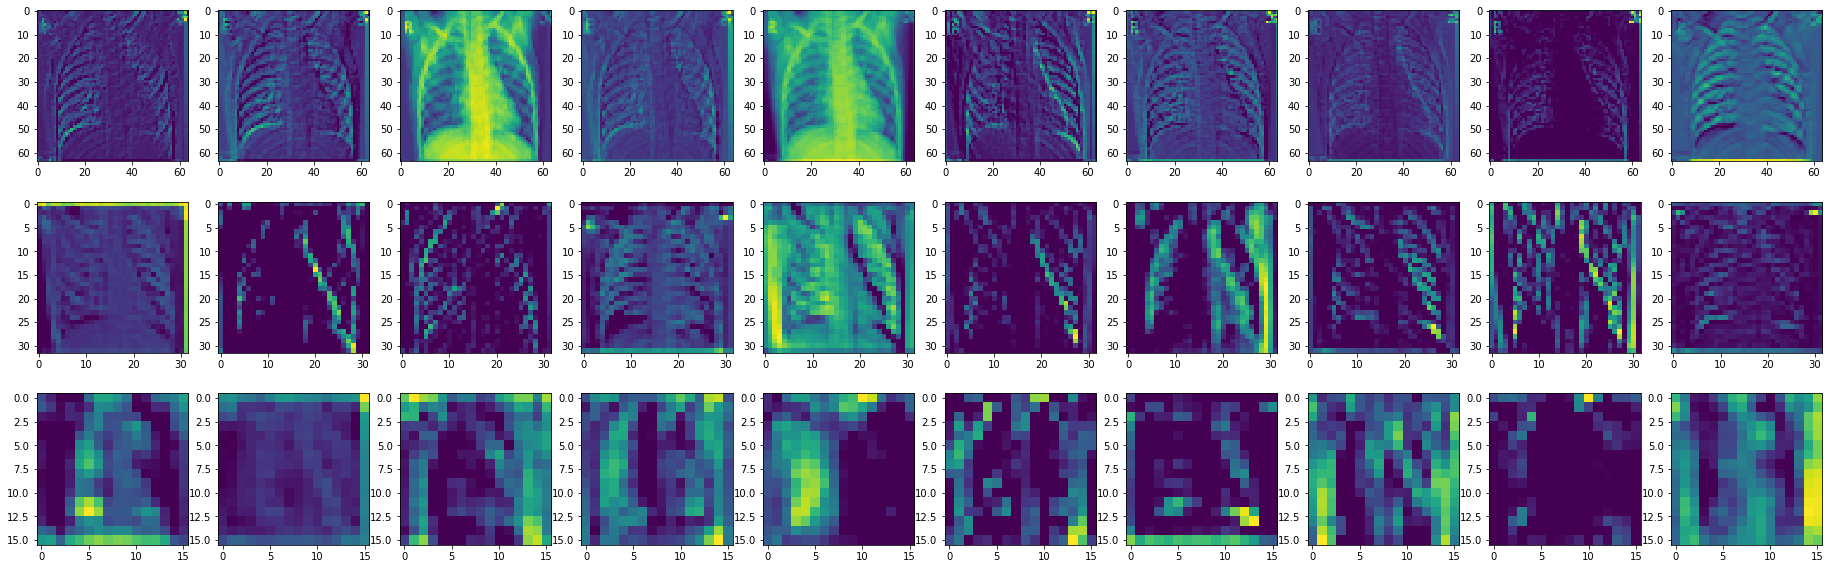

In [506]:
num_layers = 3
num_kernels = 10

fig, axes = plt.subplots(num_layers, num_kernels, figsize=(32, 10))

#i=0
# j=1

for i in range(num_layers):
    for j in range(num_kernels):
        ax = axes[i, j]
        ax.imshow(activations[i][0,:,:,j]);

## Future work

With more time:  
 - schedule learning rate decay
 - global average pooling
 - try a higher resolution
 - try different base models for transfer learning
 - try more epochs
 - try putting it in a sklearn wrapper to use plot_confusion_matrix
 - test the original test data